# Multi-Family Multi-Model Information Content Benchmark

This notebook performs comprehensive information-theoretic benchmarks on **multiple protein families** using **multiple FoldTree2 models** with different alphabet sizes, comparing them against standard amino acid representations.

## Purpose

Evaluate how well discrete structural alphabets (DSR - Discrete Structural Representations) capture biologically relevant information compared to amino acid sequences, specifically testing:

1. **Fold Discrimination**: Can k-mers distinguish protein folds better?
2. **Entropy Rate**: How compressible are the representations?
3. **Position-Specific Conservation**: Does entropy reflect functional constraints?
4. **Cross-Representation Information**: How much structural information predicts sequence?

## Family Data Sources

This notebook supports **two family data sources**:

### Option 1: Custom Families (USE_MAKESUBMAT_FAMILIES = False)
Manual curation of protein families in separate folders:
```
FAMILIES_DIR/
	├── rhodopsin/
	│   ├── structure1.pdb
	│   └── structure2.pdb
	├── kinase/
	│   ├── structure3.pdb
	│   └── structure4.pdb
	└── ...
```

### Option 2: AFDB Cluster Families (USE_MAKESUBMAT_FAMILIES = True) ⭐ RECOMMENDED
**Uses the same ~200+ families as `makesubmat.py`** from AlphaFold Database clusters:
```
struct_align/              # Created by makesubmat.py
	├── AF-A0A024RBG1-F1/   # AFDB cluster representative ID
	│   └── structs/
	│       ├── AF-A0A024RBG1-F1-model_v4.pdb
	│       ├── AF-P12345-F1-model_v4.pdb
	│       └── ...
	├── AF-A0A075B6H9-F1/
	│   └── structs/
	│       └── ...
	└── ... (200+ families)
```

**Prerequisites for Option 2**:
1. Run `makesubmat.py --download_structs` to fetch AFDB cluster structures
2. Point `MAKESUBMAT_BASE_DIR` to your datasets directory
3. Set `USE_MAKESUBMAT_FAMILIES = True` in Cell #3

**Advantages of Option 2**:
- **Consistency**: Benchmark on same data used for substitution matrices
- **Scale**: ~200+ diverse protein families automatically
- **Reproducibility**: Standard dataset from AlphaFold Database clusters
- **No manual curation**: Families pre-defined by structural clustering

## Benchmarks Performed (Per Family, Per Model)

### 1. **K-mer Fold Discrimination**
- Compute k-mer frequency distributions (k=1,2,3,4)
- Perform KMeans clustering
- Calculate silhouette scores as discrimination metric
- **Higher scores** = better fold separation

### 2. **Entropy Rate Estimation**  
- Build k-order Markov models (orders 0-3)
- Cross-validation for entropy estimation
- **Lower entropy** = more predictable/compressible representation

### 3. **Per-Position Entropy**
- Create Multiple Sequence Alignments (MSAs)
- Apply Henikoff sequence reweighting
- Calculate position-specific entropy
- **Entropy profile** reveals conserved vs variable positions

### 4. **Cross-Representation Mutual Information**
- Train Ridge regression: FoldTree2 features → AA features
- Cross-validation R² scores
- Spearman correlation between representations
- **Higher scores** = more shared information

## Outputs

1. **JSON**: `all_families_results.json` - Complete results
2. **CSV**: `all_families_results.csv` - Flattened table
3. **Plots**:
	 - `multi_family_benchmark_comparison.png` - Line plots across families
	 - `model_family_heatmaps.png` - Performance heatmaps

## How to Use

1. **Configure** (Cell #3):
	 - **Choose data source**: Set `USE_MAKESUBMAT_FAMILIES = True` (AFDB) or `False` (custom)
	 - **Set paths**: 
		 - If using AFDB: `MAKESUBMAT_BASE_DIR` (datasets directory)
		 - If custom: `FAMILIES_DIR` (your families directory)
	 - **Optional**: Set `MAX_FAMILIES` to limit number (useful for testing)
	 - Set `MODELS` to list of FoldTree2 model paths
	 - Adjust `BENCHMARK_PARAMS` if needed

2. **Run cells sequentially** (Cells 1-9)

3. **View results**:
	 - Terminal output shows progress and summary statistics
	 - Plots display comparative performance
	 - CSV/JSON files for detailed analysis

## Quick Start with AFDB Families

```python
# In Cell #3:
USE_MAKESUBMAT_FAMILIES = True
MAKESUBMAT_BASE_DIR = '/path/to/your/datasets'  # Contains struct_align/
MAX_FAMILIES = 50  # Start with 50 families for quick test (or None for all)

# Then run all cells
```

In [1]:
import os
import sys
import tqdm					

import glob
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Import FoldTree2 modules
sys.path.insert(0, '/home/dmoi/projects/foldtree2')
from foldtree2.src import encoder as ft2
from foldtree2.src.pdbgraph import PDB2PyG, StructureDataset
from torch_geometric.data import DataLoader
from Bio import SeqIO
from Bio.PDB import PDBParser

#import counter
from collections import Counter

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print("✓ Imports successful")

✓ Imports successful


In [ ]:
# ==================== CONFIGURATION ====================

from pathlib import Path

# Model paths (list of models to benchmark)
MODELS = [
	'/home/dmoi/projects/foldtree2/models/embedding_comparison/final/ft2_30_embeddings_big_best_encoder',
	'/home/dmoi/projects/foldtree2/models/embedding_comparison/final/ft2_40_embeddings_best_encoder',
	'/home/dmoi/projects/foldtree2/models/embedding_comparison/final/ft2_20_embeddings_best_encoder',
	'/home/dmoi/projects/foldtree2/models/embedding_comparison/final/ft2_10_embeddings_best_encoder',

	#'/home/dmoi/projects/foldtree2/models/embedding_comparison/20_embeddings/ft2_20_embeddings_best_encoder',
	#'/home/dmoi/projects/foldtree2/models/embedding_comparison/30_embeddings/ft2_30_embeddings_best_encoder',
	#'/home/dmoi/projects/foldtree2/models/embedding_comparison/40_embeddings/ft2_40_embeddings_best_encoder',
]

# ==================== FAMILY DATA SOURCE CONFIGURATION ====================
# Choose one of two modes:
#   1. Custom families in separate folders (USE_MAKESUBMAT_FAMILIES = False)
#   2. AFDB cluster families from makesubmat (USE_MAKESUBMAT_FAMILIES = True)

USE_MAKESUBMAT_FAMILIES = False  # Set to True to use makesubmat AFDB families

if USE_MAKESUBMAT_FAMILIES:
	# Path to the struct_align directory created by makesubmat.py
	# This contains one subfolder per AFDB cluster representative
	# Structure: MAKESUBMAT_BASE_DIR/struct_align/{repId}/structs/*.pdb
	MAKESUBMAT_BASE_DIR = '/mnt/data2/datasets'
	FAMILIES_DIR = os.path.join(MAKESUBMAT_BASE_DIR, 'struct_align')
	
	# Optional: Limit number of families (useful for quick tests)
	# Set to None to use all available families
	MAX_FAMILIES = None  # or e.g., 50 for first 50 families
	
	print(f"Using makesubmat AFDB cluster families from: {FAMILIES_DIR}")
else:
	# Custom families directory containing subfolders for each protein family
	# Each subfolder should contain PDB files for that family
	# Example structure:
	#   FAMILIES_DIR/
	#     rhodopsin/
	#       structure1.pdb
	#       structure2.pdb
	#     kinase/
	#       structure3.pdb
	#       structure4.pdb
	FAMILIES_DIR = '/home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes'
	MAX_FAMILIES = None
	
	print(f"Using custom families from: {FAMILIES_DIR}")

# Output directory for results
OUTPUT_DIR = '/home/dmoi/projects/foldtree2/benchmark_output'

# Device configuration
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Benchmark parameters
BENCHMARK_PARAMS = {
	'k_mer_sizes': [1, 2, 3, 4],
	'markov_orders': [0, 1, 2, 3],
	'cv_folds': 5,
	'alpha_smoothing': 0.001,
	'occupancy_threshold': 0.7,
	'reweight_threshold': 0.8,
}

# Standard amino acid alphabet
AA_ALPHABET = list('ACDEFGHIKLMNPQRSTVWY')

print(f"\nConfiguration loaded:")
print(f"  Models: {len(MODELS)}")
print(f"  Families directory: {FAMILIES_DIR}")
print(f"  Output: {OUTPUT_DIR}")
print(f"  Device: {DEVICE}")


Using custom families from: /home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes

Configuration loaded:
  Models: 4
  Families directory: /home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes
  Output: /home/dmoi/projects/foldtree2/benchmark_output
  Device: cuda:0


In [ ]:

# ==================== FAMILY DISCOVERY ====================

def discover_families(families_dir, use_makesubmat=False, max_families=None):
	"""
	Discover protein families from directory structure.
	
	Supports two modes:
	1. Custom families: Each subfolder is a family
	2. Makesubmat AFDB: Each subfolder contains a 'structs' subdirectory
	
	Args:
		families_dir: Base directory containing families
		use_makesubmat: If True, expect makesubmat structure (repId/structs/)
		max_families: Maximum number of families to include (None = all)
	
	Returns:
		dict: {family_name: {'path': str, 'n_structures': int}}
	"""
	families = {}
	
	if not os.path.isdir(families_dir):
		print(f"ERROR: Families directory not found: {families_dir}")
		return families
	
	print(f"Scanning directories in {families_dir}...")
	
	# Use os.scandir for efficient directory traversal
	family_count = 0
	with tqdm.tqdm(desc="Discovering families") as pbar:
		for entry in os.scandir(families_dir):
			if not entry.is_dir():
				continue
			
			# Check if we've reached the max_families limit
			if max_families is not None and family_count >= max_families:
				break
			
			family_base_path = entry.path
			
			# Determine the actual structures directory
			# directory structure: {repId}/structs/*.pdb
			structs_dir = os.path.join(family_base_path, 'structs')
			if not os.path.isdir(structs_dir):
				pbar.update(1)
				continue
			family_path = structs_dir
			
			# Count PDB files using os.scandir (much faster than glob)
			pdb_count = 0
			try:
				for file_entry in os.scandir(family_path):
					if file_entry.is_file() and file_entry.name.endswith('.pdb'):
						pdb_count += 1
			except (PermissionError, OSError):
				pbar.update(1)
				continue
			
			# Only include if there are structures
			if pdb_count > 0:
				families[entry.name] = {
					'path': family_path,
					'n_structures': pdb_count
				}
				family_count += 1
			
			pbar.update(1)
	
	return families

# Discover families
FAMILIES = discover_families(
	FAMILIES_DIR, 
	use_makesubmat=USE_MAKESUBMAT_FAMILIES,
	max_families=MAX_FAMILIES
)

print(f"\nDiscovered {len(FAMILIES)} protein families:")
if len(FAMILIES) == 0:
	print(f"ERROR: No families found!")
	if USE_MAKESUBMAT_FAMILIES:
		print(f"Expected structure: {FAMILIES_DIR}/{{repId}}/structs/*.pdb")
		print(f"Make sure you've run makesubmat.py with --download_structs first")
	else:
		print(f"Expected structure: {FAMILIES_DIR}/{{family_name}}/structs/*.pdb")
else:
	# Show first 10 families as sample
	sample_families = list(FAMILIES.items())[:10]
	for family_name, family_info in sample_families:
		print(f"  - {family_name}: {family_info['n_structures']} structures")
	
	if len(FAMILIES) > 10:
		print(f"  ... and {len(FAMILIES) - 10} more families")
	
	# Show statistics
	structure_counts = [info['n_structures'] for info in FAMILIES.values()]
	print(f"\nFamily statistics:")
	print(f"  Total families: {len(FAMILIES)}")
	print(f"  Total structures: {sum(structure_counts)}")
	print(f"  Structures per family (mean ± std): {np.mean(structure_counts):.1f} ± {np.std(structure_counts):.1f}")
	print(f"  Range: {min(structure_counts)} - {max(structure_counts)}")

Scanning directories in /home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes...


Discovering families: 504it [00:00, 13141.83it/s]


Discovered 500 protein families:
  - 1067473: 14 structures
  - 806905: 11 structures
  - 948912: 19 structures
  - 1067594: 17 structures
  - 850276: 5 structures
  - 1407943: 14 structures
  - 1356514: 16 structures
  - 1422110: 14 structures
  - 1426498: 19 structures
  - 1067568: 13 structures
  ... and 490 more families

Family statistics:
  Total families: 500
  Total structures: 7536
  Structures per family (mean ± std): 15.1 ± 2.4
  Range: 3 - 20


In [ ]:
from directory_tree import DisplayTree

# ==================== CLEANUP: REMOVE EMPTY DIRECTORIES ====================

def cleanup_empty_directories(base_dir, use_makesubmat=False, dry_run=True):
	"""
	Remove directories that don't contain any structure files.
	
	Args:
		base_dir: Base directory to scan
		use_makesubmat: If True, look for structs/ subdirectory
		dry_run: If True, only report what would be deleted (don't actually delete)
	
	Returns:
		tuple: (n_deleted, list_of_deleted_paths)
	"""
	if not os.path.isdir(base_dir):
		print(f"ERROR: Directory not found: {base_dir}")
		return 0, []
	
	deleted_dirs = []
	print(f"Scanning for empty directories in: {base_dir}")
	print(f"Mode: {'DRY RUN (no deletion)' if dry_run else 'DELETION ENABLED'}")
	
	rmcount = 0
	with tqdm.tqdm(desc="Scanning directories") as pbar:
		for entry in os.scandir(base_dir):
			if not entry.is_dir():
				continue
			
			# Determine the actual structures directory
			if use_makesubmat:
				# Check if structs/ subdirectory exists
				structs_dir = os.path.join(entry.path, 'structs')
				if not os.path.isdir(structs_dir):
					# No structs directory - mark for deletion
					check_dir = entry.path
					has_structures = False
				else:
					check_dir = structs_dir
					# Count PDB files in structs/
					has_structures = False
					try:
						for file_entry in os.scandir(check_dir):
							if file_entry.is_file() and file_entry.name.endswith('.pdb'):
								has_structures = True
								break
					except (PermissionError, OSError):
						pass
			else:
				# Check for PDB files directly in directory
				check_dir = entry.path
				has_structures = False
				try:
					for file_entry in os.scandir(check_dir):
						if file_entry.is_file() and file_entry.name.endswith('.pdb'):
							has_structures = True
							break
				except (PermissionError, OSError):
					pass
			
			# If no structures found, mark for deletion
			if not has_structures:
				deleted_dirs.append(entry.path)
				if not dry_run:
					import shutil
					try:
						shutil.rmtree(entry.path)
						#print(f"  ✓ Deleted: {entry.name}")
					except Exception as e:
						print(f"  ✗ Failed to delete {entry.name}: {e}")
				else:
					print(f"  [DRY RUN] Would delete: {entry.name}")
					#print dir tree strcuture
					DisplayTree(entry.path, maxDepth=3, showHidden=True)

				rmcount += 1
				if dry_run and rmcount > 30:
					print("  ... Dry run limit reached (200). Stopping further checks.")
					break
			pbar.update(1)
	
	print(f"\n{'='*70}")
	print(f"Summary:")
	print(f"  Empty directories found: {len(deleted_dirs)}")
	if not dry_run:
		print(f"  Directories deleted: {len(deleted_dirs)}")
	else:
		print(f"  (Set dry_run=False to actually delete)")
	print(f"{'='*70}")
	
	return len(deleted_dirs), deleted_dirs

# Example usage (with dry_run=True by default for safety):
# Uncomment to run cleanup

n_deleted, deleted_paths = cleanup_empty_directories(
	FAMILIES_DIR,
	use_makesubmat=USE_MAKESUBMAT_FAMILIES,
	dry_run=True  # Change to False to actually delete
)

print("✓ Cleanup utility loaded")
print("  Run cleanup_empty_directories() to scan for empty directories")
print("  Set dry_run=False to actually delete them")

Scanning for empty directories in: /home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes
Mode: DRY RUN (no deletion)


Scanning directories: 0it [00:00, ?it/s]

Scanning directories: 47it [00:00, 594.95it/s]

  [DRY RUN] Would delete: 806905
806905/
├── encoded.ASCII
├── encoded.ASCIIaln.txt
├── encoded.ASCIIaln.txt.hex
├── encoded.ASCIIaln.txt.raxml.bestModel
├── encoded.ASCIIaln.txt.raxml.bestTree
├── encoded.ASCIIaln.txt.raxml.bootstraps
├── encoded.ASCIIaln.txt.raxml.log
├── encoded.ASCIIaln.txt.raxml.mlTrees
├── encoded.ASCIIaln.txt.raxml.rba
├── encoded.ASCIIaln.txt.raxml.reduced.phy
├── encoded.ASCIIaln.txt.raxml.startTree
├── encoded.ASCIIaln.txt.raxml.support
├── encoded.ASCIIaln.txt.raxml_aln.fasta
├── encoded.fasta
├── encoded.hex
├── ft2_tree_aster.raxml.bestTree
├── identifiers.txt
├── raxml_lg_tree.raxml.bestModel
├── raxml_lg_tree.raxml.bestTree
├── raxml_lg_tree.raxml.log
├── raxml_lg_tree.raxml.mlTrees
├── raxml_lg_tree.raxml.rba
├── raxml_lg_tree.raxml.startTree
├── raxml_lg_tree_aster.raxml.bestTree
├── sequences.aligned.fa
├── sequences.fasta
├── site_likelihood_AA.raxml.bestModel
├── site_likelihood_AA.raxml.bestTree
├── site_likelihood_AA.raxml.log
├── site_likelihood_

In [ ]:
# ==================== DATA LOADING & ENCODING ====================

class ModelBenchmark:
	"""Container for model encoding results and metadata"""
	def __init__(self, model_path: str, device , verbose = True):
		self.model_path = model_path
		self.model_name = Path(model_path).stem
		self.device = device
		
		# Load encoder
		if verbose:
			print(f"  Loading model: {self.model_name}...")
		self.encoder = torch.load(model_path + '.pt', map_location=device, weights_only=False)
		self.encoder = self.encoder.to(device)
		self.encoder.device = device
		self.encoder.eval()
		
		# Extract model metadata
		self.num_embeddings = self.encoder.num_embeddings
		self.embedding_dim = self.encoder.out_channels
		
		# Storage for encoded sequences
		self.encoded_fasta = None
		self.encoded_df = None
		self.alphabet = None
		self.char_position_map = None
		if verbose:
			print(f"    ✓ Loaded: {self.num_embeddings} embeddings, dim={self.embedding_dim}")
	
	def encode_structures(self, structures_loader, output_dir, family_name="encoded" , verbose = True):
		"""Encode structures using this model"""
		output_path = os.path.join(output_dir, f"{family_name}_{self.model_name}_encoded.fasta")
		
		with torch.no_grad():
			if verbose:
				print(f"  Encoding structures with {self.model_name}...")
			self.encoder.encode_structures_fasta(
				structures_loader, 
				output_path, 
				replace=True
			)		
		self.encoded_fasta = output_path
		self.encoded_df = ft2.load_encoded_fasta(output_path, alphabet=None, replace=False)
		self._build_alphabet(verbose=verbose)
		if verbose:
			print(f"    ✓ Encoded {len(self.encoded_df)} sequences")
		return output_path
	
	def _build_alphabet(self , verbose = True):
		"""Build alphabet from encoded sequences"""
		char_set = set()
		for seq in self.encoded_df.seq:
			char_set = char_set.union(set(seq))
		self.alphabet = sorted(list(char_set))
		self.char_position_map = {char: i for i, char in enumerate(self.alphabet)}
		if verbose:
			print(f"    ✓ Built alphabet of size {len(self.alphabet)}")

def load_structures(structures_dir: str, converter: PDB2PyG, verbose: bool = True , struct_dataset=None):
	"""Load and convert PDB structures to PyG format"""
	pdb_files = glob.glob(os.path.join(structures_dir, "*.pdb"))
	if verbose:
		print(f"  Found {len(pdb_files)} PDB files")
	
	if len(pdb_files) == 0:
		raise ValueError(f"No PDB files found in {structures_dir}")
	
	if struct_dataset is not None:
		#find the pdb files in the struct dataset that are in the pdb_files list
		protids = [Path(pdb_file).stem for pdb_file in pdb_files]
		for protid in protids:
			if protid in struct_dataset.structlist:
				data = struct_dataset[protid]
				yield data
	def struct_generator():
		for pdb_file in pdb_files:
			try:
				data = converter.struct2pyg(pdb_file)
				if data:
					yield data
			except Exception as e:
				if verbose:
					print(f"    Warning: Failed to convert {Path(pdb_file).name}: {e}")
				continue
	
	return struct_generator()

def extract_aa_sequences(structures_dir: str, output_dir: str, family_name: str = "sequences", verbose: bool = True):
	"""Extract amino acid sequences from PDB files"""
	parser = PDBParser(QUIET=True)
	aa_dict = {
		'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
		'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
		'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
		'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
	}
	
	pdb_files = glob.glob(os.path.join(structures_dir, "*.pdb"))
	sequences = {}
	
	if verbose:
		print(f"  Extracting amino acid sequences from {len(pdb_files)} structures...")
	for pdb_file in pdb_files:
		structure_id = Path(pdb_file).stem
		try:
			structure = parser.get_structure(structure_id, pdb_file)
			seq = ""
			for model in structure:
				for chain in model:
					for residue in chain:
						if residue.get_resname() in aa_dict:
							seq += aa_dict[residue.get_resname()]
					break  # Only first chain
				break  # Only first model
			
			if seq:
				sequences[structure_id] = seq
		except Exception as e:
			if verbose:
				print(f"    Warning: Failed to extract sequence from {Path(pdb_file).name}: {e}")
	
	# Write to FASTA with family-specific naming
	output_path = os.path.join(output_dir, f"{family_name}_aa_sequences.fasta")
	with open(output_path, 'w') as f:
		for struct_id, seq in sequences.items():
			f.write(f">{struct_id}\n{seq}\n")
	
	if verbose:
		print(f"    ✓ Extracted {len(sequences)} AA sequences")
	return output_path, sequences

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Initialize converter
converter = PDB2PyG(aapropcsv='/home/dmoi/projects/foldtree2/foldtree2/config/aaindex1.csv')

print("✓ Setup complete")

✓ Setup complete


In [9]:
#create a pyg hdf5 dataset for all families
structures = glob.glob(os.path.join(FAMILIES_DIR, "*", "structs", "*.pdb"))
h5file = os.path.join(OUTPUT_DIR, "information_content_benchmark_dataset.h5")
#converter.store_pyg(structures, filename=h5file, foldxdir = None, verbose = False , add_prody = False , distance=15)

In [10]:
from foldtree2.src import pdbgraph
struct_data = pdbgraph.StructureDataset(h5file)

In [ ]:

def fasta2df(fasta_file):
	entries = {}
	with open(fasta_file, 'r') as f:
		for l in f:
			if l.startswith('>'):
				seq_id = l[1:].strip()
				entries[seq_id] = ''
			else:
				entries[seq_id] += l.strip()
	return pd.DataFrame.from_dict(entries, orient='index', columns=['seq']).reset_index().rename(columns={'index': 'id'})	


In [ ]:
# ==================== RUN ALL BENCHMARKS PER FAMILY ====================
compile_families = False  # Set to False to skip compilation and load existing dataset
if compile_families:
	# Store results per family
	all_results = []

	for family_name, family_info in tqdm.tqdm(FAMILIES.items(), desc="Processing families"):
		family_path = family_info['path']
		family_results = {
			'n_structures': family_info['n_structures'],
			'models': [],
			'alphabet_sizes': [],
			'k_mer_discrimination': {},
			'entropy_rates': {},
			'per_position_entropy': {},
			'cross_representation_mi': {}
		}
		
		# Extract AA sequences for this family
		aa_fasta_path, aa_sequences = extract_aa_sequences(
			family_path, OUTPUT_DIR, family_name, verbose=False
		)

		family_df = fasta2df(aa_fasta_path)
		family_df['models']= 'AA_sequences'
		family_df['alphabet_sizes']= 20
		family_df['family']= family_name
		all_results.append(family_df)

		# Encode structures with each model
		for model_path in MODELS:
			mb = ModelBenchmark(model_path, DEVICE , verbose = False)
			# Load and encode structures
			structures_loader = load_structures(family_path, converter, verbose=False , struct_dataset=struct_data)
			fasta_path = os.path.join(OUTPUT_DIR, f"{family_name}.fasta")
			fasta_path = mb.encode_structures(structures_loader, OUTPUT_DIR, family_name , verbose = False)
			family_df = fasta2df(fasta_path)

			family_df['models']= mb.model_name
			family_df['alphabet_sizes']= mb.num_embeddings
			family_df['family']= family_name
			all_results.append(family_df)

	all_results_df = pd.concat(all_results, ignore_index=True)
	all_results_df.to_csv(os.path.join(OUTPUT_DIR, "alphabet_benchmark_dataset.csv"), index=False)
	print("✓ Dataset compilation complete. Results saved to alphabet_benchmark_dataset.csv")
else:
	all_results_df = pd.read_csv( os.path.join(OUTPUT_DIR, "alphabet_benchmark_dataset.csv" ) )
	print("✓ Dataset loaded")

✓ Dataset loaded


In [ ]:
#store alphabet for each model in a dict	
model_alphabets = {}
for model in all_results_df['models'].unique():
	model_alphabets[model] = set(''.join(all_results_df[all_results_df['models'] == model]['seq']))

for model, alphabet in model_alphabets.items():
	print(f"Model: {model}, Alphabet size: {len(alphabet)}")


Model: AA_sequences, Alphabet size: 20
Model: ft2_30_embeddings_big_best_encoder, Alphabet size: 30
Model: ft2_40_embeddings_best_encoder, Alphabet size: 40
Model: ft2_20_embeddings_best_encoder, Alphabet size: 20
Model: ft2_10_embeddings_best_encoder, Alphabet size: 10


In [17]:
all_results_df

,id,seq,models,alphabet_sizes,family
0,A0A178W1Q6,MGAQKKGGAAARVSEDAEVQSRHRLQAILLADSFATKFRPVTLERP...,AA_sequences,20,1067473
1,A0A2K1L8W6,MAKKGVKAVTEIADDEVRVPLQAVVLADSFTQKFRPITLEKPKVLL...,AA_sequences,20,1067473
2,D2V2R9,MKKTKKTGGPVKTEDVLKAVVLADSFTKEMRPITLSKPRCLLPVNN...,AA_sequences,20,1067473
3,A0A3B3IUB1,MAAPVVAPPGVVVSRANKRSGAGPGGSGGGGARGAEEEPPPPLQAV...,AA_sequences,20,1067473
4,A0CKT0,MSEFYAVILADNYDNQFNHLTNTLPKSLFPFVDDLIIEHQINWLSK...,AA_sequences,20,1067473
...,...,...,...,...,...
37655,Q54I90,\tÿÿÿÿÿÿÿ...,ft2_10_embeddings_best_encoder,10,1323557
37656,A0DXG9,\tÿ\tÿ\t...,ft2_10_embeddings_best_encoder,10,1323557
37657,Q17880,\tÿÿ...,ft2_10_embeddings_best_encoder,10,1323557
37658,A8ICJ1,ÿÿÿÿ...,ft2_10_embeddings_best_encoder,10,1323557


In [ ]:
# ==================== PERMUTATION CONTROLS: NEGATIVE TESTS + INVARIANCE TEST ====================
print("\n[controls] Building permutation-control variants of sequences for MI / k-mer benchmarks...")

import numpy as np
from copy import deepcopy

RNG_SEED = 123
rng = np.random.default_rng(RNG_SEED)

# Which controls to build
MAKE_WITHIN_SHUFFLE = True     # shuffle tokens within each sequence (preserve unigram)
MAKE_LABEL_BIJECTION = False    # permute labels globally (bijection) (should be invariant)
MAKE_MSA_COL_SHUFFLE = False    # handled inside MSA-based benchmarks via model-name suffix

# For label-bijection: build one mapping per model (stable & stored)
control_meta = {"label_bijections": {}}

def shuffle_within_sequence(seq: str, rng: np.random.Generator) -> str:
	# preserves unigram counts exactly; destroys adjacency/order
	if len(seq) <= 1:
		return seq
	arr = np.array(list(seq), dtype='<U1')
	rng.shuffle(arr)
	return ''.join(arr.tolist())

def permute_labels(seq: str, mapping: dict) -> str:
	# mapping should be a bijection over the alphabet symbols used
	return ''.join(mapping.get(ch, ch) for ch in seq)

def make_bijection_for_alphabet(alphabet: list, rng: np.random.Generator) -> dict:
	alphabet = list(alphabet)
	shuf = alphabet.copy()
	rng.shuffle(shuf)
	return {a: b for a, b in zip(alphabet, shuf)}

# Build augmented dataframe
all_results_df_ctrl = all_results_df.copy()

# Extend model_alphabets dict for control models
model_alphabets_ctrl = deepcopy(model_alphabets)

# Helper to append a derived model into the dataframe
def append_control_model(df, base_model_name, new_model_name, transform_fn):
	sub = df[df['models'] == base_model_name].copy()
	if sub.empty:
		return None
	sub['seq'] = sub['seq'].apply(transform_fn)
	sub['models'] = new_model_name
	return sub

# Create controls per model
base_models = sorted(all_results_df['models'].unique())

new_rows = []
for model_name in base_models:
	# Skip models not in alphabet dict
	if model_name not in model_alphabets:
		continue

	alphabet = sorted(list(model_alphabets[model_name]))
	if len(alphabet) == 0:
		continue

	# 1) Within-sequence shuffle (negative control)
	if MAKE_WITHIN_SHUFFLE:
		ctrl_name = f"{model_name}__shuf_within"
		sub = append_control_model(
			all_results_df, model_name, ctrl_name,
			transform_fn=lambda s, _rng=rng: shuffle_within_sequence(s, _rng)
		)
		if sub is not None:
			new_rows.append(sub)
			model_alphabets_ctrl[ctrl_name] = set(alphabet)

	# 2) Global label bijection (invariance control)
	if MAKE_LABEL_BIJECTION:
		# Make a deterministic mapping per model using a derived seed
		# (so changing row order doesn't change the permutation)
		local_rng = np.random.default_rng(abs(hash((RNG_SEED, model_name))) % (2**32))
		bij = make_bijection_for_alphabet(alphabet, local_rng)
		control_meta["label_bijections"][model_name] = bij

		ctrl_name = f"{model_name}__labelperm"
		sub = append_control_model(
			all_results_df, model_name, ctrl_name,
			transform_fn=lambda s, _bij=bij: permute_labels(s, _bij)
		)
		if sub is not None:
			new_rows.append(sub)
			# NOTE: alphabet support remains the same set (bijection within the set)
			model_alphabets_ctrl[ctrl_name] = set(alphabet)

	# 3) MSA column shuffle flag (handled at MSA stage)
	# We create a "model alias" so downstream loops will include it,
	# but it uses the same sequences as the base model (alignment-level shuffle happens later).
	if MAKE_MSA_COL_SHUFFLE:
		ctrl_name = f"{model_name}__msa_colshuf"
		sub = all_results_df[all_results_df['models'] == model_name].copy()
		if not sub.empty:
			sub['models'] = ctrl_name
			new_rows.append(sub)
			model_alphabets_ctrl[ctrl_name] = set(alphabet)

if new_rows:
	all_results_df_ctrl = pd.concat([all_results_df_ctrl] + new_rows, ignore_index=True)
	# if concatenate produced ndarray, recover dataframe
	if not hasattr(all_results_df_ctrl, "columns"):
		all_results_df_ctrl = pd.concat([all_results_df_ctrl] + new_rows, ignore_index=True)
else:
	print("[controls] No new rows created (check model_alphabets / model names).")

print(f"[controls] Base models: {len(base_models)} | Total models now: {all_results_df_ctrl['models'].nunique()}")
print("[controls] Examples of added models:",
	  [m for m in sorted(all_results_df_ctrl['models'].unique()) if "__" in m][:10])

# Swap these into your pipeline by using:
#   all_results_df = all_results_df_ctrl
#   model_alphabets = model_alphabets_ctrl



[controls] Building permutation-control variants of sequences for MI / k-mer benchmarks...
[controls] Base models: 5 | Total models now: 10
[controls] Examples of added models: ['AA_sequences__shuf_within', 'ft2_10_embeddings_best_encoder__shuf_within', 'ft2_20_embeddings_best_encoder__shuf_within', 'ft2_30_embeddings_big_best_encoder__shuf_within', 'ft2_40_embeddings_best_encoder__shuf_within']


In [59]:
# ==================== BENCHMARK 1: K-MER FOLD DISCRIMINATION ====================
print("\n4. K-mer Fold Discrimination (Multi-Family)")
print("   Sampling families and classifying by Jaccard similarity (K-fold prototypes)...")

from collections import Counter, defaultdict
import numpy as np

# Initialize results storage (keep your existing structure)
family_results = {
	'sampled_families': [],
	'k_mer_discrimination': {},
	'entropy_rates': {},
	'per_position_entropy': {},
	'cross_representation_mi': {}
}

def jaccard_similarity(a, b):
	if not a and not b:
		return 0.0
	return len(a & b) / len(a | b)

def weighted_jaccard_similarity(a_counts, b_counts):
	all_keys = set(a_counts) | set(b_counts)
	if not all_keys:
		return 0.0
	num = sum(min(a_counts.get(k, 0), b_counts.get(k, 0)) for k in all_keys)
	den = sum(max(a_counts.get(k, 0), b_counts.get(k, 0)) for k in all_keys)
	return num / den if den > 0 else 0.0

def build_kmers(seq, k):
	if len(seq) < k:
		return []
	return [seq[i:i+k] for i in range(len(seq) - k + 1)]

def make_stratified_folds(indices_by_family, n_folds, rng):
	"""
	Create stratified folds over indices, preserving family proportions as much as possible.
	Returns: list of fold index-lists (each fold is a list of global indices).
	"""
	# shuffle indices within each family
	fam_to_indices = {fam: idxs.copy() for fam, idxs in indices_by_family.items()}
	for fam in fam_to_indices:
		rng.shuffle(fam_to_indices[fam])

	folds = [[] for _ in range(n_folds)]
	# round-robin assign examples from each family into folds
	for fam, idxs in fam_to_indices.items():
		for i, idx in enumerate(idxs):
			folds[i % n_folds].append(idx)

	# shuffle within folds (optional)
	for f in folds:
		rng.shuffle(f)

	return folds

def run_kmer_fold_discrimination(all_results_df, n_families=100, n_folds=5, seed=42, use_weighted=False):
	# Sample families
	unique_families = all_results_df['family'].unique()
	n_families = min(n_families, len(unique_families))
	rng = np.random.default_rng(seed)
	sampled_families = rng.choice(unique_families, size=n_families, replace=False)

	family_results['sampled_families'] = list(sampled_families)

	# Filter all_results_df for sampled families
	family_df = all_results_df[all_results_df['family'].isin(sampled_families)].copy()

	print(f"   Sampled {len(sampled_families)} families.")

	# Group by model
	for model_name in family_df['models'].unique():
		model_df = family_df[family_df['models'] == model_name].reset_index(drop=True)
		if len(model_df) == 0:
			continue

		sequences = model_df['seq'].tolist()
		families = model_df['family'].tolist()

		print(f"   {model_name}:")

		# Build stratified folds over sequences (by family)
		indices_by_family = defaultdict(list)
		for idx, fam in enumerate(families):
			indices_by_family[fam].append(idx)

		# If some families have 1 sequence, stratified K-fold still works (some folds won't contain them)
		cur_n_folds = min(n_folds, len(model_df))
		if cur_n_folds < 2:
			print("      (Skipping: not enough sequences for CV)")
			continue

		folds = make_stratified_folds(indices_by_family, n_folds=cur_n_folds, rng=rng)

		k_mer_results = {}
		for k in [1, 2, 3, 4]:
			fold_accuracies = []

			# Precompute per-sequence k-mer sets/counts once (speed)
			seq_kmer_sets = []
			seq_kmer_counts = []
			for seq in sequences:
				km = build_kmers(seq, k)
				seq_kmer_sets.append(set(km))
				seq_kmer_counts.append(Counter(km))

			for fold_idx in range(cur_n_folds):
				test_indices = set(folds[fold_idx])
				train_indices = [i for i in range(len(model_df)) if i not in test_indices]

				# Build family prototypes from TRAIN ONLY
				family_kmer_sets = {fam: set() for fam in sampled_families}
				family_kmer_counts = {fam: Counter() for fam in sampled_families}

				for i in train_indices:
					fam = families[i]
					# only build prototypes for sampled families
					if fam not in family_kmer_sets:
						continue
					family_kmer_sets[fam].update(seq_kmer_sets[i])
					family_kmer_counts[fam].update(seq_kmer_counts[i])

				# Classify TEST sequences
				correct = 0
				total = 0
				for i in test_indices:
					true_fam = families[i]
					# only evaluate sampled families
					if true_fam not in family_kmer_sets:
						continue

					best_fam = None
					best_score = -1.0

					for fam in sampled_families:
						if use_weighted:
							score = weighted_jaccard_similarity(seq_kmer_counts[i], family_kmer_counts[fam])
						else:
							score = jaccard_similarity(seq_kmer_sets[i], family_kmer_sets[fam])

						if score > best_score:
							best_score = score
							best_fam = fam

					if best_fam == true_fam:
						correct += 1
					total += 1

				if total > 0:
					fold_accuracies.append(correct / total)

			# Summarize across folds
			if fold_accuracies:
				mean_acc = float(np.mean(fold_accuracies))
				std_acc = float(np.std(fold_accuracies, ddof=1)) if len(fold_accuracies) > 1 else 0.0
				sem_acc = float(std_acc / np.sqrt(len(fold_accuracies))) if len(fold_accuracies) > 1 else 0.0
			else:
				mean_acc, sem_acc = 0.0, 0.0

			k_mer_results[f'k={k}'] = {
				'accuracy_mean': mean_acc,
				'accuracy_sem': sem_acc,
				'fold_accuracies': fold_accuracies,
				'n_sequences': len(sequences),
				'n_families': len(sampled_families),
				'n_folds': cur_n_folds
			}
			print(f"      k={k}: accuracy={mean_acc:.3f} ± {sem_acc:.3f} (SEM over {cur_n_folds} folds)")

		family_results['k_mer_discrimination'][model_name] = k_mer_results

	return family_results

kmer_results = run_kmer_fold_discrimination(all_results_df_ctrl, n_families=100, n_folds=5, seed=42, use_weighted=False)
print("\n✓ K-mer fold discrimination benchmark complete.")



4. K-mer Fold Discrimination (Multi-Family)
   Sampling families and classifying by Jaccard similarity (K-fold prototypes)...
   Sampled 100 families.
   AA_sequences:
      k=1: accuracy=0.017 ± 0.001 (SEM over 5 folds)
      k=2: accuracy=0.275 ± 0.007 (SEM over 5 folds)
      k=3: accuracy=0.942 ± 0.005 (SEM over 5 folds)
      k=4: accuracy=0.990 ± 0.004 (SEM over 5 folds)
   ft2_30_embeddings_big_best_encoder:
      k=1: accuracy=0.011 ± 0.001 (SEM over 5 folds)
      k=2: accuracy=0.579 ± 0.007 (SEM over 5 folds)
      k=3: accuracy=0.975 ± 0.002 (SEM over 5 folds)
      k=4: accuracy=0.993 ± 0.003 (SEM over 5 folds)
   ft2_40_embeddings_best_encoder:
      k=1: accuracy=0.036 ± 0.003 (SEM over 5 folds)
      k=2: accuracy=0.520 ± 0.009 (SEM over 5 folds)
      k=3: accuracy=0.971 ± 0.004 (SEM over 5 folds)
      k=4: accuracy=0.987 ± 0.003 (SEM over 5 folds)
   ft2_20_embeddings_best_encoder:
      k=1: accuracy=0.009 ± 0.000 (SEM over 5 folds)
      k=2: accuracy=0.252 ± 0.003

In [60]:
print(kmer_results)


{'sampled_families': [1422747, 1067223, 1067522, 1377262, 1419704, 1003993, 1382205, 1067335, 1408781, 1067343, 1422782, 1314599, 1067427, 1066375, 1417309, 1067384, 1372175, 1426499, 1424587, 1384967, 1067400, 909352, 1422784, 1391649, 1426549, 1399400, 1067302, 1364490, 1361927, 1378162, 814590, 1360172, 770707, 1422622, 1368953, 1392015, 1067308, 1385037, 1067539, 1067298, 1333257, 1425268, 1425034, 1422111, 882257, 866568, 1402039, 1067342, 1401205, 1402289, 1421583, 1417181, 1067297, 770531, 1424970, 1385904, 1067393, 1344626, 1067296, 1067310, 1410230, 1428602, 1007909, 1424134, 1049256, 1324065, 1029405, 1427648, 1304109, 866569, 1306941, 1353298, 843003, 1418490, 1382757, 1067375, 1427061, 1359411, 1067424, 1404525, 1427559, 1428549, 1366596, 1033570, 885420, 809876, 1380115, 1410168, 1366074, 1416912, 1380942, 1379069, 756779, 1419873, 1066376, 1424222, 1428576, 834188, 1391921, 1067338], 'k_mer_discrimination': {'AA_sequences': {'k=1': {'accuracy_mean': 0.017478301633426518, 

Extracted DataFrame for condition 'unweighted':
                                model  k   condition  accuracy_mean  \
0                        AA_sequences  1  unweighted       0.017478   
1                        AA_sequences  2  unweighted       0.274885   
2                        AA_sequences  3  unweighted       0.941855   
3                        AA_sequences  4  unweighted       0.989951   
4  ft2_30_embeddings_big_best_encoder  1  unweighted       0.011274   

   accuracy_sem  n_folds  n_families  n_sequences  \
0      0.000594        5         100         1481   
1      0.006747        5         100         1481   
2      0.004651        5         100         1481   
3      0.004372        5         100         1481   
4      0.001234        5         100         1481   

                                     fold_accuracies  
0  [0.01812688821752266, 0.0189873417721519, 0.01...  
1  [0.25075528700906347, 0.2721518987341772, 0.29...  
2  [0.9486404833836858, 0.955696202531645

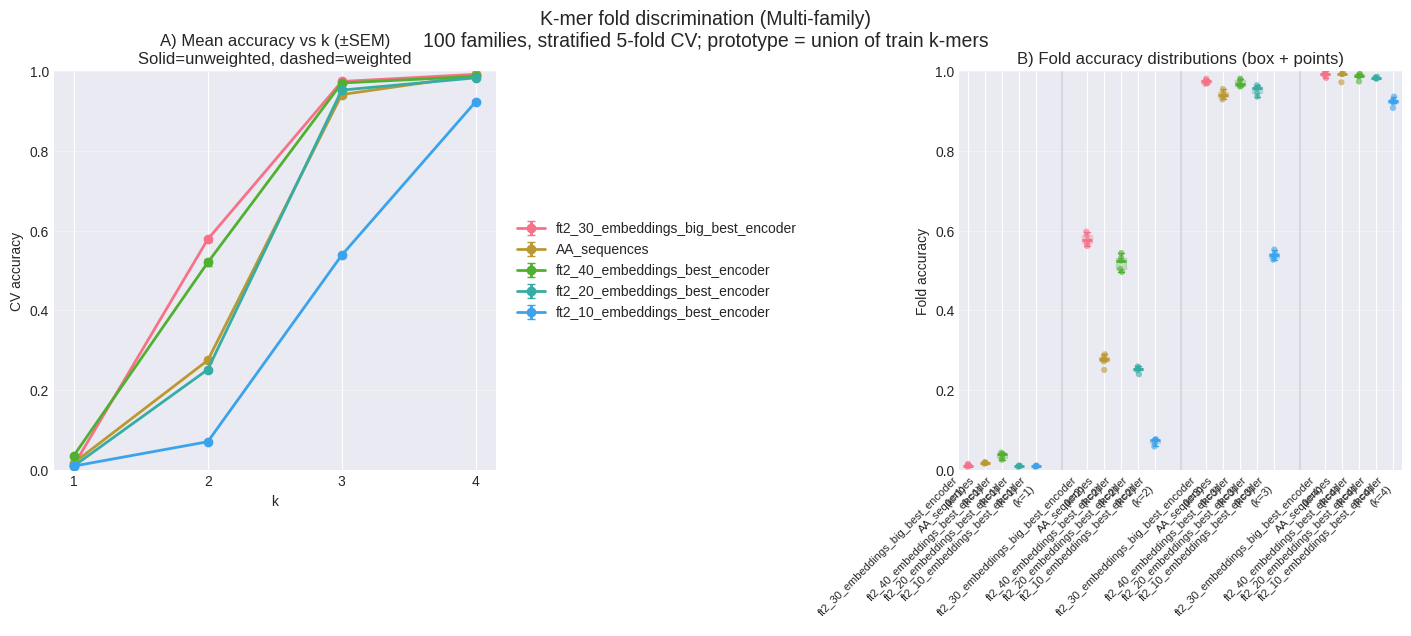

In [64]:
# 2x2 “hero figure” for k-mer fold discrimination
# - Panel A: mean±SEM vs k (solid=unweighted, dashed=weighted)
# - Panel B: fold distributions (box + jitter) faceted by k
# - Panel C: Δ (weighted - unweighted)
# - Panel D: heatmaps (mean accuracy), unweighted vs weighted
#
# Expects:
#   kmer_results         = family_results dict returned by run_kmer_fold_discrimination(... use_weighted=False)
#   kmer_results_weighted = family_results dict returned by run_kmer_fold_discrimination(... use_weighted=True)
#
# Notes:
# - Works with ~6–7 models cleanly.
# - Uses matplotlib; seaborn optional for nicer box/strip if installed.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
	import seaborn as sns
	_HAVE_SNS = True
except Exception:
	_HAVE_SNS = False


def _extract_long_df(res_dict, condition_label):
	"""Convert family_results['k_mer_discrimination'] to long-form DataFrame."""
	rows = []
	#km = res_dict.get("k_mer_discrimination", {})
	for model, kdict in res_dict.items():
		for k_label, stats in kdict.items():
			# k_label like 'k=1'
			k = int(k_label.split("=")[1])
			mean = float(stats.get("accuracy_mean", np.nan))
			sem = float(stats.get("accuracy_sem", np.nan))
			folds = stats.get("fold_accuracies", []) or []
			n_folds = int(stats.get("n_folds", len(folds) if folds else 0))
			n_fams = int(stats.get("n_families", np.nan))
			n_seq = int(stats.get("n_sequences", np.nan))
			# per-(model,k,condition) row
			rows.append({
				"model": model,
				"k": k,
				"condition": condition_label,
				"accuracy_mean": mean,
				"accuracy_sem": sem,
				"n_folds": n_folds,
				"n_families": n_fams,
				"n_sequences": n_seq,
				"fold_accuracies": folds,
			})
	df = pd.DataFrame(rows)
	print(f"Extracted DataFrame for condition '{condition_label}':")
	print(df.head())
	return df


def plot_kmer_discrimination_2x2(kmer_results_unweighted, kmer_results_weighted,
								title="K-mer fold discrimination (100 families, stratified CV)",
								sort_models_by="k4"):  # 'k4' or 'avg'
	# Build summary DF (one row per model/k/condition)
	df_u = _extract_long_df(kmer_results_unweighted, "unweighted")
	df_w = _extract_long_df(kmer_results_weighted, "weighted")
	df = pd.concat([df_u, df_w], ignore_index=True)

	# Expand folds into long DF for Panel B
	fold_rows = []
	for _, r in df.iterrows():
		for fi, acc in enumerate(r["fold_accuracies"]):
			fold_rows.append({
				"model": r["model"],
				"k": r["k"],
				"condition": r["condition"],
				"fold": fi,
				"accuracy": float(acc),
			})
	df_folds = pd.DataFrame(fold_rows)

	# Decide model order
	piv_u = df_u.pivot_table(index="model", columns="k", values="accuracy_mean", aggfunc="mean")
	if sort_models_by == "avg":
		model_order = list(piv_u.mean(axis=1).sort_values(ascending=False).index)
	else:
		# default: sort by k=4
		k4 = piv_u.get(4, pd.Series(index=piv_u.index, data=np.nan))
		model_order = list(k4.sort_values(ascending=False).index)

	# Ensure consistent model order in plots
	df["model"] = pd.Categorical(df["model"], categories=model_order, ordered=True)
	df_folds["model"] = pd.Categorical(df_folds["model"], categories=model_order, ordered=True)

	ks = sorted(df["k"].dropna().unique().tolist())
	if not ks:
		raise ValueError("No k values found in results dicts.")

	# Colors: let matplotlib cycle handle it; mapping per model for consistency
	# We'll build an explicit map so all panels match.
	base_colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
	if len(base_colors) < len(model_order):
		# extend by repeating if needed
		base_colors = (base_colors * (len(model_order) // max(1, len(base_colors)) + 1))[:len(model_order)]
	color_map = {m: base_colors[i] for i, m in enumerate(model_order)}

	# Figure layout
	fig = plt.figure(figsize=(14, 10), constrained_layout=True)
	gs = fig.add_gridspec(2, 2)

	axA = fig.add_subplot(gs[0, 0])
	axB = fig.add_subplot(gs[0, 1])

	# -------------------------
	# Panel A: mean±SEM vs k
	# -------------------------
	for model in model_order:
		sub_u = df[(df["model"] == model) & (df["condition"] == "unweighted")].sort_values("k")
		sub_w = df[(df["model"] == model) & (df["condition"] == "weighted")].sort_values("k")

		# Unweighted
		if len(sub_u):
			axA.errorbar(sub_u["k"], sub_u["accuracy_mean"], yerr=sub_u["accuracy_sem"],
						 label=f"{model}", color=color_map[model],
						 marker="o", linestyle="-", linewidth=2, capsize=3)

		# Weighted (dashed, no duplicate legend entries)
		if len(sub_w):
			axA.errorbar(sub_w["k"], sub_w["accuracy_mean"], yerr=sub_w["accuracy_sem"],
						 color=color_map[model],
						 marker="o", linestyle="--", linewidth=2, capsize=3, alpha=0.9)

	axA.set_title("A) Mean accuracy vs k (±SEM)\nSolid=unweighted, dashed=weighted")
	axA.set_xlabel("k")
	axA.set_ylabel("CV accuracy")
	axA.set_xticks(ks)
	axA.set_ylim(0, 1)
	axA.grid(True, axis="y", alpha=0.3)
	axA.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

	# -------------------------
	# Panel B: fold distributions (by k)
	# -------------------------
	# If seaborn is available, do box + strip, faceted by k in a compact way on one axis:
	# We'll manually “group” by k with offsets.
	axB.set_title("B) Fold accuracy distributions (box + points)")
	axB.set_ylabel("Fold accuracy")
	axB.set_ylim(0, 1)

	# Create grouped x positions: for each k, models laid out
	# x position = k_index*(n_models+gap) + model_index
	n_models = len(model_order)
	gap = 2
	xticks = []
	xticklabels = []
	for ki, k in enumerate(ks):
		base = ki * (n_models + gap)
		for mi, model in enumerate(model_order):
			x = base + mi
			xticks.append(x)
			xticklabels.append(f"{model}\n(k={k})")

			vals = df_folds[(df_folds["k"] == k) & (df_folds["model"] == model)]["accuracy"].values
			if len(vals) == 0:
				continue

			# Boxplot
			bp = axB.boxplot(vals, positions=[x], widths=0.6, patch_artist=True,
							 showfliers=False,
							 boxprops=dict(facecolor=color_map[model], alpha=0.25, edgecolor=color_map[model]),
							 medianprops=dict(color=color_map[model], linewidth=2),
							 whiskerprops=dict(color=color_map[model]),
							 capprops=dict(color=color_map[model]))

			# Jitter points
			rng = np.random.default_rng(0)
			jitter = rng.normal(0, 0.08, size=len(vals))
			axB.scatter(np.full_like(vals, x, dtype=float) + jitter, vals,
						s=20, color=color_map[model], alpha=0.6, edgecolors="none")

		# separator between k groups
		if ki < len(ks) - 1:
			sep_x = base + n_models - 0.5 + (gap / 2)
			axB.axvline(sep_x, color="k", alpha=0.08)

	axB.set_xticks(xticks)
	axB.set_xticklabels(xticklabels, fontsize=8 , rotation=45, ha="right")
	axB.grid(True, axis="y", alpha=0.3)

	# Overall title + footnote-style metadata (pull from df if present)
	# Use the first available (should be same across rows)
	meta = df.dropna(subset=["n_folds", "n_families"]).head(1)
	if len(meta):
		n_folds = int(meta["n_folds"].iloc[0])
		n_fams = int(meta["n_families"].iloc[0])
		fig.suptitle(f"{title}\n{n_fams} families, stratified {n_folds}-fold CV; prototype = union of train k-mers",
					 fontsize=14, y=1.02)
	else:
		fig.suptitle(title, fontsize=14, y=1.02)

	return fig


#select non shuffled results for unweighted and weighted
kmer_results = {model: res for model, res in family_results['k_mer_discrimination'].items() if not model.endswith("__shuf_within") and not model.endswith("__labelperm")}
kmer_results_random = {model: res for model, res in family_results['k_mer_discrimination'].items() if model.endswith("__shuf_within")}

# --- Example call ---
fig = plot_kmer_discrimination_2x2(kmer_results, kmer_results_random,
						  title="K-mer fold discrimination (Multi-family)")
plt.show()
# Optional: save
fig.savefig("kmer_fold_discrimination_2x2.png", dpi=300, bbox_inches="tight")


In [66]:
#save kmer_results to a dataframe and csv for later plotting
kmer_summary_rows = []
for model, kdict in kmer_results.items():
    for k_label, stats in kdict.items():
        k = int(k_label.split("=")[1])
        mean = float(stats.get("accuracy_mean", np.nan))
        sem = float(stats.get("accuracy_sem", np.nan))
        n_folds = int(stats.get("n_folds", 0))
        n_fams = int(stats.get("n_families", 0))
        n_seq = int(stats.get("n_sequences", 0))

        kmer_summary_rows.append({
            "model": model,
            "k": k,
            "accuracy_mean": mean,
            "accuracy_sem": sem,
            "n_folds": n_folds,
            "n_families": n_fams,
            "n_sequences": n_seq,
        })
kmer_summary_df = pd.DataFrame(kmer_summary_rows)
kmer_summary_df.to_csv(os.path.join(OUTPUT_DIR, "kmer_fold_discrimination_summary.csv"), index=False)
print("✓ K-mer fold discrimination summary saved to kmer_fold_disrimination_summary.csv")

✓ K-mer fold discrimination summary saved to kmer_fold_disrimination_summary.csv


In [75]:
# ==================== BENCHMARK 2: ENTROPY RATE ESTIMATION ====================
print("\n5. Entropy Rate Estimation (Markov Models)")
print("   Estimating entropy rates with different Markov orders...")

from collections import Counter
import numpy as np

# ----------------- helper: train counts up to max_order -----------------
def train_markov_counts(train_seqs, alphabet, char_position_map, max_order):
	counts0 = Counter()
	context_counts = [None] + [Counter() for _ in range(max_order)]  # 1..max_order
	trans_counts   = [None] + [Counter() for _ in range(max_order)]  # 1..max_order

	for seq in train_seqs:
		seq = [c for c in seq if c in char_position_map]
		if not seq:
			continue

		counts0.update(seq)

		for k in range(1, max_order + 1):
			if len(seq) <= k:
				continue
			for i in range(len(seq) - k):
				ctx = tuple(seq[i:i+k])
				nxt = seq[i+k]
				context_counts[k][ctx] += 1
				trans_counts[k][(ctx, nxt)] += 1

	return counts0, context_counts, trans_counts


# ----------------- helper: hierarchical Dirichlet backoff probability -----------------
def make_prob_fn(counts0, context_counts, trans_counts, alphabet, alpha0=0.5, alpha_backoff=5.0):
	A = len(alphabet)
	total0 = sum(counts0.values())
	denom0 = total0 + alpha0 * A
	p0 = {ch: (counts0.get(ch, 0) + alpha0) / denom0 for ch in alphabet}

	def p_sym(ctx_tuple, ch):
		k = len(ctx_tuple)
		if k == 0:
			return p0[ch]
		backoff_ctx = ctx_tuple[1:]
		p_back = p_sym(backoff_ctx, ch)
		ctx_total = context_counts[k].get(ctx_tuple, 0)
		trans = trans_counts[k].get((ctx_tuple, ch), 0)
		alpha = alpha_backoff
		return (trans + alpha * p_back) / (ctx_total + alpha)

	return p_sym


def bootstrap_ci(values, n_boot=2000, ci=0.95, seed=0):
	values = np.asarray(values, dtype=float)
	if len(values) == 0:
		return (np.nan, np.nan)
	rng = np.random.default_rng(seed)
	n = len(values)
	means = np.empty(n_boot, dtype=float)
	for b in range(n_boot):
		means[b] = np.mean(rng.choice(values, size=n, replace=True))
	alpha = (1.0 - ci) / 2.0
	return (float(np.quantile(means, alpha)), float(np.quantile(means, 1.0 - alpha)))


def mean_sem(values):
	values = np.asarray(values, dtype=float)
	n = len(values)
	if n == 0:
		return (np.nan, np.nan, 0)
	m = float(np.mean(values))
	if n == 1:
		return (m, 0.0, 1)
	s = float(np.std(values, ddof=1))
	return (m, s / np.sqrt(n), n)


# Hyperparameters
ALPHA0 = 0.5
ALPHA_BACKOFF = 5.0

total_results = {}

#select 10 families for this benchmark (to keep runtime reasonable)
unique_families = all_results_df['family'].unique()
n_families = min(10, len(unique_families))
rng = np.random.default_rng(42)
sampled_families = rng.choice(unique_families, size=n_families, replace=False)
print(f"Selected families for entropy benchmark: {sampled_families}")


# Continue using family_df from previous cell
for model_name in all_results_df['models'].unique():
	model_df = all_results_df[all_results_df['models'] == model_name]
	model_df = model_df[model_df['family'].isin(sampled_families)].reset_index(drop=True)
	if len(model_df) == 0:
		continue

	alphabet = sorted(list(model_alphabets[model_name]))
	char_position_map = {char: i for i, char in enumerate(alphabet)}

	print(f"   {model_name}:")

	orders = [0, 1, 2, 3, 4, 5]

	# Store per-order family-level means so we can compute Δk across families later
	# order -> {family -> family_mean_entropy}
	order_family_entropy = {o: {} for o in orders}
	order_family_effective = {o: {} for o in orders}  # effective order used per family (see below)

	for order in orders:
		print(f"      Markov order {order}...")

		family_entropy_means = []
		family_effective_means = []   # A) effective order used
		per_family_details = {}

		for family in model_df.family.unique():
			family_sequences = model_df[model_df['family'] == family]['seq'].tolist()

			n_folds = min(5, len(family_sequences))
			if n_folds < 2:
				continue
			fold_size = len(family_sequences) // n_folds
			if fold_size == 0:
				continue

			fold_entropies = []
			fold_effective = []  # per-fold effective usage

			for fold_idx in range(n_folds):
				test_start = fold_idx * fold_size
				test_end = test_start + fold_size if fold_idx < n_folds - 1 else len(family_sequences)

				train_seqs = family_sequences[:test_start] + family_sequences[test_end:]
				test_seqs = family_sequences[test_start:test_end]
				if not train_seqs or not test_seqs:
					continue

				counts0, context_counts, trans_counts = train_markov_counts(
					train_seqs=train_seqs,
					alphabet=alphabet,
					char_position_map=char_position_map,
					max_order=order
				)
				p_fn = make_prob_fn(
					counts0=counts0,
					context_counts=context_counts,
					trans_counts=trans_counts,
					alphabet=alphabet,
					alpha0=ALPHA0,
					alpha_backoff=ALPHA_BACKOFF
				)

				# Test entropy + A) effective order used
				test_entropy_sum = 0.0
				test_count = 0

				full_order_hits = 0
				full_order_total = 0

				for seq in test_seqs:
					seq = [c for c in seq if c in char_position_map]
					if len(seq) <= order:
						continue

					for i in range(order, len(seq)):
						ch = seq[i]
						ctx = tuple(seq[i - order:i]) if order > 0 else tuple()

						# A) "effective order used": fraction of positions where the full order-k context
						# was actually observed in training (i.e., would not require backing off).
						if order == 0:
							full_order_hits += 1
							full_order_total += 1
						else:
							full_order_total += 1
							if context_counts[order].get(ctx, 0) > 0:
								full_order_hits += 1

						prob = p_fn(ctx, ch)
						test_entropy_sum += -np.log2(prob)
						test_count += 1

				if test_count > 0:
					fold_entropies.append(test_entropy_sum / test_count)

				if full_order_total > 0:
					fold_effective.append(full_order_hits / full_order_total)

			if fold_entropies:
				fam_entropy = float(np.mean(fold_entropies))
				fam_effective = float(np.mean(fold_effective)) if fold_effective else (1.0 if order == 0 else np.nan)

				family_entropy_means.append(fam_entropy)
				family_effective_means.append(fam_effective)

				order_family_entropy[order][family] = fam_entropy
				order_family_effective[order][family] = fam_effective

				per_family_details[family] = {
					'fold_entropies': fold_entropies,
					'family_entropy_mean': fam_entropy,
					'fold_effective_order_used': fold_effective,
					'family_effective_order_used_mean': fam_effective,
					'n_folds_used': len(fold_entropies)
				}

		# Aggregate across families
		mean_entropy, sem_entropy, n_fam = mean_sem(family_entropy_means)
		mean_eff, sem_eff, _ = mean_sem(family_effective_means)
		ci_lo, ci_hi = bootstrap_ci(family_entropy_means, n_boot=2000, ci=0.95, seed=42)

		if n_fam and np.isfinite(mean_entropy):
			entropy_results[f'order_{order}'] = {
				'model_name': model_name,
				'order': order,
				'family_entropy_means': family_entropy_means,
				'family_effective_order_used_means': family_effective_means,
				'mean_entropy': mean_entropy,
				'sem_entropy': sem_entropy,
				'bootstrap_ci_95': (ci_lo, ci_hi),
				'mean_effective_order_used': mean_eff,
				'sem_effective_order_used': sem_eff,
				'n_families': n_fam,
				'per_family_details': per_family_details
			}

			print(
				f"         entropy_rate={mean_entropy:.3f} ± {sem_entropy:.3f} (SEM over {n_fam} families)"
				f" | 95% CI [{ci_lo:.3f}, {ci_hi:.3f}]"
				f" | effective_order_used={mean_eff:.3f} ± {sem_eff:.3f}"
			)
		else:
			entropy_results[f'order_{order}'] = {
				'model_name': model_name,
				'order': order,
				'mean_entropy': np.nan,
				'sem_entropy': np.nan,
				'bootstrap_ci_95': (np.nan, np.nan),
				'mean_effective_order_used': np.nan,
				'sem_effective_order_used': np.nan,
				'n_families': 0,
				'per_family_details': {}
			}

	# ----------------- B) Gain per order (Δk) across families with SEM -----------------
	# Δk is computed per-family using families present in BOTH orders (k-1) and k.
	gains = {}
	for k in orders[1:]:
		common_fams = set(order_family_entropy[k - 1].keys()) & set(order_family_entropy[k].keys())
		if not common_fams:
			gains[f'delta_{k}'] = {'mean': np.nan, 'sem': np.nan, 'n_families': 0, 'values': []}
			continue

		deltas = [order_family_entropy[k - 1][fam] - order_family_entropy[k][fam] for fam in common_fams]
		mean_d, sem_d, n_d = mean_sem(deltas)
		gains[f'delta_{k}'] = {'mean': mean_d, 'sem': sem_d, 'n_families': n_d, 'values': deltas}

	# Print gains summary (one line)
	gain_str = " | ".join([f"Δ{k}={gains[f'delta_{k}']['mean']:.3f}±{gains[f'delta_{k}']['sem']:.3f}"
						   for k in orders[1:] if np.isfinite(gains[f'delta_{k}']['mean'])])
	print(f"      Gains (bits/token): {gain_str}")

	entropy_results['gains_bits_per_token'] = gains
	family_results['entropy_rates'][model_name] = entropy_results
	
	total_results[model_name] = {
		'entropy_rates': entropy_results,
		'gains_bits_per_token': gains,
		'order_family_entropy': order_family_entropy,
		'order_family_effective': order_family_effective, 
		'mean_entropy': mean_entropy,
		'sem_entropy': sem_entropy,
		'bootstrap_ci_95': (ci_lo, ci_hi),
		'mean_effective_order_used': mean_eff,
		'sem_effective_order_used': sem_eff,
		'n_families': n_fam,
		'family': family
	}

print(total_results)


5. Entropy Rate Estimation (Markov Models)
   Estimating entropy rates with different Markov orders...
Selected families for entropy benchmark: [1392012  946355 1336183 1421179 1422622 1344626 1400686  866569 1301229
  909352]
   AA_sequences:
      Markov order 0...
         entropy_rate=4.106 ± 0.034 (SEM over 10 families) | 95% CI [4.036, 4.159] | effective_order_used=1.000 ± 0.000
      Markov order 1...
         entropy_rate=3.946 ± 0.061 (SEM over 10 families) | 95% CI [3.824, 4.060] | effective_order_used=1.000 ± 0.000
      Markov order 2...
         entropy_rate=3.611 ± 0.144 (SEM over 10 families) | 95% CI [3.346, 3.873] | effective_order_used=0.982 ± 0.005
      Markov order 3...
         entropy_rate=3.381 ± 0.169 (SEM over 10 families) | 95% CI [3.069, 3.700] | effective_order_used=0.703 ± 0.029
      Markov order 4...
         entropy_rate=3.302 ± 0.172 (SEM over 10 families) | 95% CI [2.989, 3.629] | effective_order_used=0.439 ± 0.038
      Markov order 5...
         en

In [81]:
#save all families to a dataframe and csv for later plotting
entropy_summary_rows = []
for model_name, res in total_results.items():
    for key, val in res['entropy_rates'].items():
        order = val.get('order', np.nan)
        mean_entropy = val.get('mean_entropy', np.nan)
        sem_entropy = val.get('sem_entropy', np.nan)
        n_families = val.get('n_families', 0)
        gain_info = res['gains_bits_per_token'].get(f'delta_{order}', {})
        gain_mean = gain_info.get('mean', np.nan)
        gain_sem = gain_info.get('sem', np.nan)
        bootstrap_ci = val.get('bootstrap_ci_95', (np.nan, np.nan))
        mean_effective_order_used = val.get('mean_effective_order_used', np.nan)
        sem_effective_order_used = val.get('sem_effective_order_used', np.nan)
        entropy_summary_rows.append({
            'model': model_name,
            'order': order,
            'mean_entropy': mean_entropy,
            'sem_entropy': sem_entropy,
            'n_families': n_families,
            'gain_mean': gain_mean,
            'gain_sem': gain_sem,
            'bootstrap_ci_95': bootstrap_ci,
            'mean_effective_order_used': mean_effective_order_used,
            'sem_effective_order_used': sem_effective_order_used
        })
entropy_summary_df = pd.DataFrame(entropy_summary_rows)
print(entropy_summary_df)
entropy_summary_df.to_csv(os.path.join(OUTPUT_DIR, "entropy_rate_estimation_summary.csv"), index=False)
print("✓ Entropy rate estimation summary saved to entropy_rate_estimation_summary.csv")

                                 model  order  mean_entropy  sem_entropy  \
0                         AA_sequences    0.0      3.198751     0.022117   
1                         AA_sequences    1.0      3.142799     0.033569   
2                         AA_sequences    2.0      3.021277     0.066835   
3                         AA_sequences    3.0      2.868000     0.107099   
4                         AA_sequences    4.0      2.765153     0.121740   
5                         AA_sequences    5.0      2.718031     0.123991   
6                         AA_sequences    NaN           NaN          NaN   
7   ft2_30_embeddings_big_best_encoder    0.0      3.198751     0.022117   
8   ft2_30_embeddings_big_best_encoder    1.0      3.142799     0.033569   
9   ft2_30_embeddings_big_best_encoder    2.0      3.021277     0.066835   
10  ft2_30_embeddings_big_best_encoder    3.0      2.868000     0.107099   
11  ft2_30_embeddings_big_best_encoder    4.0      2.765153     0.121740   
12  ft2_30_e

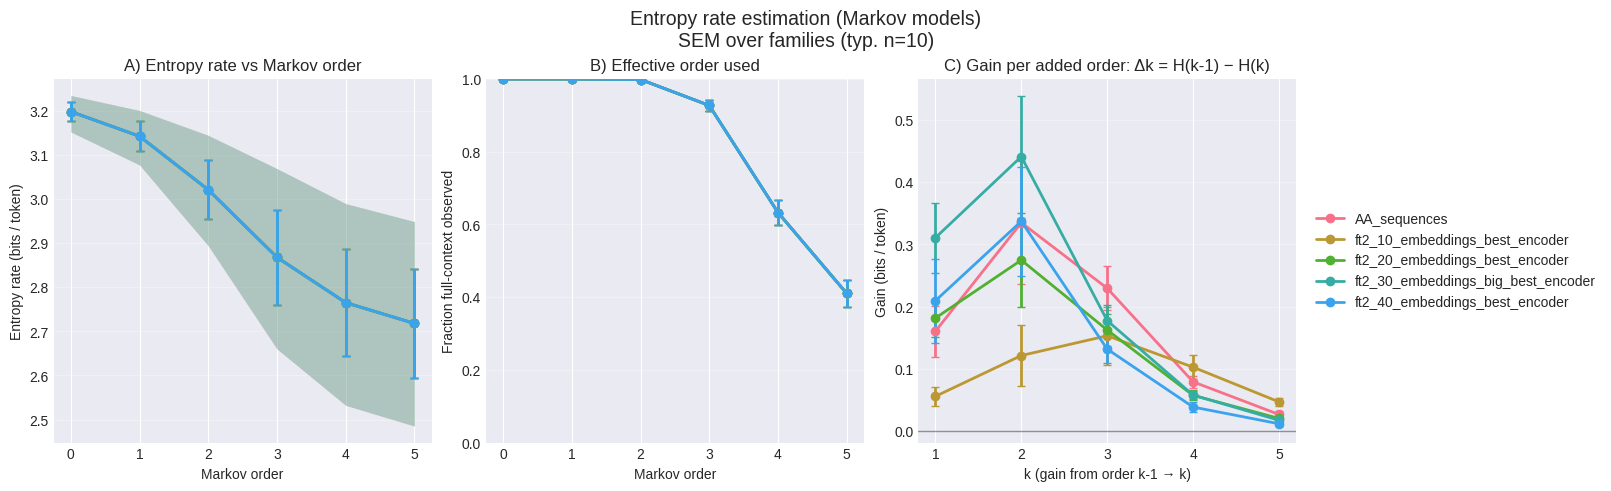

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_entropy_rate_benchmark_3panel_df(
    entropy_summary_df: pd.DataFrame,
    models=None,                 # list[str] or None = all
    title="Entropy rate estimation (Markov w/ Dirichlet backoff)",
    sort_models_by="order5",     # 'order5' or 'avg'
    show_bootstrap_ci=True,
    figsize=(16, 4.8),
):
    """
    1x3 figure (multiple alphabets/models overlaid on same axes):
      A) Entropy rate vs Markov order (mean ± SEM; optional shaded 95% bootstrap CI)
      B) Effective order used vs Markov order (mean ± SEM)
      C) Gains Δk = H(k-1) − H(k) (mean ± SEM)

    Expects entropy_summary_df columns:
      - model, order, mean_entropy, sem_entropy
      - mean_effective_order_used, sem_effective_order_used
      - gain_mean, gain_sem
      - bootstrap_ci_95 (tuple/list of (lo, hi))  [optional shading in A]
      - n_families (optional for subtitle)
    """

    df = entropy_summary_df.copy()

    required = {
        "model", "order",
        "mean_entropy", "sem_entropy",
        "mean_effective_order_used", "sem_effective_order_used",
        "gain_mean", "gain_sem",
    }
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"entropy_summary_df is missing columns: {missing}")

    # Parse / clean
    df = df[np.isfinite(df["order"])].copy()
    df["order"] = df["order"].astype(int)

    # Split bootstrap CI tuple into lo/hi (robust to strings or lists)
    if "bootstrap_ci_95" in df.columns:
        def _ci_lo(x):
            try:
                return float(x[0])
            except Exception:
                return np.nan
        def _ci_hi(x):
            try:
                return float(x[1])
            except Exception:
                return np.nan
        df["ci_lo"] = df["bootstrap_ci_95"].apply(_ci_lo)
        df["ci_hi"] = df["bootstrap_ci_95"].apply(_ci_hi)
    else:
        df["ci_lo"] = np.nan
        df["ci_hi"] = np.nan
        show_bootstrap_ci = False

    if models is not None:
        models = list(models)
        df = df[df["model"].isin(models)].copy()

    if df.empty:
        raise ValueError("No rows left after filtering; check model names / dataframe content.")

    # Orders present
    orders = sorted(df["order"].unique().tolist())
    gain_orders = sorted([o for o in orders if o >= 1])

    # Model ordering (lower entropy at high order = more predictable)
    piv = df.pivot_table(index="model", columns="order", values="mean_entropy", aggfunc="mean")
    if sort_models_by == "avg":
        model_order = list(piv.mean(axis=1).sort_values(ascending=True).index)
    else:
        col = 5 if 5 in piv.columns else orders[-1]
        model_order = list(piv[col].sort_values(ascending=True).index)

    # Consistent colors
    base_colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
    if len(base_colors) < len(model_order):
        base_colors = (base_colors * (len(model_order) // max(1, len(base_colors)) + 1))[:len(model_order)]
    color_map = {m: base_colors[i] for i, m in enumerate(model_order)}

    fig, (axA, axB, axC) = plt.subplots(1, 3, figsize=figsize, constrained_layout=True)

    # -------------------------
    # Panel A: Entropy vs order
    # -------------------------
    for m in model_order:
        sub = df[df["model"] == m].sort_values("order")
        x = sub["order"].to_numpy()
        y = sub["mean_entropy"].to_numpy()
        yerr = sub["sem_entropy"].to_numpy()

        axA.errorbar(x, y, yerr=yerr, marker="o", linestyle="-",
                     linewidth=2, capsize=3, color=color_map[m], label=m)

        if show_bootstrap_ci:
            lo = sub["ci_lo"].to_numpy()
            hi = sub["ci_hi"].to_numpy()
            mask = np.isfinite(lo) & np.isfinite(hi)
            if np.any(mask):
                axA.fill_between(x[mask], lo[mask], hi[mask],
                                 color=color_map[m], alpha=0.12, linewidth=0)

    axA.set_title("A) Entropy rate vs Markov order")
    axA.set_xlabel("Markov order")
    axA.set_ylabel("Entropy rate (bits / token)")
    axA.set_xticks(orders)
    axA.grid(True, axis="y", alpha=0.3)

    # -------------------------
    # Panel B: Effective order used
    # -------------------------
    for m in model_order:
        sub = df[df["model"] == m].sort_values("order")
        x = sub["order"].to_numpy()
        y = sub["mean_effective_order_used"].to_numpy()
        yerr = sub["sem_effective_order_used"].to_numpy()

        axB.errorbar(x, y, yerr=yerr, marker="o", linestyle="-",
                     linewidth=2, capsize=3, color=color_map[m])

    axB.set_title("B) Effective order used")
    axB.set_xlabel("Markov order")
    axB.set_ylabel("Fraction full-context observed")
    axB.set_xticks(orders)
    axB.set_ylim(0, 1)
    axB.grid(True, axis="y", alpha=0.3)

    # -------------------------
    # Panel C: Gains Δk
    # -------------------------
    for m in model_order:
        sub = df[df["model"] == m].sort_values("order")
        # keep only finite gains and k>=1
        sub = sub[sub["order"] >= 1].copy()
        mask = np.isfinite(sub["gain_mean"].to_numpy())
        x = sub["order"].to_numpy()[mask]
        y = sub["gain_mean"].to_numpy()[mask]
        yerr = sub["gain_sem"].to_numpy()[mask]
        if len(x) == 0:
            continue

        axC.errorbar(x, y, yerr=yerr, marker="o", linestyle="-",
                     linewidth=2, capsize=3, color=color_map[m])

    axC.axhline(0, color="k", linewidth=1, alpha=0.4)
    axC.set_title("C) Gain per added order: Δk = H(k-1) − H(k)")
    axC.set_xlabel("k (gain from order k-1 → k)")
    axC.set_ylabel("Gain (bits / token)")
    axC.set_xticks(gain_orders)
    axC.grid(True, axis="y", alpha=0.3)

    # Legend once, outside (keeps panels clean)
    axC.legend(handles=[
        plt.Line2D([0], [0], color=color_map[m], marker="o", linestyle="-", linewidth=2, label=m)
        for m in model_order
    ], loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    # -------------------------
    # Global title / metadata
    # -------------------------
    n_fam = None
    if "n_families" in df.columns and df["n_families"].notna().any():
        n_fam = int(df["n_families"].max())

    subtitle = []
    if n_fam is not None:
        subtitle.append(f"SEM over families (typ. n={n_fam})")
    #if show_bootstrap_ci:
    #    subtitle.append("shaded=95% bootstrap CI (over families)")
    subline = " | ".join(subtitle)

    fig.suptitle(f"{title}\n{subline}" if subline else title, fontsize=14)

    return fig


# Example:
fig = plot_entropy_rate_benchmark_3panel_df(entropy_summary_df,
                                            title="Entropy rate estimation (Markov models)",
                                            show_bootstrap_ci=True)
plt.show()
fig.savefig("entropy_rate_estimation_3panel.png", dpi=300, bbox_inches="tight")

In [92]:
cd /home/dmoi/projects/foldtree2/foldtree2/

/home/dmoi/projects/foldtree2/foldtree2


In [ ]:
# ==================== CREATE ALIGNMENTS USING FT2TREEBUILDER ====================
print("\n5. Creating Alignments with FoldTree2 TreeBuilder")
print("   Generating MAFFT alignments for each family and model...")

from foldtree2 import ft2treebuilder
import tempfile
import os

# Create output directory for alignments
alignment_dir = os.path.join(OUTPUT_DIR, 'alignments')
os.makedirs(alignment_dir, exist_ok=True)

create_alignments = True  # Set to False to skip alignment creation if already done

if not create_alignments:
	print("   Skipping alignment creation (create_alignments=False). If you want to create alignments, set create_alignments=True.")
else:
	# Store alignment paths for later use
	alignment_paths = {}

	for family_name in all_results_df['family'].unique():
		print(f"\n   Family: {family_name}")
		family_df = all_results_df[all_results_df['family'] == family_name]
		
		alignment_paths[family_name] = {}
		
		# Process each model (excluding AA_sequences which doesn't need ft2treebuilder)
		for model_name in family_df['models'].unique():
			if model_name == 'AA_sequences':
				# For AA sequences, just create a simple FASTA file
				model_df = family_df[family_df['models'] == model_name]
				aa_fasta_path = os.path.join(alignment_dir, f'{family_name}_AA_sequences.fasta')
				
				with open(aa_fasta_path, 'w') as f:
					for idx, row in model_df.iterrows():
						f.write(f">{row['id']}\n{row['seq']}\n")
				
				# Use standard MAFFT for AA sequences
				aa_aln_path = os.path.join(alignment_dir, f'{family_name}_AA_sequences_aligned.fasta')
				import subprocess
				subprocess.run(f"mafft --auto {aa_fasta_path} > {aa_aln_path}", 
							shell=True, capture_output=True)
				
				alignment_paths[family_name][model_name] = aa_aln_path
				print(f"      {model_name}: AA alignment created ({len(model_df)} sequences)")
				from IPython.display import clear_output
				clear_output(wait=True)
				continue
			

			# For FoldTree2 models, we need the encoder and matrices
			model_df = family_df[family_df['models'] == model_name]
			#check of alnignment already exists for this family/model (from previous runs)
			expected_aln_path = os.path.join(alignment_dir, f'{family_name}_{model_name}_aligned.fasta')
			if os.path.exists(expected_aln_path):
				alignment_paths[family_name][model_name] = expected_aln_path
				print(f"      {model_name}: Alignment already exists, skipping ({len(model_df)} sequences)")
				continue
			
			# Extract embedding size from model name
			embedding_size = model_df['alphabet_sizes'].iloc[0]
			
			# Find the model path

			model_base_path = os.path.join('/home/dmoi/projects/foldtree2/models/embedding_comparison/final/', f'ft2_{embedding_size}_embeddings_best')
			encoder_path = model_base_path + '_encoder'
			
			if not os.path.exists(encoder_path + '.pt'):
				model_base_path = os.path.join('/home/dmoi/projects/foldtree2/models/embedding_comparison/final/', f'ft2_{embedding_size}_embeddings_big_best')
				encoder_path = model_base_path + '_encoder'

			
			# Check if model files exist
			if not os.path.exists(encoder_path + '.pt'):
				print(f"      {model_name}: Model not found at {encoder_path}.pt, skipping")
				continue
			
			# Create temporary FASTA with encoded sequences
			temp_fasta = os.path.join(alignment_dir, f'{family_name}_{model_name}_encoded.fasta')
			
			with open(temp_fasta, 'w') as f:
				for idx, row in model_df.iterrows():
					f.write(f">{row['id']}\n{row['seq']}\n")
			
			# Load the treebuilder for this model
			# Note: ft2treebuilder expects substitution matrix and MAFFT matrix files
			# These should have been created during model training
			mafftmat_path = encoder_path + '_mafftmat.mtx'
			submat_path = encoder_path + '_submat.txt'
			charmaps_path = encoder_path + '_pair_counts.pkl'
			print(f"      {model_name}: Checking for matrix files..." , mafftmat_path, submat_path, charmaps_path)
			# Check if matrix files exist
			if os.path.exists(mafftmat_path) and os.path.exists(charmaps_path):
				try:
					# Initialize treebuilder
					tb = ft2treebuilder.treebuilder(
						model=encoder_path+'.pt',
						decoder_model=None,  # We only need alignment, not tree
						mafftmat=mafftmat_path,
						submat=submat_path,
						charmaps=charmaps_path,
						raxml_path='raxml-ng',
						aapropcsv='/home/dmoi/projects/foldtree2/foldtree2/config/aaindex1.csv'
					)
					
					# Convert encoded FASTA to hex for MAFFT
					hex_path = tb.encodedfasta2hex(temp_fasta)
					
					# Convert to ASCII for MAFFT
					ascii_path = tb.mafft_hex2ascii(hex_path, outfile=None)
					
					# Run MAFFT alignment
					aln_path = tb.run_mafft_textaln(ascii_path, matrix=mafftmat_path)
					
					# Convert back to readable format
					aln_hex_path = tb.fasta2hex(aln_path, outfile=None)
					final_aln_path = tb.read_textaln(
						aln_hex_path,
						outfile=os.path.join(alignment_dir, 
											f'{family_name}_{model_name}_aligned.fasta')
					)
					
					alignment_paths[family_name][model_name] = final_aln_path
					print(f"      {model_name}: Alignment created ({len(model_df)} sequences)")
					
				except Exception as e:
					print(f"      {model_name}: Error creating alignment - {str(e)}")
					alignment_paths[family_name][model_name] = None
				
			else:
				print(f"      {model_name}: Matrix files not found, using simple MAFFT")
				# Fallback to regular MAFFT with --anysymbol
				simple_aln_path = os.path.join(alignment_dir, 
											f'{family_name}_{model_name}_aligned.fasta')
				subprocess.run(f"mafft --anysymbol --auto {temp_fasta} > {simple_aln_path}",
							shell=True, capture_output=True)
				alignment_paths[family_name][model_name] = simple_aln_path
				print(f"      {model_name}: Simple alignment created ({len(model_df)} sequences)")
			
			#clear output from ipython to avoid clutter
			from IPython.display import clear_output
			clear_output(wait=True)

	print(f"\n   Alignments saved to: {alignment_dir}")
	print(f"   Total families processed: {len(alignment_paths)}")


   Family: 1372175


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

AA_STATES = list("ACDEFGHIKLMNPQRSTVWY")

def collect_windows_by_token(pairs, tokens=None, w=8):
	"""
	pairs: iterable of (ft2_seq, aa_seq) with positional correspondence (ungapped).
	tokens: optional set/list of FT2 tokens to consider. If None, infer from data.
	w: half-window size. window length = 2w+1.
	Returns: dict token -> list of AA windows (strings of len 2w+1).
	"""
	windows = defaultdict(list)
	seen_tokens = set()

	for ft2, aa in pairs:
		L = min(len(ft2), len(aa))
		if L <= 2*w:
			continue
		ft2 = ft2[:L]
		aa  = aa[:L]

		for i in range(w, L - w):
			x = ft2[i]
			if tokens is not None and x not in tokens:
				continue
			# keep only if center AA is valid (optional; you can relax this)
			win = aa[i-w:i+w+1]
			# filter windows containing non-AA (optional)
			if any(c not in AA_STATES for c in win):
				continue
			windows[x].append(win)
			seen_tokens.add(x)

	if tokens is None:
		tokens = sorted(seen_tokens)
	return windows, tokens

def pwm_from_windows(windows, alphabet=AA_STATES, pseudocount=1.0):
	"""
	windows: list of equal-length strings
	Returns: pandas.DataFrame (rows=positions, cols=alphabet) of probabilities.
	"""
	if len(windows) == 0:
		return None
	Lw = len(windows[0])
	counts = np.full((Lw, len(alphabet)), pseudocount, dtype=float)
	a2i = {a:i for i,a in enumerate(alphabet)}

	for win in windows:
		for pos, a in enumerate(win):
			if a in a2i:
				counts[pos, a2i[a]] += 1.0

	probs = counts / counts.sum(axis=1, keepdims=True)
	return pd.DataFrame(probs, columns=alphabet)

def info_logo_heights(pwm_df, background=None):
	"""
	Convert PWM probabilities to sequence-logo 'heights' in bits:
	  R(pos) = log2(|A|) - H(pos)
	  height(a,pos) = p(a,pos) * R(pos)
	background: optional background distribution over AAs (Series or dict).
				If None, assumes uniform.
	"""
	A = pwm_df.shape[1]
	p = pwm_df.values

	# optional KL-to-background variant:
	if background is not None:
		bg = np.array([background[a] for a in pwm_df.columns], dtype=float)
		bg = bg / bg.sum()
		# per-position information as KL(p||bg)
		# I(pos)=sum_a p(a)*log2(p(a)/bg(a))
		with np.errstate(divide="ignore", invalid="ignore"):
			ratio = np.where(p > 0, p / bg[None, :], 1.0)
			I = np.nansum(np.where(p > 0, p * np.log2(ratio), 0.0), axis=1)
		heights = p * I[:, None]
	else:
		# classic Schneider-Stephens info content w.r.t uniform
		with np.errstate(divide="ignore", invalid="ignore"):
			H = -np.nansum(np.where(p > 0, p * np.log2(p), 0.0), axis=1)
		R = np.log2(A) - H
		heights = p * R[:, None]

	return pd.DataFrame(heights, columns=pwm_df.columns)

def plot_logo_matplotlib(ax, heights_df, x_labels=None):
	"""
	Simple matplotlib logo (no external deps).
	Draws stacked letters with heights from heights_df (rows=positions, cols=AA).
	"""
	import matplotlib.transforms as mtransforms

	letters = list(heights_df.columns)
	npos = heights_df.shape[0]
	ax.set_xlim(-0.5, npos - 0.5)
	ax.set_ylim(0, max(0.1, float(heights_df.sum(axis=1).max()) * 1.05))

	# basic color scheme (optional); feel free to customize
	aa_colors = {
		**{a:"#1f77b4" for a in "STNQCY"},   # polar-ish
		**{a:"#d62728" for a in "KRH"},      # basic
		**{a:"#2ca02c" for a in "DE"},       # acidic
		**{a:"#ff7f0e" for a in "AILMFWVPG"},# hydrophobic-ish
	}

	for i in range(npos):
		col = heights_df.iloc[i]
		# stack smallest to largest for readability
		items = [(a, col[a]) for a in letters if col[a] > 1e-6]
		items.sort(key=lambda t: t[1])
		y0 = 0.0
		for a, h in items:
			# place letter as text scaled vertically by height
			# (this is a common lightweight trick; not as pretty as logomaker but works)
			t = ax.text(i, y0, a, ha="center", va="bottom",
						fontsize=16, color=aa_colors.get(a, "black"),
						family="DejaVu Sans", fontweight="bold")
			# scale text in y-direction to match height
			trans = (mtransforms.Affine2D()
					 .scale(1.0, h / 0.5)  # 0.5 is a rough baseline letter height
					 + ax.transData)
			t.set_transform(trans)
			y0 += h

	ax.set_xticks(range(npos))
	if x_labels is None:
		x_labels = [str(i - npos//2) for i in range(npos)]
	ax.set_xticklabels(x_labels, fontsize=8)
	ax.tick_params(axis="y", labelsize=8)
	ax.spines["top"].set_visible(False)
	ax.spines["right"].set_visible(False)

def plot_token_motif_grid(pairs, tokens=None, w=8, pseudocount=1.0,
						  background=None, max_tokens=None, ncols=6,
						  use_logomaker_if_available=True):
	"""
	pairs: iterable of (ft2_seq, aa_seq)
	background: optional dict/Series over AA for KL-logo; else uniform info logo
	"""
	windows, token_list = collect_windows_by_token(pairs, tokens=tokens, w=w)

	# optionally restrict to tokens with most support
	token_counts = [(t, len(windows.get(t, []))) for t in token_list]
	token_counts.sort(key=lambda x: x[1], reverse=True)
	if max_tokens is not None:
		token_counts = token_counts[:max_tokens]
	token_list = [t for t, _ in token_counts]

	n = len(token_list)
	ncols = min(ncols, max(1, n))
	nrows = int(np.ceil(n / ncols))

	fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.2*nrows), squeeze=False)
	axes = axes.ravel()

	# try logomaker if present
	have_logomaker = False
	if use_logomaker_if_available:
		try:
			import logomaker
			have_logomaker = True
		except Exception:
			have_logomaker = False

	x_labels = [str(i - w) for i in range(2*w + 1)]

	for idx, t in enumerate(token_list):
		ax = axes[idx]
		wins = windows.get(t, [])
		ax.set_title(f"FT2 token '{t}'  (n={len(wins)})", fontsize=10)

		if len(wins) < 10:
			ax.text(0.5, 0.5, "too few hits", ha="center", va="center", transform=ax.transAxes)
			ax.axis("off")
			continue

		pwm = pwm_from_windows(wins, alphabet=AA_STATES, pseudocount=pseudocount)
		heights = info_logo_heights(pwm, background=background)

		if have_logomaker:
			import logomaker
			# logomaker expects heights with index=positions
			hh = heights.copy()
			hh.index = range(len(hh))
			logomaker.Logo(hh, ax=ax)
			ax.set_xticks(range(len(x_labels)))
			ax.set_xticklabels(x_labels, fontsize=8)
			ax.set_ylabel("bits", fontsize=8)
			ax.tick_params(axis="y", labelsize=8)
		else:
			plot_logo_matplotlib(ax, heights, x_labels=x_labels)
			ax.set_ylabel("bits", fontsize=8)

	# turn off unused axes
	for j in range(len(token_list), len(axes)):
		axes[j].axis("off")

	fig.suptitle(f"AA sequence motifs conditioned on FoldTree2 token (window ±{w})", y=1.02, fontsize=14)
	fig.tight_layout()
	return fig

# --------------------
# Example: build `pairs` from your dataframes
# --------------------
# Suppose you have:
#   aa_df  with columns ['id','seq'] where models == 'AA_sequences'
#   ft2_df with columns ['id','seq'] for one FT2 model (or loop across models)
#
# aa_map = dict(zip(aa_df['id'], aa_df['seq']))
# pairs = []
# for _, r in ft2_df.iterrows():
#     sid = r['id']
#     if sid in aa_map:
#         pairs.append((r['seq'], aa_map[sid]))
#
# fig = plot_token_motif_grid(pairs, w=8, ncols=6, max_tokens=48)
# plt.show()


In [ ]:
# ==================== BENCHMARK 3: PER-POSITION ENTROPY ====================
print("\n6. Per-Position Entropy from MSA")
print("   Calculating positional entropy with Henikoff weighting (additive) + column diagnostics...")

from Bio import AlignIO
import numpy as np
import os

GAP_CHAR = '-'
GAP_OCC_MAX = 0.30   # skip columns with >30% gaps
UNK_CHAR = None      # set to e.g. 'X' if you want to collapse unknowns instead of skipping them

def compute_henikoff_weights(msa: np.ndarray, valid_symbols: set, gap_char: str = '-') -> np.ndarray:
	"""
	Henikoff & Henikoff (1994) position-based weights (additive across columns):
	  w_i = sum_j 1 / (r_j * n_{a(i,j),j}) for non-gap, valid symbols.
	Then normalized to sum to 1.

	msa: shape (n_seqs, L), dtype=str
	valid_symbols: allowed symbols for this representation (excluding gap)
	"""
	n_seqs, L = msa.shape
	w = np.zeros(n_seqs, dtype=float)

	for j in range(L):
		col = msa[:, j]

		# consider only non-gap & valid symbols for r_j / counts
		mask_valid = (col != gap_char) & np.isin(col, list(valid_symbols))
		if not np.any(mask_valid):
			continue

		col_valid = col[mask_valid]
		syms, counts = np.unique(col_valid, return_counts=True)
		r_j = len(syms)
		if r_j == 0:
			continue

		count_map = dict(zip(syms, counts))

		# add contributions to sequences that have a valid symbol here
		for sym in syms:
			sym_mask = (col == sym)
			n_a = count_map.get(sym, 0)
			if n_a > 0:
				w[sym_mask] += 1.0 / (r_j * n_a)

	# normalize
	if w.sum() > 0:
		w = w / w.sum()
	else:
		w = np.ones(n_seqs, dtype=float) / n_seqs
	return w

def weighted_column_entropy(col: np.ndarray, weights: np.ndarray, alphabet: list, gap_char: str = '-') -> float:
	"""
	Weighted Shannon entropy over the provided alphabet only (gap excluded).
	Assumes weights sum to 1.
	"""
	H = 0.0
	for sym in alphabet:
		p = weights[col == sym].sum()
		if p > 0:
			H -= p * np.log2(p)
	return float(H)

# Process each family
for family_name in all_results_df['family'].unique():
	print(f"\n   Family: {family_name}")
	fam_df = all_results_df[all_results_df['family'] == family_name]

	# Process each model
	for model_name in fam_df['models'].unique():
		model_df = fam_df[fam_df['models'] == model_name]
		if len(model_df) == 0:
			continue

		# alignment path
		if family_name not in alignment_paths or model_name not in alignment_paths[family_name]:
			print(f"      {model_name}: No alignment found, skipping")
			continue

		aln_path = alignment_paths[family_name][model_name]
		if aln_path is None or not os.path.exists(aln_path):
			print(f"      {model_name}: Alignment file not found, skipping")
			continue

		try:
			alignment = AlignIO.read(aln_path, "fasta")
			n_seqs = len(alignment)
			seq_len = alignment.get_alignment_length()

			# Alphabet for this representation (exclude gap)
			alphabet = sorted(list(model_alphabets[model_name]))
			valid_symbols = set(alphabet)

			print(f"      {model_name}:")

			# Convert alignment to numpy array
			msa = np.array([list(str(record.seq)) for record in alignment], dtype=str)

			# Basic gap diagnostics
			gap_fracs = (msa == GAP_CHAR).mean(axis=0)
			mean_gap = float(gap_fracs.mean())
			kept_cols = gap_fracs <= GAP_OCC_MAX
			frac_kept = float(kept_cols.mean())

			# OPTIONAL: handle unknown symbols (outside alphabet and not gap)
			# Minimal approach: ignore them in weights and entropy. (We do that via valid_symbols mask.)
			# If you'd rather collapse to a dedicated UNK_CHAR, set UNK_CHAR and include it in alphabet/valid_symbols.
			if UNK_CHAR is not None and UNK_CHAR not in valid_symbols:
				alphabet = alphabet + [UNK_CHAR]
				valid_symbols.add(UNK_CHAR)
				# map unknown (non-gap) to UNK
				unknown_mask = (msa != GAP_CHAR) & (~np.isin(msa, list(valid_symbols)))
				msa[unknown_mask] = UNK_CHAR

			# Compute Henikoff weights (additive)
			weights = compute_henikoff_weights(msa, valid_symbols=valid_symbols, gap_char=GAP_CHAR)

			# Per-position entropy over kept columns
			position_entropies = []
			position_neff = []

			for j in range(seq_len):
				if gap_fracs[j] > GAP_OCC_MAX:
					continue

				col = msa[:, j]

				# compute weighted entropy over alphabet (gap excluded by construction)
				H = weighted_column_entropy(col, weights, alphabet, gap_char=GAP_CHAR)
				position_entropies.append(H)
				position_neff.append(2 ** H)  # effective number of symbols

			if position_entropies:
				avg_entropy = float(np.mean(position_entropies))
				std_entropy = float(np.std(position_entropies))
				max_entropy = float(np.max(position_entropies))
				min_entropy = float(np.min(position_entropies))

				avg_neff = float(np.mean(position_neff))
				std_neff = float(np.std(position_neff))

				# Store results
				if family_name not in family_results:
					family_results[family_name] = {}
				if 'per_position_entropy' not in family_results[family_name]:
					family_results[family_name]['per_position_entropy'] = {}

				family_results[family_name]['per_position_entropy'][model_name] = {
					'mean_entropy': avg_entropy,
					'std_entropy': std_entropy,
					'max_entropy': max_entropy,
					'min_entropy': min_entropy,
					'mean_neff': avg_neff,
					'std_neff': std_neff,
					'n_positions_used': int(len(position_entropies)),
					'frac_positions_used': float(len(position_entropies) / seq_len) if seq_len > 0 else 0.0,
					'position_entropies': position_entropies,
					'position_neff': position_neff,
					'n_sequences': int(n_seqs),
					'alignment_length': int(seq_len),
					'gap_occ_max': float(GAP_OCC_MAX),
					'mean_gap_frac': mean_gap,
					'frac_cols_kept_by_gap': frac_kept
				}

				print(f"         mean_entropy={avg_entropy:.3f} ± {std_entropy:.3f}")
				print(f"         range=[{min_entropy:.3f}, {max_entropy:.3f}], n_positions={len(position_entropies)}/{seq_len} (kept={frac_kept:.3f})")
				print(f"         mean_Neff={avg_neff:.2f} ± {std_neff:.2f} | mean_gap_frac={mean_gap:.3f} | n_sequences={n_seqs}")
			else:
				print(f"         No valid positions (all positions have >{int(GAP_OCC_MAX*100)}% gaps or no valid symbols)")

		except Exception as e:
			print(f"      {model_name}: Error processing alignment - {str(e)}")
			continue

print("\n   Per-position entropy calculation complete!")



6. Per-Position Entropy from MSA
   Calculating positional entropy with Henikoff weighting...

   Family: 1067473
      AA_sequences:
         mean_entropy=1.894 ± 0.760
         range=[0.000, 3.379], n_positions=673
         n_sequences=14, alignment_length=997
      ft2_10_embeddings_best_encoder: Error processing alignment - No records found in handle
      ft2_20_embeddings_best_encoder: Error processing alignment - No records found in handle
      ft2_30_embeddings_best_encoder: Error processing alignment - No records found in handle
      ft2_40_embeddings_best_encoder: Error processing alignment - No records found in handle

   Family: 806905
      AA_sequences: No alignment found, skipping
      ft2_10_embeddings_best_encoder: No alignment found, skipping
      ft2_20_embeddings_best_encoder: No alignment found, skipping
      ft2_30_embeddings_best_encoder: No alignment found, skipping
      ft2_40_embeddings_best_encoder: No alignment found, skipping

   Family: 948912
     

In [ ]:
# Figure for Benchmark 3: Per-position entropy from MSA (Henikoff weighting + gap diagnostics)
#
# Goal: Compare models across families on:
#   A) Mean per-position entropy (bits) with gap-kept fraction as a diagnostic
#   B) Mean Neff (=2^H) with the same diagnostic
#   C) Distribution of per-position entropies pooled across families (or per-family small multiples)
#   D) Gap diagnostics: mean gap fraction vs fraction columns kept
#
# Expects results stored exactly as:
#   family_results[family_name]['per_position_entropy'][model_name] = {...}
#
# Usage:
#   fig = plot_per_position_entropy_benchmark(family_results, title="Per-position entropy (Henikoff-weighted)")
#   plt.show()
#   fig.savefig("per_position_entropy_benchmark.png", dpi=300, bbox_inches="tight")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
	import seaborn as sns
	_HAVE_SNS = True
except Exception:
	_HAVE_SNS = False


def _extract_perpos_entropy_long(family_results):
	"""Return (df_summary, df_pos) where df_pos has per-position entropies."""
	sum_rows = []
	pos_rows = []

	for fam, famd in family_results.items():
		if not isinstance(famd, dict):
			continue
		ppe = famd.get("per_position_entropy", {})
		if not isinstance(ppe, dict) or len(ppe) == 0:
			continue

		for model, d in ppe.items():
			# summary
			sum_rows.append({
				"family": fam,
				"model": model,
				"mean_entropy": float(d.get("mean_entropy", np.nan)),
				"std_entropy": float(d.get("std_entropy", np.nan)),
				"mean_neff": float(d.get("mean_neff", np.nan)),
				"std_neff": float(d.get("std_neff", np.nan)),
				"n_positions_used": int(d.get("n_positions_used", 0)),
				"frac_positions_used": float(d.get("frac_positions_used", np.nan)),
				"alignment_length": int(d.get("alignment_length", 0)),
				"n_sequences": int(d.get("n_sequences", 0)),
				"gap_occ_max": float(d.get("gap_occ_max", np.nan)),
				"mean_gap_frac": float(d.get("mean_gap_frac", np.nan)),
				"frac_cols_kept_by_gap": float(d.get("frac_cols_kept_by_gap", np.nan)),
			})

			# per-position entropies (pooled)
			ent = d.get("position_entropies", []) or []
			neff = d.get("position_neff", []) or []
			# store entropy distribution; index is positional rank among kept cols (not absolute col id)
			for i, v in enumerate(ent):
				pos_rows.append({
					"family": fam,
					"model": model,
					"pos_idx": i,
					"entropy": float(v),
				})
			# (Optional) also store neff per position if you want a second distribution plot
			# for i, v in enumerate(neff):
			#     pos_rows.append({"family": fam, "model": model, "pos_idx": i, "neff": float(v)})

	return pd.DataFrame(sum_rows), pd.DataFrame(pos_rows)


def plot_per_position_entropy_benchmark(family_results,
										title="Per-position entropy from MSA (Henikoff-weighted)",
										sort_models_by="mean_entropy",   # or 'mean_neff' or 'gap_kept'
										pool_distribution="by_family"):  # 'by_family' or 'pooled'
	dfS, dfP = _extract_perpos_entropy_long(family_results)
	if len(dfS) == 0:
		raise ValueError("No per-position entropy results found under family_results[*]['per_position_entropy'].")

	# model order
	if sort_models_by == "mean_neff":
		order_series = dfS.groupby("model")["mean_neff"].mean().sort_values(ascending=True)  # lower Neff = more conserved
	elif sort_models_by == "gap_kept":
		order_series = dfS.groupby("model")["frac_cols_kept_by_gap"].mean().sort_values(ascending=False)
	else:
		order_series = dfS.groupby("model")["mean_entropy"].mean().sort_values(ascending=True)  # lower entropy = more conserved

	model_order = list(order_series.index)

	dfS["model"] = pd.Categorical(dfS["model"], categories=model_order, ordered=True)
	if len(dfP):
		dfP["model"] = pd.Categorical(dfP["model"], categories=model_order, ordered=True)

	# consistent colors
	base_colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
	if len(base_colors) < len(model_order):
		base_colors = (base_colors * (len(model_order) // max(1, len(base_colors)) + 1))[:len(model_order)]
	color_map = {m: base_colors[i] for i, m in enumerate(model_order)}

	# --- aggregate across families for error bars ---
	# Use SEM over families (robust to varying alignment lengths)
	agg = (dfS.groupby("model")
			 .agg(mean_entropy=("mean_entropy", "mean"),
				  sem_entropy=("mean_entropy", lambda x: np.std(x, ddof=1) / np.sqrt(len(x)) if len(x) > 1 else 0.0),
				  mean_neff=("mean_neff", "mean"),
				  sem_neff=("mean_neff", lambda x: np.std(x, ddof=1) / np.sqrt(len(x)) if len(x) > 1 else 0.0),
				  mean_gap=("mean_gap_frac", "mean"),
				  mean_kept=("frac_cols_kept_by_gap", "mean"),
				  n_families=("family", "nunique"))
			 .reindex(model_order)
			 .reset_index())

	# Figure layout 2x2
	fig = plt.figure(figsize=(14, 10), constrained_layout=True)
	gs = fig.add_gridspec(2, 2)

	axA = fig.add_subplot(gs[0, 0])
	axB = fig.add_subplot(gs[0, 1])
	axC = fig.add_subplot(gs[1, 0])
	axD = fig.add_subplot(gs[1, 1])

	# -------------------------
	# Panel A: Mean entropy per model (SEM over families) + gap-kept diagnostic as marker size
	# -------------------------
	axA.set_title("A) Mean per-position entropy (SEM over families)\nMarker size ∝ fraction columns kept (gap filter)")

	x = np.arange(len(model_order))
	y = agg["mean_entropy"].to_numpy()
	yerr = agg["sem_entropy"].to_numpy()
	kept = agg["mean_kept"].to_numpy()

	# marker sizes: map kept fraction to a reasonable range
	ms = 50 + 250 * np.clip(kept, 0, 1)

	axA.errorbar(x, y, yerr=yerr, fmt="none", ecolor="k", elinewidth=1, capsize=3, alpha=0.6)
	for i, m in enumerate(model_order):
		axA.scatter(x[i], y[i], s=ms[i], color=color_map[m], alpha=0.85, edgecolors="none")
		axA.text(x[i], y[i], f"{kept[i]:.2f}", ha="center", va="center", fontsize=8, color="white")

	axA.set_xticks(x)
	axA.set_xticklabels(model_order, rotation=30, ha="right")
	axA.set_ylabel("Entropy (bits)")
	axA.grid(True, axis="y", alpha=0.3)

	# -------------------------
	# Panel B: Mean Neff per model (SEM over families) + same diagnostic
	# -------------------------
	axB.set_title("B) Mean Neff (=2^H) (SEM over families)\nMarker size ∝ fraction columns kept")
	y = agg["mean_neff"].to_numpy()
	yerr = agg["sem_neff"].to_numpy()

	axB.errorbar(x, y, yerr=yerr, fmt="none", ecolor="k", elinewidth=1, capsize=3, alpha=0.6)
	for i, m in enumerate(model_order):
		axB.scatter(x[i], y[i], s=ms[i], color=color_map[m], alpha=0.85, edgecolors="none")
		axB.text(x[i], y[i], f"{kept[i]:.2f}", ha="center", va="center", fontsize=8, color="white")

	axB.set_xticks(x)
	axB.set_xticklabels(model_order, rotation=30, ha="right")
	axB.set_ylabel("Neff (effective # symbols)")
	axB.grid(True, axis="y", alpha=0.3)

	# -------------------------
	# Panel C: Distribution of per-position entropies
	# -------------------------
	axC.set_title("C) Per-position entropy distributions")
	if len(dfP) == 0:
		axC.axis("off")
	else:
		if pool_distribution == "pooled":
			# pooled across families: box + jitter per model
			for i, m in enumerate(model_order):
				vals = dfP[dfP["model"] == m]["entropy"].to_numpy()
				if len(vals) == 0:
					continue
				axC.boxplot(vals, positions=[i], widths=0.6, patch_artist=True, showfliers=False,
							boxprops=dict(facecolor=color_map[m], alpha=0.25, edgecolor=color_map[m]),
							medianprops=dict(color=color_map[m], linewidth=2),
							whiskerprops=dict(color=color_map[m]),
							capprops=dict(color=color_map[m]))
				rng = np.random.default_rng(0)
				jitter = rng.normal(0, 0.08, size=len(vals))
				axC.scatter(np.full_like(vals, i, dtype=float) + jitter, vals,
							s=8, color=color_map[m], alpha=0.25, edgecolors="none")
			axC.set_xticks(np.arange(len(model_order)))
			axC.set_xticklabels(model_order, rotation=30, ha="right")
			axC.set_ylabel("Entropy (bits)")
			axC.grid(True, axis="y", alpha=0.3)
		else:
			# by_family: show per-family means distribution (less dominated by long MSAs)
			for i, m in enumerate(model_order):
				vals = dfS[dfS["model"] == m]["mean_entropy"].to_numpy()
				if len(vals) == 0:
					continue
				axC.boxplot(vals, positions=[i], widths=0.6, patch_artist=True, showfliers=False,
							boxprops=dict(facecolor=color_map[m], alpha=0.25, edgecolor=color_map[m]),
							medianprops=dict(color=color_map[m], linewidth=2),
							whiskerprops=dict(color=color_map[m]),
							capprops=dict(color=color_map[m]))
				rng = np.random.default_rng(0)
				jitter = rng.normal(0, 0.08, size=len(vals))
				axC.scatter(np.full_like(vals, i, dtype=float) + jitter, vals,
							s=14, color=color_map[m], alpha=0.5, edgecolors="none")
			axC.set_xticks(np.arange(len(model_order)))
			axC.set_xticklabels(model_order, rotation=30, ha="right")
			axC.set_ylabel("Family mean entropy (bits)")
			axC.grid(True, axis="y", alpha=0.3)

	# -------------------------
	# Panel D: Gap diagnostics (mean gap frac vs fraction kept), one point per family
	# -------------------------
	axD.set_title("D) Gap diagnostics per family\n(mean gap fraction vs fraction columns kept)")
	# Scatter each family point, colored by model
	for m in model_order:
		sub = dfS[dfS["model"] == m]
		axD.scatter(sub["mean_gap_frac"], sub["frac_cols_kept_by_gap"],
					s=30, alpha=0.45, color=color_map[m], edgecolors="none", label=m)

	axD.set_xlabel("Mean gap fraction (per alignment)")
	axD.set_ylabel("Fraction columns kept (gap ≤ threshold)")
	axD.set_xlim(0, 1)
	axD.set_ylim(0, 1)
	axD.grid(True, alpha=0.3)
	axD.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

	# Global title + small metadata
	# infer gap threshold from any row
	gap_occ_max = float(dfS["gap_occ_max"].dropna().iloc[0]) if dfS["gap_occ_max"].notna().any() else None
	n_fams_total = int(dfS["family"].nunique())
	fig.suptitle(f"{title}\nFamilies: {n_fams_total} | Gap filter: columns with gap_frac ≤ {gap_occ_max:.2f} kept (if available) | Henikoff weights",
				 fontsize=14, y=1.02)

	return fig


# --- Example call ---
# fig = plot_per_position_entropy_benchmark(family_results,
#                                           title="Per-position entropy (Henikoff-weighted)",
#                                           sort_models_by="mean_entropy",
#                                           pool_distribution="by_family")
# plt.show()
# fig.savefig("per_position_entropy_benchmark.png", dpi=300, bbox_inches="tight")


In [ ]:
# ==================== BENCHMARK X: COLUMN-EQUIVALENT CROSS-REPRESENTATION MI (+ CIs) ====================
print("\n8. Column-Equivalent Cross-Representation MI (MSA-based + bootstrap CIs)")
print("   Projecting FT2 tokens onto AA MSA gap pattern, then computing per-column MI and Neff (conservation).")
print("   Reporting bootstrap CIs over columns (within each family).")

import numpy as np
from collections import Counter
from Bio import AlignIO
import os

GAP_CHAR = '-'
GAP_OCC_MAX = 0.30     # only analyze columns with <= 30% gaps (in the AA MSA)
ALPHA_MI = 1e-3        # smoothing for MI and column entropies

# Bootstrap settings (over columns)
N_BOOT_COLS = 5000
CI_LEVEL = 0.95
BOOT_SEED = 42

def shannon_entropy_from_counts_fixed_support(counts, states, alpha=1e-3):
	if not states:
		return 0.0
	N = sum(counts.values())
	n = len(states)
	den = N + alpha * n
	H = 0.0
	for x in states:
		p = (counts.get(x, 0) + alpha) / den
		H -= p * np.log2(p)
	return float(H)

def mi_from_joint_fixed_support(joint_counts, X_states, Y_states, alpha=1e-3):
	if not X_states or not Y_states:
		return 0.0

	N = sum(joint_counts.values())
	nx = len(X_states)
	ny = len(Y_states)
	den = N + alpha * nx * ny

	p_x = {x: 0.0 for x in X_states}
	p_y = {y: 0.0 for y in Y_states}

	for x in X_states:
		for y in Y_states:
			p = (joint_counts.get((x, y), 0) + alpha) / den
			p_x[x] += p
			p_y[y] += p

	mi = 0.0
	for x in X_states:
		for y in Y_states:
			p_xy = (joint_counts.get((x, y), 0) + alpha) / den
			mi += p_xy * (np.log2(p_xy) - np.log2(p_x[x]) - np.log2(p_y[y]))
	return float(mi)

def compute_henikoff_weights(msa: np.ndarray, valid_symbols: set, gap_char: str = '-') -> np.ndarray:
	"""
	Additive Henikoff weights on an MSA (usually AA MSA). Only counts valid_symbols (excluding gap).
	"""
	n_seqs, L = msa.shape
	w = np.zeros(n_seqs, dtype=float)

	sym_list = list(valid_symbols)
	for j in range(L):
		col = msa[:, j]
		mask_valid = (col != gap_char) & np.isin(col, sym_list)
		if not np.any(mask_valid):
			continue
		col_valid = col[mask_valid]
		syms, counts = np.unique(col_valid, return_counts=True)
		r_j = len(syms)
		if r_j == 0:
			continue
		count_map = dict(zip(syms, counts))
		for sym in syms:
			n_a = count_map[sym]
			if n_a > 0:
				w[col == sym] += 1.0 / (r_j * n_a)

	if w.sum() > 0:
		w /= w.sum()
	else:
		w[:] = 1.0 / n_seqs
	return w

def entropy_from_weighted_freqs(freqs: dict):
	total = sum(freqs.values())
	if total <= 0:
		return 0.0
	H = 0.0
	for p in freqs.values():
		if p > 0:
			pn = p / total
			H -= pn * np.log2(pn)
	return float(H)

def project_ft2_onto_aa_gaps(aa_aligned: str, ft2_ungapped: str, gap_char: str = '-') -> str:
	out = []
	k = 0
	for ch in aa_aligned:
		if ch == gap_char:
			out.append(gap_char)
		else:
			if k >= len(ft2_ungapped):
				out.append(gap_char)
			else:
				out.append(ft2_ungapped[k])
				k += 1
	return ''.join(out)

def bootstrap_mean_ci(arr, n_boot=5000, ci=0.95, seed=42):
	"""
	Percentile bootstrap CI for the mean. Resamples indices with replacement.
	"""
	arr = np.asarray(arr, dtype=float)
	arr = arr[np.isfinite(arr)]
	n = len(arr)
	if n < 2:
		return float(np.mean(arr)) if n == 1 else np.nan, np.nan, np.nan

	rng = np.random.default_rng(seed)
	boot = np.empty(n_boot, dtype=float)
	for b in range(n_boot):
		idx = rng.integers(0, n, size=n)
		boot[b] = float(np.mean(arr[idx]))

	alpha = (1 - ci) / 2
	lo = float(np.quantile(boot, alpha))
	hi = float(np.quantile(boot, 1 - alpha))
	return float(np.mean(arr)), lo, hi

AA_STATES = list("ACDEFGHIKLMNPQRSTVWY")

# Storage
if 'column_equivalent_mi' not in family_results:
	family_results['column_equivalent_mi'] = {}

families = sorted(all_results_df['family'].unique())

for family_name in families:
	fam_df = all_results_df[all_results_df['family'] == family_name]
	if fam_df.empty:
		continue

	# Need AA alignment path
	if family_name not in alignment_paths or 'AA_sequences' not in alignment_paths[family_name]:
		continue
	aa_aln_path = alignment_paths[family_name]['AA_sequences']
	if aa_aln_path is None or (not os.path.exists(aa_aln_path)):
		continue

	try:
		aa_aln = AlignIO.read(aa_aln_path, "fasta")
	except Exception as e:
		print(f"   Family {family_name}: failed to read AA MSA ({e})")
		continue

	aa_aligned_by_id = {rec.id: str(rec.seq) for rec in aa_aln}
	aa_msa = np.array([list(aa_aligned_by_id[rec.id]) for rec in aa_aln], dtype=str)
	n_seqs, L = aa_msa.shape

	aa_weights_full = compute_henikoff_weights(aa_msa, valid_symbols=set(AA_STATES), gap_char=GAP_CHAR)
	gap_fracs = (aa_msa == GAP_CHAR).mean(axis=0)
	keep_cols = gap_fracs <= GAP_OCC_MAX

	ft2_models = [m for m in fam_df['models'].unique() if m != 'AA_sequences']
	if not ft2_models:
		continue

	if family_name not in family_results['column_equivalent_mi']:
		family_results['column_equivalent_mi'][family_name] = {}

	print(f"\n   Family: {family_name} (AA MSA: n={n_seqs}, L={L}, kept_cols={keep_cols.mean():.3f})")

	aa_id_to_idx = {rec.id: i for i, rec in enumerate(aa_aln)}

	for model_name in ft2_models:
		model_df = fam_df[fam_df['models'] == model_name]
		if model_df.empty:
			continue

		FT2_STATES = sorted(list(model_alphabets[model_name]))

		# Use ungapped FT2 sequences from dataframe
		ft2_by_id = dict(zip(model_df['id'], model_df['seq']))

		# Matched IDs in AA MSA order
		common_ids = [rec.id for rec in aa_aln if rec.id in ft2_by_id]
		if len(common_ids) < 3:
			print(f"      {model_name}: too few matched IDs ({len(common_ids)}), skipping")
			continue

		ft2_aligned_list = []
		aa_aligned_list = []

		mismatch = 0
		for sid in common_ids:
			aa_aligned = aa_aligned_by_id[sid]
			ft2_ungapped = ft2_by_id[sid]

			aa_non_gaps = sum(ch != GAP_CHAR for ch in aa_aligned)
			if aa_non_gaps != len(ft2_ungapped):
				mismatch += 1

			ft2_aligned = project_ft2_onto_aa_gaps(aa_aligned, ft2_ungapped, gap_char=GAP_CHAR)
			ft2_aligned_list.append(list(ft2_aligned))
			aa_aligned_list.append(list(aa_aligned))

		ft2_msa = np.array(ft2_aligned_list, dtype=str)
		aa_msa_sub = np.array(aa_aligned_list, dtype=str)

		# Subset Henikoff weights to these IDs
		sub_idxs = np.array([aa_id_to_idx[sid] for sid in common_ids], dtype=int)
		w = aa_weights_full[sub_idxs]
		w = w / w.sum() if w.sum() > 0 else np.ones(len(common_ids)) / len(common_ids)

		col_mi = []
		col_nmi = []
		col_Haa = []
		col_Neff = []
		col_valid_n = []   # how many non-gap paired observations used per column

		for j in range(L):
			if not keep_cols[j]:
				continue

			aa_col = aa_msa_sub[:, j]
			ft2_col = ft2_msa[:, j]

			mask = (
				(aa_col != GAP_CHAR) &
				(ft2_col != GAP_CHAR) &
				np.isin(aa_col, AA_STATES) &
				np.isin(ft2_col, FT2_STATES)
			)
			n_obs = int(mask.sum())
			if n_obs < 3:
				continue

			# AA column entropy -> Neff (weighted, renorm over non-gaps)
			aa_freqs = {a: float(w[mask & (aa_col == a)].sum()) for a in AA_STATES}
			Haa = entropy_from_weighted_freqs(aa_freqs)
			Neff = 2 ** Haa

			# Joint counts as fractional counts using weights (still OK with smoothing)
			joint = Counter()
			for x in FT2_STATES:
				for a in AA_STATES:
					p = float(w[(mask) & (aa_col == a) & (ft2_col == x)].sum())
					if p > 0:
						joint[(x, a)] += p

			mi = mi_from_joint_fixed_support(joint, FT2_STATES, AA_STATES, alpha=ALPHA_MI)
			nmi = (mi / Haa) if Haa > 0 else 0.0

			col_mi.append(mi)
			col_nmi.append(nmi)
			col_Haa.append(Haa)
			col_Neff.append(Neff)
			col_valid_n.append(n_obs)

		if len(col_mi) == 0:
			print(f"      {model_name}: no usable columns after filtering")
			continue

		col_mi = np.array(col_mi, dtype=float)
		col_nmi = np.array(col_nmi, dtype=float)
		col_Neff = np.array(col_Neff, dtype=float)
		col_valid_n = np.array(col_valid_n, dtype=int)

		# Point estimates
		mean_mi = float(np.mean(col_mi))
		median_mi = float(np.median(col_mi))
		mean_nmi = float(np.mean(col_nmi))
		median_nmi = float(np.median(col_nmi))
		mean_neff = float(np.mean(col_Neff))
		median_neff = float(np.median(col_Neff))

		# Bootstrap CIs over columns (within family)
		mi_mean, mi_lo, mi_hi = bootstrap_mean_ci(col_mi, n_boot=N_BOOT_COLS, ci=CI_LEVEL, seed=BOOT_SEED)
		nmi_mean, nmi_lo, nmi_hi = bootstrap_mean_ci(col_nmi, n_boot=N_BOOT_COLS, ci=CI_LEVEL, seed=BOOT_SEED)
		neff_mean, neff_lo, neff_hi = bootstrap_mean_ci(col_Neff, n_boot=N_BOOT_COLS, ci=CI_LEVEL, seed=BOOT_SEED)

		# Store
		family_results['column_equivalent_mi'][family_name][model_name] = {
			'n_sequences_matched': int(len(common_ids)),
			'alignment_length': int(L),
			'gap_occ_max': float(GAP_OCC_MAX),
			'frac_cols_kept_by_gap': float(keep_cols.mean()),
			'n_columns_used': int(len(col_mi)),
			'mi_per_column': col_mi.tolist(),
			'nmi_per_column': col_nmi.tolist(),
			'aa_neff_per_column': col_Neff.tolist(),
			'valid_pairs_per_column': col_valid_n.tolist(),

			'mean_mi': mean_mi,
			'median_mi': median_mi,
			'mean_nmi': mean_nmi,
			'median_nmi': median_nmi,
			'mean_neff': mean_neff,
			'median_neff': median_neff,

			'ci_level': float(CI_LEVEL),
			'boot_n_cols': int(N_BOOT_COLS),
			'mean_mi_ci': [float(mi_lo), float(mi_hi)],
			'mean_nmi_ci': [float(nmi_lo), float(nmi_hi)],
			'mean_neff_ci': [float(neff_lo), float(neff_hi)],

			'len_mismatch_count': int(mismatch),
		}

		print(f"      {model_name}: matched={len(common_ids)} (len-mismatch={mismatch}) | used_cols={len(col_mi)}")
		print(f"         MI/col:   mean={mean_mi:.4f} [{mi_lo:.4f},{mi_hi:.4f}] | median={median_mi:.4f}")
		print(f"         NMI/col:  mean={mean_nmi:.3f} [{nmi_lo:.3f},{nmi_hi:.3f}] | median={median_nmi:.3f}   (NMI=I/H(AA_col))")
		print(f"         AA Neff:  mean={mean_neff:.2f} [{neff_lo:.2f},{neff_hi:.2f}] | median={median_neff:.2f}")
		print(f"         Col obs:  mean_valid_pairs/col={col_valid_n.mean():.1f}, min={col_valid_n.min()}, max={col_valid_n.max()}")

print("\n   Column-equivalent MI benchmark (with CIs) complete!")


In [ ]:
# Figure for: Column-equivalent cross-representation MI (+ bootstrap CIs)
#
# What you computed (per family, per FT2 model):
#   - mi_per_column, nmi_per_column, aa_neff_per_column, valid_pairs_per_column
#   - mean_mi_ci / mean_nmi_ci / mean_neff_ci : bootstrap CI over columns within each family
#
# This figure emphasizes:
#   A) Family-level mean NMI with bootstrap CIs (main metric; comparable across families)
#   B) Relationship with conservation (AA Neff): per-family scatter (mean Neff vs mean NMI)
#   C) Distribution of per-column NMI pooled across families (or by-family means)
#   D) Column coverage / diagnostics: columns used & mean valid pairs per column
#
# Expects results under:
#   family_results['column_equivalent_mi'][family_name][model_name] = {...}
#
# Usage:
#   fig = plot_column_equivalent_mi(family_results, metric="nmi", title="Column-equivalent MI (AA↔FT2)")
#   plt.show()
#   fig.savefig("column_equivalent_mi.png", dpi=300, bbox_inches="tight")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
	import seaborn as sns
	_HAVE_SNS = True
except Exception:
	_HAVE_SNS = False


def _extract_col_equiv_mi_long(family_results):
	rows = []
	col_rows = []
	fam_dict = family_results.get("column_equivalent_mi", {})
	if not isinstance(fam_dict, dict):
		return pd.DataFrame(), pd.DataFrame()

	for fam, md in fam_dict.items():
		if not isinstance(md, dict):
			continue
		for model, d in md.items():
			# family-level summary row
			rows.append({
				"family": fam,
				"model": model,
				"n_sequences_matched": int(d.get("n_sequences_matched", 0)),
				"alignment_length": int(d.get("alignment_length", 0)),
				"gap_occ_max": float(d.get("gap_occ_max", np.nan)),
				"frac_cols_kept_by_gap": float(d.get("frac_cols_kept_by_gap", np.nan)),
				"n_columns_used": int(d.get("n_columns_used", 0)),
				"len_mismatch_count": int(d.get("len_mismatch_count", 0)),

				"mean_mi": float(d.get("mean_mi", np.nan)),
				"median_mi": float(d.get("median_mi", np.nan)),
				"mean_nmi": float(d.get("mean_nmi", np.nan)),
				"median_nmi": float(d.get("median_nmi", np.nan)),
				"mean_neff": float(d.get("mean_neff", np.nan)),
				"median_neff": float(d.get("median_neff", np.nan)),

				"ci_level": float(d.get("ci_level", np.nan)),
				"boot_n_cols": int(d.get("boot_n_cols", 0)),
				"mean_mi_ci_lo": float(d.get("mean_mi_ci", [np.nan, np.nan])[0]),
				"mean_mi_ci_hi": float(d.get("mean_mi_ci", [np.nan, np.nan])[1]),
				"mean_nmi_ci_lo": float(d.get("mean_nmi_ci", [np.nan, np.nan])[0]),
				"mean_nmi_ci_hi": float(d.get("mean_nmi_ci", [np.nan, np.nan])[1]),
				"mean_neff_ci_lo": float(d.get("mean_neff_ci", [np.nan, np.nan])[0]),
				"mean_neff_ci_hi": float(d.get("mean_neff_ci", [np.nan, np.nan])[1]),
			})

			# per-column rows (for pooled distributions)
			nmi = d.get("nmi_per_column", []) or []
			mi = d.get("mi_per_column", []) or []
			neff = d.get("aa_neff_per_column", []) or []
			vp = d.get("valid_pairs_per_column", []) or []

			L = min(len(nmi), len(mi), len(neff), len(vp))
			for i in range(L):
				col_rows.append({
					"family": fam,
					"model": model,
					"col_idx": i,
					"nmi": float(nmi[i]),
					"mi": float(mi[i]),
					"neff": float(neff[i]),
					"valid_pairs": int(vp[i]),
				})

	return pd.DataFrame(rows), pd.DataFrame(col_rows)


def plot_column_equivalent_mi(family_results,
							  metric="nmi",  # 'nmi' or 'mi'
							  title="Column-equivalent cross-representation MI (AA↔FT2)",
							  sort_models_by="mean",  # 'mean' or 'median'
							  dist_mode="by_family",  # 'by_family' (recommended) or 'pooled_columns'
							  show_ci=True):
	dfS, dfC = _extract_col_equiv_mi_long(family_results)
	if len(dfS) == 0:
		raise ValueError("No results found under family_results['column_equivalent_mi'].")

	# Choose which family-level metric to use for ranking & plotting in panel A
	if metric == "mi":
		mean_col = "mean_mi"
		med_col = "median_mi"
		ci_lo_col = "mean_mi_ci_lo"
		ci_hi_col = "mean_mi_ci_hi"
		ylab = "MI per column (bits)"
		dist_col = "mi"
	else:
		mean_col = "mean_nmi"
		med_col = "median_nmi"
		ci_lo_col = "mean_nmi_ci_lo"
		ci_hi_col = "mean_nmi_ci_hi"
		ylab = "NMI per column (I / H(AA_col))"
		dist_col = "nmi"

	# Model order (aggregate across families)
	if sort_models_by == "median":
		order_series = dfS.groupby("model")[med_col].mean().sort_values(ascending=False)
	else:
		order_series = dfS.groupby("model")[mean_col].mean().sort_values(ascending=False)
	model_order = list(order_series.index)

	dfS["model"] = pd.Categorical(dfS["model"], categories=model_order, ordered=True)
	if len(dfC):
		dfC["model"] = pd.Categorical(dfC["model"], categories=model_order, ordered=True)

	# Colors per model
	base_colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
	if len(base_colors) < len(model_order):
		base_colors = (base_colors * (len(model_order) // max(1, len(base_colors)) + 1))[:len(model_order)]
	color_map = {m: base_colors[i] for i, m in enumerate(model_order)}

	# Aggregate across families for model-level summary bars (SEM over families)
	agg = (dfS.groupby("model")
			 .agg(mean=(mean_col, "mean"),
				  sem=(mean_col, lambda x: np.std(x, ddof=1) / np.sqrt(len(x)) if len(x) > 1 else 0.0),
				  n_families=("family", "nunique"),
				  mean_cols_used=("n_columns_used", "mean"),
				  mean_valid_frac=("frac_cols_kept_by_gap", "mean"),
				  mean_neff=("mean_neff", "mean"))
			 .reindex(model_order)
			 .reset_index())

	# Figure layout 2x2
	fig = plt.figure(figsize=(14, 10), constrained_layout=True)
	gs = fig.add_gridspec(2, 2)

	axA = fig.add_subplot(gs[0, 0])
	axB = fig.add_subplot(gs[0, 1])
	axC_ax = fig.add_subplot(gs[1, 0])
	axD = fig.add_subplot(gs[1, 1])

	# -------------------------
	# Panel A: Family-level mean metric with bootstrap CIs (main)
	# -------------------------
	axA.set_title(f"A) Family mean {metric.upper()} with bootstrap CIs (over columns)\nPoints=family means; thick bar=model mean±SEM over families")

	# Plot family points and their within-family bootstrap CI
	# Jitter in x by family index to avoid overlap
	rng = np.random.default_rng(0)
	for mi, m in enumerate(model_order):
		sub = dfS[dfS["model"] == m]
		x0 = mi

		# family points
		y = sub[mean_col].to_numpy()
		jitter = rng.normal(0, 0.06, size=len(y))
		axA.scatter(np.full_like(y, x0, dtype=float) + jitter, y,
					s=22, color=color_map[m], alpha=0.45, edgecolors="none")

		# bootstrap CI per family (vertical line)
		if show_ci and (ci_lo_col in sub.columns) and (ci_hi_col in sub.columns):
			lo = sub[ci_lo_col].to_numpy()
			hi = sub[ci_hi_col].to_numpy()
			mask = np.isfinite(lo) & np.isfinite(hi)
			for xx, l, h in zip(np.full(np.sum(mask), x0), lo[mask], hi[mask]):
				axA.plot([xx, xx], [l, h], color=color_map[m], alpha=0.25, linewidth=1)

		# model mean±SEM (thick errorbar)
		mrow = agg[agg["model"] == m]
		if len(mrow):
			ym = float(mrow["mean"].iloc[0])
			ye = float(mrow["sem"].iloc[0])
			axA.errorbar([x0], [ym], yerr=[ye], fmt="o",
						 color=color_map[m], markersize=7,
						 capsize=5, elinewidth=3, linewidth=0)

	axA.set_xticks(range(len(model_order)))
	axA.set_xticklabels(model_order, rotation=30, ha="right")
	axA.set_ylabel(ylab)
	axA.grid(True, axis="y", alpha=0.3)

	# -------------------------
	# Panel B: Conservation relationship (mean Neff vs mean metric) per family
	# -------------------------
	axB.set_title(f"B) Relationship with conservation (AA Neff)\nEach point = family (colored by model)")
	for m in model_order:
		sub = dfS[dfS["model"] == m]
		axB.scatter(sub["mean_neff"], sub[mean_col],
					s=30, alpha=0.5, color=color_map[m], edgecolors="none", label=m)
	axB.set_xlabel("Mean AA Neff (2^H)")
	axB.set_ylabel(ylab)
	axB.grid(True, alpha=0.3)
	axB.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

	# -------------------------
	# Panel C: Distributions
	# -------------------------
	axC_ax.set_title(f"C) Distribution of {metric.upper()} (fair comparison)")
	if dist_mode == "pooled_columns" and len(dfC):
		# NOTE: pooled columns will overweight families with longer alignments.
		for i, m in enumerate(model_order):
			vals = dfC[dfC["model"] == m][dist_col].to_numpy()
			if len(vals) == 0:
				continue
			axC_ax.boxplot(vals, positions=[i], widths=0.6, patch_artist=True, showfliers=False,
						   boxprops=dict(facecolor=color_map[m], alpha=0.25, edgecolor=color_map[m]),
						   medianprops=dict(color=color_map[m], linewidth=2),
						   whiskerprops=dict(color=color_map[m]),
						   capprops=dict(color=color_map[m]))
			# light jitter points
			idx = np.random.default_rng(0).choice(len(vals), size=min(2000, len(vals)), replace=False)
			vv = vals[idx]
			jitter = np.random.default_rng(1).normal(0, 0.08, size=len(vv))
			axC_ax.scatter(np.full_like(vv, i, dtype=float) + jitter, vv,
						   s=6, color=color_map[m], alpha=0.15, edgecolors="none")
		axC_ax.set_ylabel(f"{metric.upper()} per column")
	else:
		# Recommended: distribution of per-family means (each family counts once)
		for i, m in enumerate(model_order):
			vals = dfS[dfS["model"] == m][mean_col].to_numpy()
			if len(vals) == 0:
				continue
			axC_ax.boxplot(vals, positions=[i], widths=0.6, patch_artist=True, showfliers=False,
						   boxprops=dict(facecolor=color_map[m], alpha=0.25, edgecolor=color_map[m]),
						   medianprops=dict(color=color_map[m], linewidth=2),
						   whiskerprops=dict(color=color_map[m]),
						   capprops=dict(color=color_map[m]))
			jitter = np.random.default_rng(2).normal(0, 0.08, size=len(vals))
			axC_ax.scatter(np.full_like(vals, i, dtype=float) + jitter, vals,
						   s=14, color=color_map[m], alpha=0.5, edgecolors="none")
		axC_ax.set_ylabel(f"Family mean {metric.upper()}")

	axC_ax.set_xticks(range(len(model_order)))
	axC_ax.set_xticklabels(model_order, rotation=30, ha="right")
	axC_ax.grid(True, axis="y", alpha=0.3)

	# -------------------------
	# Panel D: Coverage & diagnostics
	# -------------------------
	axD.set_title("D) Column coverage & pairing diagnostics\n(what portion of the AA MSA contributed?)")

	# Scatter per family: columns used vs mean valid pairs per column (color=model)
	# We'll compute mean valid pairs per column per family from dfC.
	if len(dfC):
		vp_agg = (dfC.groupby(["family", "model"])
					.agg(mean_valid_pairs=("valid_pairs", "mean"))
					.reset_index())
		dfD = dfS.merge(vp_agg, on=["family", "model"], how="left")

		for m in model_order:
			sub = dfD[dfD["model"] == m]
			axD.scatter(sub["n_columns_used"], sub["mean_valid_pairs"],
						s=30, alpha=0.5, color=color_map[m], edgecolors="none")

		axD.set_xlabel("# columns used (after gap + symbol filters)")
		axD.set_ylabel("Mean valid pairs per column")
		axD.grid(True, alpha=0.3)
	else:
		# fallback: just show n_columns_used vs matched sequences
		for m in model_order:
			sub = dfS[dfS["model"] == m]
			axD.scatter(sub["n_columns_used"], sub["n_sequences_matched"],
						s=30, alpha=0.5, color=color_map[m], edgecolors="none")
		axD.set_xlabel("# columns used")
		axD.set_ylabel("# matched sequences")
		axD.grid(True, alpha=0.3)

	# -------------------------
	# Global title / metadata
	# -------------------------
	# infer CI level and boot samples
	ci_level = dfS["ci_level"].dropna().iloc[0] if dfS["ci_level"].notna().any() else None
	boot_n = int(dfS["boot_n_cols"].dropna().iloc[0]) if dfS["boot_n_cols"].notna().any() else None
	gap_occ_max = dfS["gap_occ_max"].dropna().iloc[0] if dfS["gap_occ_max"].notna().any() else None
	n_fams_total = int(dfS["family"].nunique())

	fig.suptitle(
		f"{title}\nFamilies: {n_fams_total} | Gap filter: gap_frac ≤ {gap_occ_max:.2f} | Bootstrap CI: {ci_level:.2f} with {boot_n} resamples over columns",
		fontsize=14, y=1.02
	)

	return fig


# --- Example call ---
# fig = plot_column_equivalent_mi(family_results,
#                                 metric="nmi",
#                                 title="Column-equivalent MI (AA ↔ FT2 tokens)",
#                                 sort_models_by="mean",
#                                 dist_mode="by_family",
#                                 show_ci=True)
# plt.show()
# fig.savefig("column_equivalent_nmi.png", dpi=300, bbox_inches="tight")


In [ ]:
# ==================== BENCHMARK: MDL / BITS TO ENCODE (Cross-family) ====================
print("\n9. MDL / Bits-to-Encode Benchmark (Cross-family)")
print("   Train an n-gram model on training families, encode held-out families, compare bits across alphabets...")

import numpy as np
from collections import Counter, defaultdict

# Settings
ORDERS = [0, 1, 2, 3, 4, 5]   # n-gram orders to evaluate
N_FOLDS = 5                  # cross-family folds
ALPHA = 1e-3                 # Laplace smoothing
RNG_SEED = 42

# Optional: add a simple "model cost" proxy (header bits) using param-count * log2(N)
# This is a crude MDL-ish penalty; set to False if you only want data codelength.
INCLUDE_MODEL_COST = False

def train_ngram_model(seqs, alphabet, order, alpha=1e-3):
	"""
	Returns dict of probabilities for:
	  order=0: P(x)
	  order>0: P(x | context)
	Also returns some counts useful for optional model-cost proxy.
	"""
	alphabet = list(alphabet)

	if order == 0:
		counts = Counter()
		for s in seqs:
			for ch in s:
				if ch in alphabet:
					counts[ch] += 1
		total = sum(counts.values())
		den = total + alpha * len(alphabet)
		probs = {ch: (counts.get(ch, 0) + alpha) / den for ch in alphabet}
		return probs, {"unigram_counts": counts, "total": total}

	# order > 0
	context_counts = Counter()
	trans_counts = Counter()

	for s in seqs:
		if len(s) <= order:
			continue
		for i in range(order, len(s)):
			ctx = s[i-order:i]
			ch = s[i]
			if all(c in alphabet for c in ctx) and ch in alphabet:
				context_counts[ctx] += 1
				trans_counts[(ctx, ch)] += 1

	# Conditional probs for contexts seen in training; for unseen contexts we backoff to uniform
	probs = {}
	for ctx, ctx_total in context_counts.items():
		den = ctx_total + alpha * len(alphabet)
		for ch in alphabet:
			probs[(ctx, ch)] = (trans_counts.get((ctx, ch), 0) + alpha) / den

	return probs, {"context_counts": context_counts, "trans_counts": trans_counts}

def encode_bits(seqs, alphabet, order, probs, alpha=1e-3):
	"""
	Compute total codelength (bits) on seqs under the provided model probs.
	Uses:
	  order=0: probs[ch]
	  order>0: probs[(ctx,ch)] if ctx seen, otherwise uniform 1/|alphabet|
	Returns: (total_bits, n_tokens_encoded, bits_per_token)
	"""
	alphabet = list(alphabet)
	A = len(alphabet)
	uniform_p = 1.0 / A if A > 0 else 1.0

	total_bits = 0.0
	n = 0

	for s in seqs:
		if len(s) == 0:
			continue
		start = 0 if order == 0 else order
		for i in range(start, len(s)):
			ch = s[i]
			if ch not in alphabet:
				continue

			if order == 0:
				p = probs.get(ch, uniform_p)
			else:
				ctx = s[i-order:i]
				p = probs.get((ctx, ch), None)
				if p is None:
					# unseen context: use uniform over alphabet
					p = uniform_p

			# numerical safety
			p = max(p, 1e-12)
			total_bits += -np.log2(p)
			n += 1

	bpt = total_bits / n if n > 0 else np.nan
	return float(total_bits), int(n), float(bpt)

def model_cost_proxy(alphabet, order, train_stats, n_train_tokens):
	"""
	Crude MDL-ish header cost:
	  ~ (#free parameters) * log2(n_train_tokens)
	where #free parameters ~ (#contexts)*(A-1) for order>0, and (A-1) for order=0.
	This is not rigorous MDL, but gives a consistent penalty as order grows.
	"""
	A = len(alphabet)
	if A <= 1 or n_train_tokens <= 1:
		return 0.0

	if order == 0:
		n_params = max(A - 1, 0)
	else:
		n_contexts = len(train_stats.get("context_counts", {}))
		n_params = n_contexts * max(A - 1, 0)

	return float(n_params * np.log2(n_train_tokens))

# ---- main evaluation ----
rng = np.random.default_rng(RNG_SEED)

# group by family once (to do family-level CV)
# expects columns: family, models, seq
families_all = sorted(all_results_df['family'].unique())
if len(families_all) < N_FOLDS:
	N_FOLDS = max(2, len(families_all))

# shuffle families for folds
families_shuffled = families_all.copy()
rng.shuffle(families_shuffled)
folds = np.array_split(families_shuffled, N_FOLDS)

mdl_results = {}
for model_name in sorted(all_results_df['models'].unique()):
	model_df = all_results_df[all_results_df['models'] == model_name]
	if model_df.empty:
		continue

	# fixed alphabet (critical)
	alphabet = sorted(list(model_alphabets[model_name]))
	A = len(alphabet)
	if A == 0:
		continue

	print(f"\n   {model_name} (alphabet={A}):")

	# pre-split sequences by family
	seqs_by_family = {
		fam: model_df[model_df['family'] == fam]['seq'].tolist()
		for fam in families_all
	}

	order_summaries = {}

	for order in ORDERS:
		fold_bits = []
		fold_bpt = []
		fold_ntok = []
		fold_model_cost = []

		for f in range(len(folds)):
			test_fams = set(folds[f])
			train_fams = [fam for fam in families_all if fam not in test_fams]

			train_seqs = []
			for fam in train_fams:
				train_seqs.extend(seqs_by_family.get(fam, []))

			test_seqs = []
			for fam in test_fams:
				test_seqs.extend(seqs_by_family.get(fam, []))

			# skip empty splits
			if len(train_seqs) == 0 or len(test_seqs) == 0:
				continue

			# train model
			probs, stats = train_ngram_model(train_seqs, alphabet, order, alpha=ALPHA)

			# encode test
			total_bits, n_tok, bpt = encode_bits(test_seqs, alphabet, order, probs, alpha=ALPHA)

			# optional model cost proxy
			mcost = 0.0
			if INCLUDE_MODEL_COST:
				# estimate # train tokens encoded by model
				_, n_train_tok, _ = encode_bits(train_seqs, alphabet, order, probs, alpha=ALPHA)
				mcost = model_cost_proxy(alphabet, order, stats, n_train_tok)
				total_bits += mcost

			fold_bits.append(total_bits)
			fold_bpt.append(bpt)
			fold_ntok.append(n_tok)
			fold_model_cost.append(mcost)

		if len(fold_bits) == 0:
			continue

		# summarize across folds
		fold_bits = np.array(fold_bits, float)
		fold_bpt = np.array(fold_bpt, float)
		fold_ntok = np.array(fold_ntok, int)

		mean_bits = float(np.mean(fold_bits))
		sem_bits = float(np.std(fold_bits, ddof=1) / np.sqrt(len(fold_bits))) if len(fold_bits) > 1 else 0.0

		mean_bpt = float(np.mean(fold_bpt))
		sem_bpt = float(np.std(fold_bpt, ddof=1) / np.sqrt(len(fold_bpt))) if len(fold_bpt) > 1 else 0.0

		order_summaries[f'order_{order}'] = {
			'fold_total_bits': fold_bits.tolist(),
			'fold_bits_per_token': fold_bpt.tolist(),
			'fold_n_tokens': fold_ntok.tolist(),
			'mean_total_bits': mean_bits,
			'sem_total_bits': sem_bits,
			'mean_bits_per_token': mean_bpt,
			'sem_bits_per_token': sem_bpt,
			'include_model_cost': bool(INCLUDE_MODEL_COST),
			'fold_model_cost_bits': fold_model_cost
		}

		print(f"      order={order}: bits/token={mean_bpt:.3f} ± {sem_bpt:.3f} | total_bits={mean_bits:.1f} ± {sem_bits:.1f} (SEM over {len(fold_bits)} folds)")

	mdl_results[model_name] = order_summaries

# store
family_results['mdl_bits_to_encode'] = mdl_results
print("\n   MDL / bits-to-encode benchmark complete!")


In [ ]:
# Figure for: MDL / Bits-to-Encode (Cross-family CV)
#
# You stored:
#   family_results['mdl_bits_to_encode'][model_name]['order_k'] = {
#       fold_total_bits, fold_bits_per_token, fold_n_tokens,
#       mean_total_bits, sem_total_bits,
#       mean_bits_per_token, sem_bits_per_token,
#       include_model_cost, fold_model_cost_bits
#   }
#
# Recommended “hero” figure (2x2):
#   A) bits/token vs order (mean±SEM), one line per model  (primary metric)
#   B) Δ bits/token improvement per added order (order-1 -> order), per model (primary shape)
#   C) fold-level distributions (box + points) for bits/token at each order (faceted by order)
#   D) total bits vs n_tokens per fold (diagnostic), colored by model, marker shape by order
#
# Usage:
#   fig = plot_mdl_bits_to_encode(family_results, title="MDL / Bits-to-encode (cross-family CV)")
#   plt.show()
#   fig.savefig("mdl_bits_to_encode.png", dpi=300, bbox_inches="tight")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
	import seaborn as sns
	_HAVE_SNS = True
except Exception:
	_HAVE_SNS = False


def _extract_mdl_long(family_results):
	rows = []
	fold_rows = []

	mdl = family_results.get("mdl_bits_to_encode", {})
	if not isinstance(mdl, dict):
		return pd.DataFrame(), pd.DataFrame()

	for model, od in mdl.items():
		if not isinstance(od, dict):
			continue
		for ok, d in od.items():
			if not str(ok).startswith("order_"):
				continue
			order = int(str(ok).split("_")[1])

			rows.append({
				"model": model,
				"order": order,
				"mean_bpt": float(d.get("mean_bits_per_token", np.nan)),
				"sem_bpt": float(d.get("sem_bits_per_token", np.nan)),
				"mean_bits": float(d.get("mean_total_bits", np.nan)),
				"sem_bits": float(d.get("sem_total_bits", np.nan)),
				"include_model_cost": bool(d.get("include_model_cost", False)),
			})

			fbpt = d.get("fold_bits_per_token", []) or []
			fbits = d.get("fold_total_bits", []) or []
			fntok = d.get("fold_n_tokens", []) or []
			mcost = d.get("fold_model_cost_bits", None)

			L = min(len(fbpt), len(fbits), len(fntok))
			for i in range(L):
				fold_rows.append({
					"model": model,
					"order": order,
					"fold": i,
					"bits_per_token": float(fbpt[i]),
					"total_bits": float(fbits[i]),
					"n_tokens": int(fntok[i]),
					"model_cost_bits": float(mcost[i]) if (mcost is not None and i < len(mcost)) else 0.0,
				})

	dfS = pd.DataFrame(rows)
	dfF = pd.DataFrame(fold_rows)

	if len(dfS):
		dfS = dfS.sort_values(["model", "order"]).reset_index(drop=True)
	if len(dfF):
		dfF = dfF.sort_values(["model", "order", "fold"]).reset_index(drop=True)

	return dfS, dfF


def plot_mdl_bits_to_encode(family_results,
							title="MDL / Bits-to-encode (Cross-family CV)",
							sort_models_by="order5",  # 'order5' or 'avg'
							show_total_bits_panel=True):
	dfS, dfF = _extract_mdl_long(family_results)
	if len(dfS) == 0:
		raise ValueError("No results found under family_results['mdl_bits_to_encode'].")

	orders = sorted(dfS["order"].unique().tolist())

	# Model ordering: lower bits/token is better (more compressible)
	piv = dfS.pivot_table(index="model", columns="order", values="mean_bpt", aggfunc="mean")
	if sort_models_by == "avg":
		model_order = list(piv.mean(axis=1).sort_values(ascending=True).index)
	else:
		col = 5 if 5 in piv.columns else orders[-1]
		model_order = list(piv[col].sort_values(ascending=True).index)

	dfS["model"] = pd.Categorical(dfS["model"], categories=model_order, ordered=True)
	dfF["model"] = pd.Categorical(dfF["model"], categories=model_order, ordered=True)

	# Colors per model
	base_colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
	if len(base_colors) < len(model_order):
		base_colors = (base_colors * (len(model_order) // max(1, len(base_colors)) + 1))[:len(model_order)]
	color_map = {m: base_colors[i] for i, m in enumerate(model_order)}

	fig = plt.figure(figsize=(14, 10), constrained_layout=True)
	gs = fig.add_gridspec(2, 2)

	axA = fig.add_subplot(gs[0, 0])
	axB = fig.add_subplot(gs[0, 1])
	axC = fig.add_subplot(gs[1, 0])
	axD = fig.add_subplot(gs[1, 1])

	# -------------------------
	# Panel A: bits/token vs order (mean ± SEM)
	# -------------------------
	axA.set_title("A) Bits per token vs n-gram order (mean ± SEM over family folds)\nLower is better (more compressible)")
	for m in model_order:
		sub = dfS[dfS["model"] == m].sort_values("order")
		axA.errorbar(sub["order"], sub["mean_bpt"], yerr=sub["sem_bpt"],
					 marker="o", linestyle="-", linewidth=2, capsize=3,
					 color=color_map[m], label=m)
	axA.set_xlabel("n-gram order")
	axA.set_ylabel("bits / token")
	axA.set_xticks(orders)
	axA.grid(True, axis="y", alpha=0.3)
	axA.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

	# -------------------------
	# Panel B: gain per order: Δk = bpt(k-1) - bpt(k)
	# -------------------------
	axB.set_title("B) Marginal gain per added order: Δk = bpt(k-1) − bpt(k)\nPositive = improvement")
	# compute deltas from dfS (means only; you can add SEM via fold-level deltas if desired)
	piv_m = dfS.pivot_table(index="model", columns="order", values="mean_bpt", aggfunc="mean").reindex(model_order)
	for m in model_order:
		y = []
		x = []
		for k in orders[1:]:
			if (k in piv_m.columns) and ((k-1) in piv_m.columns):
				prev = piv_m.loc[m, k-1]
				cur = piv_m.loc[m, k]
				if np.isfinite(prev) and np.isfinite(cur):
					x.append(k)
					y.append(float(prev - cur))
		if len(x):
			axB.plot(x, y, marker="o", linewidth=2, color=color_map[m])
	axB.axhline(0, color="k", alpha=0.35, linewidth=1)
	axB.set_xlabel("k (gain from order k-1 → k)")
	axB.set_ylabel("Δ bits / token")
	axB.set_xticks(orders[1:])
	axB.grid(True, axis="y", alpha=0.3)

	# -------------------------
	# Panel C: fold distributions of bits/token
	# -------------------------
	axC.set_title("C) Fold distributions of bits/token (each CV fold = held-out families)")
	# grouped layout: for each order, model boxes
	n_models = len(model_order)
	gap = 2

	xticks = []
	xticklabels = []
	for oi, order in enumerate(orders):
		base = oi * (n_models + gap)
		for mi, m in enumerate(model_order):
			xpos = base + mi
			xticks.append(xpos)
			xticklabels.append(f"{m}\n(o={order})")

			vals = dfF[(dfF["order"] == order) & (dfF["model"] == m)]["bits_per_token"].to_numpy()
			if len(vals) == 0:
				continue

			axC.boxplot(vals, positions=[xpos], widths=0.6, patch_artist=True, showfliers=False,
						boxprops=dict(facecolor=color_map[m], alpha=0.25, edgecolor=color_map[m]),
						medianprops=dict(color=color_map[m], linewidth=2),
						whiskerprops=dict(color=color_map[m]),
						capprops=dict(color=color_map[m]))
			rng = np.random.default_rng(0)
			jitter = rng.normal(0, 0.08, size=len(vals))
			axC.scatter(np.full_like(vals, xpos, dtype=float) + jitter, vals,
						s=18, color=color_map[m], alpha=0.55, edgecolors="none")

		if oi < len(orders) - 1:
			sep_x = base + n_models - 0.5 + (gap / 2)
			axC.axvline(sep_x, color="k", alpha=0.08)

	axC.set_xticks(xticks)
	axC.set_xticklabels(xticklabels, fontsize=8)
	axC.set_ylabel("bits / token")
	axC.grid(True, axis="y", alpha=0.3)

	# -------------------------
	# Panel D: diagnostics — total bits vs # tokens (per fold), marker shape by order
	# -------------------------
	axD.set_title("D) Diagnostic: total bits vs tokens encoded (per fold)\nShould be roughly linear; slope ~ bits/token")
	markers = ["o", "s", "^", "D", "v", "P", "X", "*"]
	marker_map = {o: markers[i % len(markers)] for i, o in enumerate(orders)}

	for m in model_order:
		sub = dfF[dfF["model"] == m]
		for o in orders:
			subo = sub[sub["order"] == o]
			if len(subo) == 0:
				continue
			axD.scatter(subo["n_tokens"], subo["total_bits"],
						s=40, alpha=0.45, color=color_map[m],
						marker=marker_map[o], edgecolors="none")

	axD.set_xlabel("# tokens encoded in test split")
	axD.set_ylabel("Total bits (test codelength)")
	axD.grid(True, alpha=0.3)

	# Add a small legend for order markers only (keeps model legend in Panel A)
	handles = []
	labels = []
	for o in orders:
		h = axD.scatter([], [], marker=marker_map[o], color="k", s=40, alpha=0.7)
		handles.append(h)
		labels.append(f"order {o}")
	axD.legend(handles, labels, frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5))

	# -------------------------
	# Global title / metadata
	# -------------------------
	include_cost = bool(dfS["include_model_cost"].iloc[0]) if "include_model_cost" in dfS.columns else False
	fig.suptitle(f"{title}\nCross-family CV | orders={orders} | model-cost proxy included={include_cost}",
				 fontsize=14, y=1.02)

	return fig


# --- Example call ---
# fig = plot_mdl_bits_to_encode(family_results,
#                               title="MDL / Bits-to-encode (Cross-family CV)",
#                               sort_models_by="order5")
# plt.show()
# fig.savefig("mdl_bits_to_encode.png", dpi=300, bbox_inches="tight")


In [ ]:
# ==================== BENCHMARK 4: CROSS-REPRESENTATION MUTUAL INFORMATION ====================
print("\n7. Cross-Representation Mutual Information (Position-wise)")
print("   Estimating pooled MI and mean-over-pairs MI (with bootstrap CIs)...")
print("   Also reporting mean-over-pairs *normalized* MI: I/H(AA) per pair (fraction of AA uncertainty explained).")

import numpy as np
from collections import Counter
from scipy.stats import norm

def safe_log2(x):
	return np.log2(x)

def shannon_entropy_from_counts_fixed_support(counts, states, alpha=1e-3):
	if not states:
		return 0.0
	N = sum(counts.values())
	n = len(states)
	den = N + alpha * n
	H = 0.0
	for x in states:
		p = (counts.get(x, 0) + alpha) / den
		H -= p * safe_log2(p)
	return float(H)

def mi_from_joint_fixed_support(joint_counts, X_states, Y_states, alpha=1e-3):
	if not X_states or not Y_states:
		return 0.0
	N = sum(joint_counts.values())
	nx = len(X_states)
	ny = len(Y_states)
	den = N + alpha * nx * ny

	p_x = {x: 0.0 for x in X_states}
	p_y = {y: 0.0 for y in Y_states}

	for x in X_states:
		for y in Y_states:
			p = (joint_counts.get((x, y), 0) + alpha) / den
			p_x[x] += p
			p_y[y] += p

	mi = 0.0
	for x in X_states:
		for y in Y_states:
			p_xy = (joint_counts.get((x, y), 0) + alpha) / den
			mi += p_xy * (safe_log2(p_xy) - safe_log2(p_x[x]) - safe_log2(p_y[y]))
	return float(mi)

def compute_positionwise_stats_fixed_support(ft2_seqs, aa_seqs, FT2_STATES, AA_STATES, FT2_BIGRAM_STATES, alpha=1e-3):
	aa_counts = Counter()
	ft2_counts = Counter()
	joint_1 = Counter()
	N1 = 0

	ft2_bigram_counts = Counter()
	joint_2 = Counter()
	N2 = 0

	for s_ft2, s_aa in zip(ft2_seqs, aa_seqs):
		L = min(len(s_ft2), len(s_aa))
		if L < 2:
			continue

		for t in range(L):
			x = s_ft2[t]
			y = s_aa[t]
			if x in FT2_STATES and y in AA_STATES:
				ft2_counts[x] += 1
				aa_counts[y] += 1
				joint_1[(x, y)] += 1
				N1 += 1

		for t in range(1, L):
			x_prev = s_ft2[t-1]
			x_cur = s_ft2[t]
			y = s_aa[t]
			x2 = (x_prev, x_cur)
			if (x_prev in FT2_STATES) and (x_cur in FT2_STATES) and (y in AA_STATES):
				ft2_bigram_counts[x2] += 1
				joint_2[(x2, y)] += 1
				N2 += 1

	H_aa = shannon_entropy_from_counts_fixed_support(aa_counts, AA_STATES, alpha=alpha)
	H_ft2 = shannon_entropy_from_counts_fixed_support(ft2_counts, FT2_STATES, alpha=alpha)
	H_ft2_bigram = shannon_entropy_from_counts_fixed_support(ft2_bigram_counts, FT2_BIGRAM_STATES, alpha=alpha)

	MI1 = mi_from_joint_fixed_support(joint_1, FT2_STATES, AA_STATES, alpha=alpha)
	MI2 = mi_from_joint_fixed_support(joint_2, FT2_BIGRAM_STATES, AA_STATES, alpha=alpha)
	CMI = MI2 - MI1

	return {
		'H_aa_bits': H_aa,
		'H_ft2_bits': H_ft2,
		'H_ft2_bigram_bits': H_ft2_bigram,
		'mi1_bits': MI1,
		'mi2_bits': MI2,
		'cmi_bits': float(CMI),
		'n_samples_t': int(N1),
		'n_samples_tminus1': int(N2),
		'n_ft2_states': int(len(FT2_STATES)),
		'n_ft2_bigram_states': int(len(FT2_BIGRAM_STATES)),
		'n_aa_states': int(len(AA_STATES)),
	}

def compute_pairwise_stats_fixed_support(ft2_seqs, aa_seqs, FT2_STATES, AA_STATES, FT2_BIGRAM_STATES, alpha=1e-3):
	"""
	Per-pair: H(AA), MI1, MI2, CMI + normalized variants:
	  nmi1 = MI1/H(AA)
	  nmi2 = MI2/H(AA)
	  ncmi = CMI/H(AA)
	"""
	Haa_list, mi1_list, mi2_list, cmi_list, L_list = [], [], [], [], []
	nmi1_list, nmi2_list, ncmi_list = [], [], []

	for s_ft2, s_aa in zip(ft2_seqs, aa_seqs):
		L = min(len(s_ft2), len(s_aa))
		if L < 2:
			continue

		aa_counts = Counter()
		joint_1 = Counter()
		joint_2 = Counter()

		for t in range(L):
			x = s_ft2[t]
			y = s_aa[t]
			if x in FT2_STATES and y in AA_STATES:
				aa_counts[y] += 1
				joint_1[(x, y)] += 1

		for t in range(1, L):
			x_prev = s_ft2[t-1]
			x_cur = s_ft2[t]
			y = s_aa[t]
			x2 = (x_prev, x_cur)
			if (x_prev in FT2_STATES) and (x_cur in FT2_STATES) and (y in AA_STATES):
				joint_2[(x2, y)] += 1

		Haa = shannon_entropy_from_counts_fixed_support(aa_counts, AA_STATES, alpha=alpha)
		mi1 = mi_from_joint_fixed_support(joint_1, FT2_STATES, AA_STATES, alpha=alpha)
		mi2 = mi_from_joint_fixed_support(joint_2, FT2_BIGRAM_STATES, AA_STATES, alpha=alpha)
		cmi = mi2 - mi1

		Haa_list.append(Haa)
		mi1_list.append(mi1)
		mi2_list.append(mi2)
		cmi_list.append(cmi)
		L_list.append(L)

		den = Haa if Haa > 0 else np.nan
		nmi1_list.append(mi1 / den)
		nmi2_list.append(mi2 / den)
		ncmi_list.append(cmi / den)

	return (
		np.array(Haa_list),
		np.array(mi1_list),
		np.array(mi2_list),
		np.array(cmi_list),
		np.array(nmi1_list),
		np.array(nmi2_list),
		np.array(ncmi_list),
		np.array(L_list),
	)

def bootstrap_mean_ci(values, n_boot=10000, ci=0.95, seed=42):
	rng = np.random.default_rng(seed)
	values = np.asarray(values, dtype=float)
	values = values[np.isfinite(values)]
	n = len(values)
	if n < 2:
		return (np.nan, np.nan, np.nan)

	boot_means = np.empty(n_boot, dtype=float)
	for b in range(n_boot):
		idxs = rng.integers(0, n, size=n)
		boot_means[b] = float(np.mean(values[idxs]))

	alpha = (1 - ci) / 2
	lo = float(np.quantile(boot_means, alpha))
	hi = float(np.quantile(boot_means, 1 - alpha))
	return float(np.mean(values)), lo, hi

# ---- main benchmark ----

aa_df = family_df[family_df['models'] == 'AA_sequences']
aa_sequences_dict = dict(zip(aa_df['id'], aa_df['seq']))
ft2_models = [m for m in family_df['models'].unique() if m != 'AA_sequences']

AA_STATES = list("ACDEFGHIKLMNPQRSTVWY")

ALPHA_MI = 1e-3
CI_LEVEL = 0.95
N_BOOT_MEAN = 10000

for model_name in ft2_models:
	model_df = family_df[family_df['models'] == model_name]
	if len(model_df) == 0:
		continue

	print(f"   {model_name}:")

	FT2_STATES = sorted(list(model_alphabets[model_name]))
	FT2_BIGRAM_STATES = [(a, b) for a in FT2_STATES for b in FT2_STATES]

	# Match sequences by ID
	ft2_seqs, aa_seqs = [], []
	for _, row in model_df.iterrows():
		seq_id = row['id']
		if seq_id not in aa_sequences_dict:
			continue
		ft2_seq = row['seq']
		aa_seq = aa_sequences_dict[seq_id]
		L = min(len(ft2_seq), len(aa_seq))
		if L < 2:
			continue
		ft2_seqs.append(ft2_seq[:L])
		aa_seqs.append(aa_seq[:L])

	if not ft2_seqs:
		print("      No matching sequences found")
		continue

	# Pooled stats (descriptive)
	pooled = compute_positionwise_stats_fixed_support(
		ft2_seqs, aa_seqs, FT2_STATES, AA_STATES, FT2_BIGRAM_STATES, alpha=ALPHA_MI
	)

	# Pair-wise stats (inferential)
	(Haa_p, mi1_p, mi2_p, cmi_p, nmi1_p, nmi2_p, ncmi_p, L_p) = compute_pairwise_stats_fixed_support(
		ft2_seqs, aa_seqs, FT2_STATES, AA_STATES, FT2_BIGRAM_STATES, alpha=ALPHA_MI
	)

	# Mean-over-pairs MI with bootstrap CI
	mi1_mean, mi1_lo, mi1_hi = bootstrap_mean_ci(mi1_p, n_boot=N_BOOT_MEAN, ci=CI_LEVEL, seed=42)
	mi2_mean, mi2_lo, mi2_hi = bootstrap_mean_ci(mi2_p, n_boot=N_BOOT_MEAN, ci=CI_LEVEL, seed=42)
	cmi_mean, cmi_lo, cmi_hi = bootstrap_mean_ci(cmi_p, n_boot=N_BOOT_MEAN, ci=CI_LEVEL, seed=42)

	# Mean-over-pairs normalized MI (I/H(AA) per pair) with bootstrap CI
	nmi1_mean, nmi1_lo, nmi1_hi = bootstrap_mean_ci(nmi1_p, n_boot=N_BOOT_MEAN, ci=CI_LEVEL, seed=42)
	nmi2_mean, nmi2_lo, nmi2_hi = bootstrap_mean_ci(nmi2_p, n_boot=N_BOOT_MEAN, ci=CI_LEVEL, seed=42)
	ncmi_mean, ncmi_lo, ncmi_hi = bootstrap_mean_ci(ncmi_p, n_boot=N_BOOT_MEAN, ci=CI_LEVEL, seed=42)

	# Print
	print(f"      (pooled) I1={pooled['mi1_bits']:.4f} | I2={pooled['mi2_bits']:.4f} | CMI={pooled['cmi_bits']:.4f} bits")

	print(f"      (mean over pairs) I1={mi1_mean:.4f} [{mi1_lo:.4f},{mi1_hi:.4f}]")
	print(f"      (mean over pairs) I2={mi2_mean:.4f} [{mi2_lo:.4f},{mi2_hi:.4f}]")
	print(f"      (mean over pairs) CMI={cmi_mean:.4f} [{cmi_lo:.4f},{cmi_hi:.4f}]")

	print(f"      (mean over pairs) H(AA)={float(np.mean(Haa_p)):.4f} bits")

	print(f"      (mean over pairs) NMI1=I1/H(AA)={nmi1_mean:.3f} [{nmi1_lo:.3f},{nmi1_hi:.3f}]")
	print(f"      (mean over pairs) NMI2=I2/H(AA)={nmi2_mean:.3f} [{nmi2_lo:.3f},{nmi2_hi:.3f}]")
	print(f"      (mean over pairs) NCMI=CMI/H(AA)={ncmi_mean:.3f} [{ncmi_lo:.3f},{ncmi_hi:.3f}]")

	print(f"      Samples: pairs={len(mi1_p)}, pooled_positions={pooled['n_samples_t']}, pooled_bigram_positions={pooled['n_samples_tminus1']}")
	print(f"      States: FT2={len(FT2_STATES)}, FT2-bigrams={len(FT2_BIGRAM_STATES)}, AA={len(AA_STATES)}")



7. Cross-Representation Mutual Information (Position-wise)
   Estimating pooled MI and mean-over-pairs MI (with bootstrap CIs)...
   Also reporting mean-over-pairs *normalized* MI: I/H(AA) per pair (fraction of AA uncertainty explained).
   ft2_10_embeddings_best_encoder:
      (pooled) I1=0.1412 | I2=0.8852 | CMI=0.7440 bits
      (mean over pairs) I1=0.3484 [0.2929,0.4468]
      (mean over pairs) I2=1.9640 [1.8766,2.1062]
      (mean over pairs) CMI=1.6157 [1.5774,1.6629]
      (mean over pairs) H(AA)=4.1559 bits
      (mean over pairs) NMI1=I1/H(AA)=0.084 [0.070,0.109]
      (mean over pairs) NMI2=I2/H(AA)=0.473 [0.451,0.509]
      (mean over pairs) NCMI=CMI/H(AA)=0.389 [0.379,0.401]
      Samples: pairs=17, pooled_positions=7955, pooled_bigram_positions=7938
      States: FT2=10, FT2-bigrams=100, AA=20
   ft2_20_embeddings_best_encoder:
      (pooled) I1=0.2665 | I2=1.8034 | CMI=1.5369 bits
      (mean over pairs) I1=0.6579 [0.5799,0.7909]
      (mean over pairs) I2=2.9228 [2.8748

In [ ]:
# ==================== SAVE RESULTS ====================
import json
# Save full results to JSON
results_json_path = os.path.join(OUTPUT_DIR, 'benchmark_results.json')
with open(results_json_path, 'w') as f:
	json.dump(all_results, f, indent=2)
print(f"\n✓ Results saved to: {results_json_path}")

# Create summary DataFrame
summary_data = []
for model_name in all_results['models']:
	row = {
		'model': model_name,
		'alphabet_size': all_results['alphabet_sizes'][all_results['models'].index(model_name)]
	}
	
	# K-mer discrimination
	if model_name in all_results['k_mer_discrimination']:
		for k_key, k_data in all_results['k_mer_discrimination'][model_name].items():
			row[f'kmers_{k_key}_aa_sil'] = k_data['aa_silhouette']
			row[f'kmers_{k_key}_enc_sil'] = k_data['encoded_silhouette']
	
	# Entropy rates
	if model_name in all_results['entropy_rates']:
		for order_key, order_data in all_results['entropy_rates'][model_name].items():
			row[f'entropy_{order_key}_aa'] = order_data['aa_entropy_rate']
			row[f'entropy_{order_key}_enc'] = order_data['encoded_entropy_rate']
	
	# Per-position entropy
	if model_name in all_results['per_position_entropy'] and all_results['per_position_entropy'][model_name]:
		pos_data = all_results['per_position_entropy'][model_name]
		row['pos_entropy_aa_mean'] = pos_data['aa_mean_entropy']
		row['pos_entropy_enc_mean'] = pos_data['encoded_mean_entropy']
	
	# Cross-representation MI
	if model_name in all_results['cross_representation_mi'] and all_results['cross_representation_mi'][model_name]:
		mi_data = all_results['cross_representation_mi'][model_name]
		row['cross_rep_correlation'] = mi_data.get('proxy_correlation', np.nan)
	
	summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

# Save summary CSV
summary_csv_path = os.path.join(OUTPUT_DIR, 'benchmark_summary.csv')
summary_df.to_csv(summary_csv_path, index=False)
print(f"✓ Summary saved to: {summary_csv_path}")

# Display summary
print("\n" + "="*70)
print("BENCHMARK SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

NameError: name 'all_results' is not defined

In [ ]:
# ==================== VISUALIZATION ====================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Multi-Model Benchmark Comparison', fontsize=16, fontweight='bold')

# Extract alphabet sizes for x-axis
alphabet_sizes = summary_df['alphabet_size'].values
models = summary_df['model'].values

# Color palette
colors = sns.color_palette("husl", len(models))

# ========== 1. K-mer Discrimination (Silhouette Scores) ==========
ax = axes[0, 0]
k_cols = [col for col in summary_df.columns if 'kmers_k' in col and '_enc_sil' in col]
if k_cols:
	for i, col in enumerate(k_cols):
		k_value = col.split('_')[1]  # Extract k value
		ax.plot(alphabet_sizes, summary_df[col].values, marker='o', 
				label=f'{k_value} (encoded)', linewidth=2, markersize=8)
	
	ax.set_xlabel('Alphabet Size', fontsize=12)
	ax.set_ylabel('Silhouette Score', fontsize=12)
	ax.set_title('K-mer Fold Discrimination', fontsize=14, fontweight='bold')
	ax.legend(fontsize=10)
	ax.grid(True, alpha=0.3)
	ax.set_ylim([-0.1, 1.0])

# ========== 2. Entropy Rate ==========
ax = axes[0, 1]
entropy_cols = [col for col in summary_df.columns if 'entropy_order' in col and '_enc' in col]
if entropy_cols:
	for col in entropy_cols:
		order_value = col.split('_')[1]  # Extract order
		ax.plot(alphabet_sizes, summary_df[col].values, marker='s',
				label=f'{order_value} (encoded)', linewidth=2, markersize=8)
	
	ax.set_xlabel('Alphabet Size', fontsize=12)
	ax.set_ylabel('Entropy Rate (bits)', fontsize=12)
	ax.set_title('Markov Entropy Rate Estimation', fontsize=14, fontweight='bold')
	ax.legend(fontsize=10)
	ax.grid(True, alpha=0.3)

# ========== 3. Per-Position Entropy ==========
ax = axes[1, 0]
if 'pos_entropy_enc_mean' in summary_df.columns:
	ax.scatter(alphabet_sizes, summary_df['pos_entropy_aa_mean'].values,
			   s=150, alpha=0.7, label='AA sequences', marker='o', color='blue')
	ax.scatter(alphabet_sizes, summary_df['pos_entropy_enc_mean'].values,
			   s=150, alpha=0.7, label='Encoded sequences', marker='s', color='orange')
	
	# Add error bars if std available
	if 'pos_entropy_enc_std' in summary_df.columns:
		ax.errorbar(alphabet_sizes, summary_df['pos_entropy_enc_mean'].values,
				   yerr=summary_df['pos_entropy_enc_std'].values, fmt='none', 
				   color='orange', alpha=0.5, capsize=5)
	
	ax.set_xlabel('Alphabet Size', fontsize=12)
	ax.set_ylabel('Mean Positional Entropy (bits)', fontsize=12)
	ax.set_title('Per-Position Entropy (MSA)', fontsize=14, fontweight='bold')
	ax.legend(fontsize=10)
	ax.grid(True, alpha=0.3)

# ========== 4. Model Comparison Table ==========
ax = axes[1, 1]
ax.axis('tight')
ax.axis('off')

# Create comparison table
table_data = []
for idx, row in summary_df.iterrows():
	table_row = [
		row['model'][:20],  # Truncate model name
		f"{row['alphabet_size']}",
	]
	
	# Add best k-mer score
	k_scores = [row[col] for col in summary_df.columns if 'enc_sil' in col and not pd.isna(row[col])]
	table_row.append(f"{max(k_scores):.3f}" if k_scores else "N/A")
	
	# Add best entropy rate
	ent_scores = [row[col] for col in summary_df.columns if 'entropy_order' in col and '_enc' in col and not pd.isna(row[col])]
	table_row.append(f"{np.mean(ent_scores):.3f}" if ent_scores else "N/A")
	
	table_data.append(table_row)

table = ax.table(cellText=table_data,
				colLabels=['Model', 'Alphabet', 'Best Sil.', 'Avg Entropy'],
				cellLoc='left',
				loc='center',
				colWidths=[0.4, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(4):
	table[(0, i)].set_facecolor('#4CAF50')
	table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(table_data) + 1):
	for j in range(4):
		if i % 2 == 0:
			table[(i, j)].set_facecolor('#f0f0f0')

ax.set_title('Benchmark Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plot_path = os.path.join(OUTPUT_DIR, 'benchmark_comparison.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Visualization saved to: {plot_path}")
plt.show()

In [ ]:
# ==================== CONFIGURATION ====================

# Models to benchmark (list of model paths without .pt extension)
MODELS = [
	"/home/dmoi/projects/foldtree2/models/model_10_embeddings_best_encoder",
	"/home/dmoi/projects/foldtree2/models/model_20_embeddings_best_encoder",
	"/home/dmoi/projects/foldtree2/models/model_30_embeddings_best_encoder",
	"/home/dmoi/projects/foldtree2/models/model_40_embeddings_best_encoder",
]

# Structure directory (PDB files)
STRUCTURES_DIR = "/home/dmoi/projects/foldtree2/alphafold_benchmark/rhodopsin/structs"

# Output directory for encoded sequences
OUTPUT_DIR = "/home/dmoi/projects/foldtree2/benchmark_results"

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Benchmark parameters
BENCHMARK_PARAMS = {
	'k_mer_sizes': [2, 3, 4, 5],  # k-mer lengths to test
	'markov_orders': [0, 1, 2, 3, 4],  # Markov model orders
	'cv_folds': 5,  # Cross-validation folds
	'alpha_smoothing': 0.1,  # Smoothing parameter
	'occupancy_threshold': 0.7,  # MSA column occupancy threshold
	'reweight_threshold': 0.8,  # Sequence reweighting identity threshold
}

print(f"✓ Configuration loaded")
print(f"  - Models to benchmark: {len(MODELS)}")
print(f"  - Structure directory: {STRUCTURES_DIR}")
print(f"  - Output directory: {OUTPUT_DIR}")
print(f"  - Device: {DEVICE}")

In [ ]:
# ==================== DATA LOADING & ENCODING ====================

class ModelBenchmark:
	"""Container for model encoding results and metadata"""
	def __init__(self, model_path: str, device):
		self.model_path = model_path
		self.model_name = Path(model_path).stem
		self.device = device
		
		# Load encoder
		print(f"Loading model: {self.model_name}")
		self.encoder = torch.load(model_path + '.pt', map_location=device, weights_only=False)
		self.encoder = self.encoder.to(device)
		self.encoder.device = device
		self.encoder.eval()
		
		# Extract model metadata
		self.num_embeddings = self.encoder.num_embeddings
		self.embedding_dim = self.encoder.out_channels
		
		# Storage for encoded sequences
		self.encoded_fasta = None
		self.encoded_df = None
		self.alphabet = None
		self.char_position_map = None
		
		print(f"  ✓ Loaded: {self.num_embeddings} embeddings, dim={self.embedding_dim}")
	
	def encode_structures(self, structures_loader, output_dir):
		"""Encode structures using this model"""
		output_path = os.path.join(output_dir, f"{self.model_name}_encoded.fasta")
		
		print(f"  Encoding structures with {self.model_name}...")
		self.encoder.encode_structures_fasta(
			structures_loader, 
			output_path, 
			replace=True
		)
		
		self.encoded_fasta = output_path
		self.encoded_df = ft2.load_encoded_fasta(output_path, alphabet=None, replace=False)
		self._build_alphabet()
		
		print(f"  ✓ Encoded {len(self.encoded_df)} sequences")
		return output_path
	
	def _build_alphabet(self):
		"""Build alphabet from encoded sequences"""
		char_set = set()
		for seq in self.encoded_df.seq:
			char_set = char_set.union(set(seq))
		self.alphabet = sorted(list(char_set))
		self.char_position_map = {char: i for i, char in enumerate(self.alphabet)}
		print(f"  ✓ Alphabet size: {len(self.alphabet)} characters")

def load_structures(structures_dir: str, converter: PDB2PyG):
	"""Load and convert PDB structures to PyG format"""
	pdb_files = glob.glob(os.path.join(structures_dir, "*.pdb"))
	print(f"\nFound {len(pdb_files)} PDB files in {structures_dir}")
	
	if len(pdb_files) == 0:
		raise ValueError(f"No PDB files found in {structures_dir}")
	
	def struct_generator():
		for pdb_file in pdb_files:
			try:
				data = converter.struct2pyg(pdb_file)
				if data:
					yield data
			except Exception as e:
				print(f"  Warning: Failed to convert {pdb_file}: {e}")
				continue
	
	return struct_generator()

def extract_aa_sequences(structures_dir: str, output_dir: str):
	"""Extract amino acid sequences from PDB files"""
	parser = PDBParser(QUIET=True)
	aa_dict = {
		'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
		'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
		'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
		'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
	}
	
	pdb_files = glob.glob(os.path.join(structures_dir, "*.pdb"))
	sequences = {}
	
	print(f"\nExtracting amino acid sequences from {len(pdb_files)} structures...")
	for pdb_file in pdb_files:
		structure_id = Path(pdb_file).stem
		try:
			structure = parser.get_structure(structure_id, pdb_file)
			seq = ""
			for model in structure:
				for chain in model:
					for residue in chain:
						if residue.get_resname() in aa_dict:
							seq += aa_dict[residue.get_resname()]
					break  # Only first chain
				break  # Only first model
			
			if seq:
				sequences[structure_id] = seq
		except Exception as e:
			print(f"  Warning: Failed to extract sequence from {pdb_file}: {e}")
	
	# Write to FASTA
	output_path = os.path.join(output_dir, "aa_sequences.fasta")
	with open(output_path, 'w') as f:
		for struct_id, seq in sequences.items():
			f.write(f">{struct_id}\n{seq}\n")
	
	print(f"  ✓ Extracted {len(sequences)} AA sequences")
	return output_path, sequences

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Initialize converter
converter = PDB2PyG(aapropcsv='/home/dmoi/projects/foldtree2/foldtree2/config/aaindex1.csv')

print("✓ Setup complete")

In [ ]:
#note. try both alignment using foldmason, ft2 and regular mafft...
# the aligner can also be an argument for a particular character model

#

## K-mer Frequency Analysis for Fold Discrimination

This experiment analyzes the discriminative power of FoldTree2 (DSR) versus amino acid representations by examining k-mer frequency distributions. The goal is to determine which alphabet better distinguishes between different protein folds.

### Methodology

- **K-mer extraction**: Compute frequency distributions of subsequences of length k for both AA and DSR sequences
- **Within-family distances**: Calculate Jensen-Shannon divergences between k-mer distributions of sequences within the same fold family
- **Between-family distances**: Measure k-mer distribution differences across distinct fold families
- **Discrimination analysis**: Compare the separation between within-family (similar folds) and between-family (different folds) distance distributions

### Key Questions

1. **Fold specificity**: Does the FoldTree2 alphabet capture fold-specific sequence patterns more effectively than amino acid sequences?
2. **Optimal k-mer length**: What subsequence length provides the best discrimination for each representation?
3. **Distribution separation**: Which alphabet shows clearer separation between intra-fold similarity and inter-fold dissimilarity?

The analysis will reveal whether structural alphabets provide enhanced discriminative power for protein fold classification compared to traditional sequence-based representations.

In [ ]:
from itertools import product
def kmer_freqs(seq, k, alpha_map, A):
	idx = [alpha_map[c] for c in seq if c in alpha_map]
	if len(idx) < k: return np.ones(A**k)/(A**k)
	counts = np.zeros(A**k)
	base = A**np.arange(k)[::-1]
	for t in range(len(idx)-k+1):
		code = 0
		for j in range(k):
			code = code*A + idx[t+j]
		counts[code]+=1
	p = counts + 1e-9
	p /= p.sum()
	return p

def jsd(p, q):
	m = 0.5*(p+q)
	def KL(a,b): 
		mask = (a>0)
		return (a[mask]*np.log2(a[mask]/b[mask])).sum()
	return 0.5*(KL(p,m)+KL(q,m))

In [ ]:
from typing import List, Tuple, Dict
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# ---------------------------- k-mer utils ------------------------------

def build_alpha_index(alphabet: str) -> Dict[str, int]:
	return {c:i for i,c in enumerate(alphabet)}

def kmers_counts(seq: str, k: int, alpha_idx: Dict[str,int], A: int) -> np.ndarray:
	"""Return counts vector of length A^k for overlapping k-mers in seq (skip k-mer if any unseen char)."""
	L = len(seq)
	if L < k or k == 0:
		return np.zeros(A**max(k,1), dtype=np.float64)
	v = np.zeros(A**k, dtype=np.float64)
	code = -1
	for i, ch in enumerate(seq):
		if ch not in alpha_idx:
			code = -1
		else:
			x = alpha_idx[ch]
			if code == -1:
				if i >= k-1:
					ok = True
					code_tmp = 0
					for j in range(i-k+1, i+1):
						c2 = seq[j]
						if c2 not in alpha_idx:
							ok = False; break
						code_tmp = code_tmp * A + alpha_idx[c2]
					if ok:
						code = code_tmp
						v[code] += 1.0
			else:
				code = (code % (A**(k-1))) * A + x
				v[code] += 1.0
	return v

def kmer_prob(seq: str, k: int, alphabet: str, pseudocount: float = 1e-9) -> np.ndarray:
	A = len(alphabet)
	idx = build_alpha_index(alphabet)
	c = kmers_counts(seq, k, idx, A)
	total = c.sum()
	if total == 0:
		# no valid k-mers: return uniform tiny distribution
		p = np.ones(A**k, dtype=np.float64)
		p /= p.sum()
		return p
	p = (c + pseudocount) / (total + pseudocount * c.shape[0])
	return p

def build_feature_matrix(fasta: List[Tuple[str,str]], alphabet: str, k: int, pseudocount: float):
	ids = [name for name,_ in fasta]
	seqs = [seq.upper() for _,seq in fasta]
	P = np.vstack([kmer_prob(s, k, alphabet, pseudocount=pseudocount) for s in seqs])
	return ids, P


In [ ]:

# --------------------------- KMeans + eval -----------------------------

def kmeans_cluster(P: np.ndarray, K: int, n_init: int = 20, max_iter: int = 300, random_state: int = 0):
	# KMeans on probability vectors (Euclidean). For probability geometry, you can also sqrt-transform (Hellinger).
	model = KMeans(n_clusters=K, n_init=n_init, max_iter=max_iter, random_state=random_state)
	labels = model.fit_predict(P)
	return labels, model

def run_rep(
	fasta_path: str, labels_map: Dict[str,str],
	alphabet: str, k: int, pseudocount: float,
	target_clusters: int, random_state: int, n_init: int, max_iter: int
):
	fasta = read_fasta(fasta_path)
	ids, P = build_feature_matrix(fasta, alphabet, k, pseudocount)

	# align labels and filter
	y = []
	keep = []
	for i, sid in enumerate(ids):
		if sid in labels_map:
			y.append(labels_map[sid])
			keep.append(i)
	if not keep:
		raise ValueError("No IDs from FASTA matched labels.tsv")
	ids = [ids[i] for i in keep]
	P = P[keep]
	y = np.array(y)

	uniq = {lab:i for i,lab in enumerate(sorted(set(y)))}
	y_int = np.array([uniq[lab] for lab in y], dtype=int)
	K = target_clusters or len(uniq)

	# KMeans
	labels_pred, model = kmeans_cluster(
		P, K=K, n_init=n_init, max_iter=max_iter, random_state=random_state
	)

	ari = adjusted_rand_score(y_int, labels_pred)
	nmi = normalized_mutual_info_score(y_int, labels_pred)

	return {
		"ids": ids,
		"P": P,
		"y_int": y_int,
		"y_str": y,
		"labels_pred": labels_pred,
		"K": K,
		"ari": ari,
		"nmi": nmi,
	}

## Entropy Rate Estimation with k-order Markov Models

This experiment estimates the global entropy rate using k-order Markov models across multiple protein families. The analysis compares two different sequence representations:

- **AA sequences**: Traditional amino acid sequences using the 20-letter alphabet
- **DSR sequences**: Discrete structure representation using a K-token alphabet

### Methodology

The experiment uses a **backoff smoothing approach** with cross-validation to estimate entropy rates:

1. **k-order Markov modeling**: Models conditional probabilities P(x|context) where context length = k
2. **Backoff smoothing**: Handles sparse data by interpolating between different order models (k-gram → (k-1)-gram → ... → unigram)
3. **5-fold cross-validation**: Splits sequences by family to avoid overfitting
4. **Additive smoothing**: Regularizes maximum likelihood estimates with parameter α

### Aggregation Strategy

Results are aggregated at two levels:
- **Macro-averaging**: Equal weight per family (family-centric view)
- **Micro-averaging**: Weight by total tokens (sequence-centric view)

This allows comparison of structural vs. sequence-based entropy rates across different context lengths (k=0,1,2,3,4).

In [ ]:
# 1) Prepare your data as dict: family -> list of sequences (strings)
families_AA  = {"PF00001": ["MKT...", "MSS..."], "PF00002": [...], ...}
families_DSR = {"PF00001": ["QAB...", "QAA..."], "PF00002": [...], ...}

# 2) Define alphabets
alphabet_AA  = list("ACDEFGHIKLMNPQRSTVWY")       # or include 'X' if you keep it
alphabet_DSR = [chr(i) for i in range(65, 65+K)]   # e.g., 'A'.. for K tokens, or your actual token set

# 3) Run
ks = (0,1,2,3,4)
aa_res, aa_agg   = run_entropy_over_families(families_AA,  alphabet_AA,  k_values=ks, alpha=0.1, delta=None, folds=5)
dsr_res, dsr_agg = run_entropy_over_families(families_DSR, alphabet_DSR, k_values=ks, alpha=0.1, delta=None, folds=5)

# 4) Compare and plot:
#   - aa_agg[k]['macro'] vs dsr_agg[k]['macro']
#   - per-family deltas: {fam: dsr_res[k][fam]-aa_res[k][fam]}

In [ ]:
from collections import defaultdict, Counter
import random, math
from typing import List, Dict, Tuple

# ---------- utils
def tokenize(seq: str, alpha_map: Dict[str,int]) -> List[int]:
	return [alpha_map[c] for c in seq if c in alpha_map]

def k_context(stream: List[int], k: int):
	# yields (context_tuple, symbol) skipping first k
	if k == 0:
		for x in stream: yield (), x
	else:
		ctx = []
		for x in stream:
			ctx.append(x)
			if len(ctx) > k:
				yield tuple(ctx[-k-1:-1]), x

def add_counts(counts, stream: List[int], k: int):
	for ctx, x in k_context(stream, k):
		counts[ctx][x] += 1

def build_counts(seqs: List[List[int]], k: int, A: int):
	counts = defaultdict(lambda: Counter())
	total_tokens = 0
	for s in seqs:
		total_tokens += max(0, len(s)-k)
		add_counts(counts, s, k)
	return counts, total_tokens

# ---------- smoothed conditional with simple backoff
class BackoffKModel:
	def __init__(self, counts_k_list, A: int, alpha=0.1, delta=None):
		"""
		counts_k_list: list where idx j holds counts for order j (0..k)
		A: alphabet size
		alpha: additive smoothing for MLE
		delta: backoff strength; if None, set to A (alphabet size)
		"""
		self.counts = counts_k_list
		self.A = A
		self.alpha = alpha
		self.delta = delta if delta is not None else A

	def p_cond(self, ctx: Tuple[int,...], x: int) -> float:
		k = len(ctx)
		return self._p_k(k, ctx, x)

	def _p_k(self, k: int, ctx: Tuple[int,...], x: int) -> float:
		# base: unigram (order 0)
		if k == 0:
			cnts0 = self.counts[0][()]
			num = cnts0.get(x, 0) + self.alpha
			den = sum(cnts0.values()) + self.alpha * self.A
			return num / den

		# order-k MLE with smoothing
		cnts_k = self.counts[k][ctx]
		num = cnts_k.get(x, 0) + self.alpha
		den = sum(cnts_k.values()) + self.alpha * self.A
		p_mle = num / den

		# backoff weight
		gamma = self.delta / (self.delta + sum(cnts_k.values()))
		# suffix context
		suffix = ctx[1:]
		return (1 - gamma) * p_mle + gamma * self._p_k(k-1, suffix, x)

# ---------- cross-entropy (held-out)
def cross_entropy_bits(model: BackoffKModel, seqs: List[List[int]], k: int) -> float:
	tot_logloss = 0.0
	tot_tokens = 0
	for s in seqs:
		# iterate tokens with contexts; boundaries reset by per-seq processing
		for ctx, x in k_context(s, k):
			p = model.p_cond(ctx, x)
			tot_logloss += -math.log2(max(p, 1e-300))
			tot_tokens += 1
	return tot_logloss / max(1, tot_tokens)

# ---------- 5-fold CV by sequence
def entropy_rate_cv(seqs: List[List[int]], A: int, k: int, alpha=0.1, delta=None, folds=5, seed=0):
	random.Random(seed).shuffle(seqs)
	if len(seqs) < folds: folds = max(2, len(seqs))
	fold_size = math.ceil(len(seqs)/folds)
	losses = []
	for f in range(folds):
		test = seqs[f*fold_size:(f+1)*fold_size]
		train = seqs[:f*fold_size] + seqs[(f+1)*fold_size:]
		# build counts for orders 0..k
		counts_k_list = []
		for j in range(k+1):
			counts_j, _ = build_counts(train, j, A)
			counts_k_list.append(counts_j)
		model = BackoffKModel(counts_k_list, A, alpha=alpha, delta=delta)
		H = cross_entropy_bits(model, test, k)
		losses.append((H, sum(max(0, len(s)-k) for s in test)))
	# micro-average over folds
	num = sum(H*n for H, n in losses)
	den = sum(n for _, n in losses) or 1
	return num/den

# ---------- run over families and ks
def run_entropy_over_families(
	families: Dict[str, List[str]],
	alphabet: List[str],
	k_values=(0,1,2,3,4),
	alpha=0.1, delta=None, folds=5, seed=0
):
	alpha_map = {c:i for i,c in enumerate(alphabet)}
	A = len(alphabet)

	# tokenize
	fam_tok = {
		fam: [tokenize(s, alpha_map) for s in seqs if len(tokenize(s, alpha_map))>0]
		for fam, seqs in families.items()
	}

	results = {k:{} for k in k_values}
	sizes   = {fam: sum(max(0,len(s)-max(k_values)) for s in seqs) for fam, seqs in fam_tok.items()}

	for k in k_values:
		fam_H = {}
		for fam, seqs in fam_tok.items():
			if len(seqs)==0: continue
			Hk = entropy_rate_cv(seqs, A, k, alpha=alpha, delta=delta, folds=folds, seed=seed)
			fam_H[fam] = Hk
		results[k] = fam_H

	# aggregates
	aggregates = {}
	for k in k_values:
		fam_H = results[k]
		fam_list = list(fam_H.items())
		if not fam_list:
			aggregates[k] = dict(macro=None, micro=None, n_families=0)
			continue
		macro = sum(h for _,h in fam_list)/len(fam_list)
		# micro weight by total tokens (approximate using lengths at this k)
		weights = {fam: sum(max(0, len(s)-k) for s in fam_tok[fam]) for fam,_ in fam_list}
		num = sum(fam_H[fam]*weights[fam] for fam,_ in fam_list)
		den = sum(weights.values()) or 1
		micro = num/den
		aggregates[k] = dict(macro=macro, micro=micro, n_families=len(fam_list))
	return results, aggregates


## Cross-Representation Information Analysis

This experiment investigates the **mutual information** between amino acid (AA) and discrete structure representation (DSR) sequences by training probabilistic mappings in both directions using local sequence windows.

### Approach

- **Windowed prediction**: Train neural networks to predict target tokens from source context windows (e.g., predict AA from 7-token DSR window)
- **Bidirectional mapping**: Learn both DSR→AA and AA→DSR predictors to estimate cross-entropies
- **Information bounds**: Derive mutual information lower bounds using H(target) - H(target|source_window)

### Key Questions

1. **Complementarity**: How much structural information is captured in DSR that's not present in AA sequences?
2. **Redundancy**: What fraction of sequence information is already encoded in structural representations?
3. **Context dependence**: How does prediction accuracy vary with window size and MSA position?

The analysis will reveal whether the two representations contain overlapping or complementary information about protein structure and function.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Cross-representation information (Strategy 3)
- Learn small probabilistic mappers DSR→AA and AA→DSR using windowed tokens
- Estimate per-position and global H(AA), H(DSR), and conditional cross-entropies
- Derive MI lower bounds: I_hat = H - H_hat(cond)
"""

import argparse, math, random
from collections import Counter, defaultdict
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ----------------------------- FASTA utils -----------------------------

def read_fasta(path: str) -> List[Tuple[str,str]]:
	seqs = []
	name = None
	buf = []
	with open(path, 'r') as f:
		for line in f:
			line = line.strip()
			if not line: 
				continue
			if line.startswith('>'):
				if name is not None:
					seqs.append((name, ''.join(buf)))
				name = line[1:].strip()
				buf = []
			else:
				buf.append(line)
	if name is not None:
		seqs.append((name, ''.join(buf)))
	return seqs

def ensure_same_shape(msa1: List[str], msa2: List[str]):
	assert len(msa1) == len(msa2), "MSA row count mismatch between AA and DSR."
	L1 = len(msa1[0])
	for s in msa1:
		assert len(s) == L1, "AA MSA rows must have equal length."
	for s in msa2:
		assert len(s) == L1, "DSR MSA must have same number of columns as AA MSA."

# ------------------------- Sequence reweighting ------------------------

def seq_identity(a: str, b: str) -> float:
	matches = 0
	comps = 0
	for x, y in zip(a, b):
		if x == '-' or y == '-':
			continue
		comps += 1
		if x == y:
			matches += 1
	if comps == 0: return 0.0
	return matches / comps

def reweight_sequences(msa: List[str], thresh: float = 0.8) -> np.ndarray:
	n = len(msa)
	w = np.zeros(n, dtype=float)
	for i in range(n):
		c = 0
		for j in range(n):
			if seq_identity(msa[i], msa[j]) >= thresh:
				c += 1
		w[i] = 1.0 / max(1, c)
	if w.sum() > 0:
		w *= (n / w.sum())
	return w

# ----------------------- Entropy (empirical) ---------------------------

def shannon_entropy_from_counts(counts: np.ndarray, pseudocount: float = 0.0) -> float:
	A = counts.shape[0]
	total = counts.sum()
	p = (counts + pseudocount) / (total + pseudocount * A)
	p = p[p > 0]
	return float(-(p * np.log2(p)).sum())

def per_position_entropy(msa: List[str], alphabet: List[str], weights: np.ndarray,
						 occupancy_threshold: float = 0.7,
						 pseudocount: float = None) -> Tuple[np.ndarray, np.ndarray]:
	A = len(alphabet)
	if pseudocount is None:
		pseudocount = 1.0 / A
	alpha_index = {c:i for i,c in enumerate(alphabet)}
	L = len(msa[0])
	ent = np.full(L, np.nan, dtype=float)
	mask = np.zeros(L, dtype=bool)

	occ = np.zeros(L, dtype=float)
	for i, seq in enumerate(msa):
		g = np.fromiter((c != '-' for c in seq), dtype=bool, count=L)
		occ += weights[i] * g.astype(float)
	occ /= max(1e-9, weights.sum())

	for t in range(L):
		if occ[t] < occupancy_threshold: continue
		counts = np.zeros(A, dtype=float)
		for i, seq in enumerate(msa):
			ch = seq[t]
			if ch == '-' or ch not in alpha_index: continue
			counts[alpha_index[ch]] += weights[i]
		if counts.sum() <= 0: continue
		ent[t] = shannon_entropy_from_counts(counts, pseudocount=pseudocount)
		mask[t] = True
	return ent, mask

# ------------------------ Windowed samples -----------------------------

def build_window_samples(
	src_msa: List[str], tgt_msa: List[str], weights: np.ndarray,
	src_alpha: List[str], tgt_alpha: List[str],
	pos_mask: np.ndarray, win: int
):
	"""
	Build samples to predict target token at t from a src window around t.
	- Requires no gaps in the src window or target at t.
	- pos_mask picks columns to consider (e.g., occupancy intersection).
	Returns X (one-hot per-window), y (int labels), w (sample weights), pos_idx (column indices).
	"""
	assert win % 2 == 1, "Window must be odd size."
	half = win // 2
	A_src, A_tgt = len(src_alpha), len(tgt_alpha)
	src_idx = {c:i for i,c in enumerate(src_alpha)}
	tgt_idx = {c:i for i,c in enumerate(tgt_alpha)}

	L = len(src_msa[0])
	n = len(src_msa)

	feats = []
	labels = []
	sw = []
	pos_idx = []

	# precompute valid (non-gap and in alphabet) masks
	src_valid = np.array([[ (c!='-' and c in src_idx) for c in row] for row in src_msa], dtype=bool)
	tgt_valid = np.array([[ (c!='-' and c in tgt_idx) for c in row] for row in tgt_msa], dtype=bool)

	for i in range(n):
		w_i = weights[i]
		src_row = src_msa[i]
		tgt_row = tgt_msa[i]
		for t in range(half, L-half):
			if not pos_mask[t]: continue
			if not tgt_valid[i, t]: continue
			# window must be fully valid in src
			if not src_valid[i, t-half:t+half+1].all(): continue

			# one-hot encode window: concat per-position one-hots
			v = np.zeros((win, A_src), dtype=np.float32)
			for j, col in enumerate(range(t-half, t+half+1)):
				s = src_row[col]
				v[j, src_idx[s]] = 1.0
			feats.append(v.reshape(-1))  # (win*A_src,)
			labels.append(tgt_idx[tgt_row[t]])
			sw.append(w_i)
			pos_idx.append(t)

	if len(feats) == 0:
		return (np.zeros((0, win*A_src), dtype=np.float32),
				np.zeros((0,), dtype=np.int64),
				np.zeros((0,), dtype=np.float32),
				np.zeros((0,), dtype=np.int32))
	X = np.stack(feats, axis=0)
	y = np.array(labels, dtype=np.int64)
	w = np.array(sw, dtype=np.float32)
	pos_idx = np.array(pos_idx, dtype=np.int32)
	return X, y, w, pos_idx

# --------------------------- Torch model --------------------------------

class SoftmaxLinear(nn.Module):
	def __init__(self, D_in: int, C_out: int, bias=True):
		super().__init__()
		self.lin = nn.Linear(D_in, C_out, bias=bias)
	def forward(self, x):
		return self.lin(x)  # logits

class NumpyDataset(Dataset):
	def __init__(self, X, y, w):
		self.X = torch.from_numpy(X)
		self.y = torch.from_numpy(y)
		self.w = torch.from_numpy(w)
	def __len__(self):
		return self.X.shape[0]
	def __getitem__(self, idx):
		return self.X[idx], self.y[idx], self.w[idx]

def split_by_sequence_indices(n_seq: int, seed=0, ratios=(0.7, 0.15, 0.15)):
	idx = list(range(n_seq))
	random.Random(seed).shuffle(idx)
	n_train = int(ratios[0]*n_seq)
	n_val   = int(ratios[1]*n_seq)
	train_ids = set(idx[:n_train])
	val_ids   = set(idx[n_train:n_train+n_val])
	test_ids  = set(idx[n_train+n_val:])
	return train_ids, val_ids, test_ids

def mask_samples_by_seqpos(seq_pos_of_sample: List[int], seq_ids_set: set):
	return np.array([sp in seq_ids_set for sp in seq_pos_of_sample], dtype=bool)

def train_softmax(
	X_train, y_train, w_train,
	X_val,   y_val,   w_val,
	D_in, C_out, lr=1e-2, epochs=20, bs=4096, weight_decay=1e-4, device="cpu"
):
	model = SoftmaxLinear(D_in, C_out).to(device)
	opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

	ds_tr = NumpyDataset(X_train, y_train, w_train)
	dl_tr = DataLoader(ds_tr, batch_size=bs, shuffle=True, drop_last=False)

	def eval_ce(X, y, w):
		if X.shape[0] == 0: return float('nan')
		with torch.no_grad():
			X_t = torch.from_numpy(X).to(device)
			y_t = torch.from_numpy(y).to(device)
			w_t = torch.from_numpy(w).to(device)
			logits = model(X_t)
			ce = nn.functional.cross_entropy(logits, y_t, reduction='none')
			return float((ce * w_t).sum().item() / max(1e-9, w_t.sum().item()))

	best_val = float('inf')
	best_state = None
	patience, bad = 4, 0

	for ep in range(epochs):
		model.train()
		for xb, yb, wb in dl_tr:
			xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
			logits = model(xb)
			ce = nn.functional.cross_entropy(logits, yb, reduction='none')
			loss = (ce * wb).sum() / (wb.sum() + 1e-9)
			opt.zero_grad()
			loss.backward()
			opt.step()

		val_ce = eval_ce(X_val, y_val, w_val)
		if val_ce < best_val - 1e-5:
			best_val = val_ce
			best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
			bad = 0
		else:
			bad += 1
			if bad >= patience:
				break

	if best_state is not None:
		model.load_state_dict(best_state)
	return model

def predict_log_probs(model: nn.Module, X: np.ndarray, bs=8192, device="cpu") -> np.ndarray:
	if X.shape[0] == 0: return np.zeros((0, model.lin.out_features), dtype=np.float32)
	model.eval()
	out = []
	with torch.no_grad():
		for i in range(0, X.shape[0], bs):
			xb = torch.from_numpy(X[i:i+bs]).to(device)
			logits = model(xb)
			logp = nn.functional.log_softmax(logits, dim=-1)
			out.append(logp.detach().cpu().numpy())
	return np.vstack(out)

In [ ]:
# ==================== CROSS-FAMILY RESULTS SUMMARY ====================

print("\n" + "="*70)
print("CROSS-FAMILY BENCHMARK RESULTS SUMMARY")
print("="*70)

# Display results for each family
for family_name in all_results.keys():
	print(f"\n  - {family_name}: {all_results[family_name]['n_structures']} structures")

# Save comprehensive results to JSON
import json
results_path = os.path.join(OUTPUT_DIR, 'all_families_results.json')
with open(results_path, 'w') as f:
	# Convert numpy types to native Python types for JSON serialization
	def convert_to_serializable(obj):
		if isinstance(obj, np.integer):
			return int(obj)
		elif isinstance(obj, np.floating):
			return float(obj)
		elif isinstance(obj, np.ndarray):
			return obj.tolist()
		elif isinstance(obj, dict):
			return {k: convert_to_serializable(v) for k, v in obj.items()}
		elif isinstance(obj, list):
			return [convert_to_serializable(item) for item in obj]
		else:
			return obj
	
	serializable_results = convert_to_serializable(all_results)
	json.dump(serializable_results, f, indent=2)

print(f"\n✓ Results saved to: {results_path}")

# Create DataFrame for easy viewing
import pandas as pd

# Collect all results into structured format
summary_data = []

for family_name, family_results in all_results.items():
	for model_name in family_results['models'] + ['AA']:
		row = {
			'Family': family_name,
			'Model': model_name,
			'N_Structures': family_results['n_structures']
		}
		
		# K-mer discrimination scores
		if model_name in family_results['k_mer_discrimination']:
			kmer_results = family_results['k_mer_discrimination'][model_name]
			for k_val in ['k=1', 'k=2', 'k=3', 'k=4']:
				if k_val in kmer_results:
					row[f'KMer_{k_val}'] = kmer_results[k_val]
		
		# Entropy rates
		if model_name in family_results['entropy_rates']:
			entropy_results = family_results['entropy_rates'][model_name]
			for order in ['order=0', 'order=1', 'order=2', 'order=3']:
				if order in entropy_results:
					row[f'Entropy_{order}'] = entropy_results[order]
		
		# Per-position entropy
		if model_name in family_results['per_position_entropy']:
			pp_entropy = family_results['per_position_entropy'][model_name]
			row['PerPos_Entropy_Mean'] = pp_entropy['mean']
			row['PerPos_Entropy_Std'] = pp_entropy['std']
		
		# Cross-representation MI
		if model_name in family_results['cross_representation_mi']:
			mi_results = family_results['cross_representation_mi'][model_name]
			row['CrossMI_R2'] = mi_results['r2_score']
			row['CrossMI_Spearman'] = mi_results['spearman_corr']
		
		summary_data.append(row)

results_df = pd.DataFrame(summary_data)

# Save to CSV
csv_path = os.path.join(OUTPUT_DIR, 'all_families_results.csv')
results_df.to_csv(csv_path, index=False)
print(f"✓ CSV results saved to: {csv_path}")

# Display summary statistics
print("\n" + "─"*70)
print("SUMMARY STATISTICS")
print("─"*70)

# Group by model and show average performance across families
print("\n1. K-MER DISCRIMINATION (k=2) - Average Silhouette Score:")
kmer_cols = [c for c in results_df.columns if 'KMer_k=2' in c]
if kmer_cols:
	kmer_summary = results_df.groupby('Model')['KMer_k=2'].mean().sort_values(ascending=False)
	for model, score in kmer_summary.items():
		print(f"   {model:20s}: {score:.4f}")

print("\n2. ENTROPY RATE (1st-order) - Average Entropy:")
entropy_cols = [c for c in results_df.columns if 'Entropy_order=1' in c]
if entropy_cols:
	entropy_summary = results_df.groupby('Model')['Entropy_order=1'].mean().sort_values()
	for model, score in entropy_summary.items():
		print(f"   {model:20s}: {score:.4f}")

print("\n3. PER-POSITION ENTROPY - Average Mean Entropy:")
if 'PerPos_Entropy_Mean' in results_df.columns:
	pp_summary = results_df.groupby('Model')['PerPos_Entropy_Mean'].mean().sort_values()
	for model, score in pp_summary.items():
		print(f"   {model:20s}: {score:.4f}")

print("\n4. CROSS-REPRESENTATION MI - Average R² Score:")
if 'CrossMI_R2' in results_df.columns:
	mi_summary = results_df.groupby('Model')['CrossMI_R2'].mean().sort_values(ascending=False)
	for model, score in mi_summary.items():
		print(f"   {model:20s}: {score:.4f}")

print("\n" + "="*70)
print("✓ BENCHMARK COMPLETE")
print("="*70)

In [ ]:
# ==================== MULTI-FAMILY VISUALIZATION ====================

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 12)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Multi-Family Multi-Model Benchmark Comparison', fontsize=16, fontweight='bold')

# Define colors for models
unique_models = results_df['Model'].unique()
model_colors = {model: color for model, color in zip(unique_models, sns.color_palette("husl", len(unique_models)))}

# ========== 1. K-MER DISCRIMINATION ACROSS FAMILIES ==========
ax = axes[0, 0]

for model in unique_models:
	model_data = results_df[results_df['Model'] == model]
	if 'KMer_k=2' in model_data.columns:
		families = model_data['Family'].values
		scores = model_data['KMer_k=2'].values
		ax.plot(families, scores, marker='o', label=model, 
				color=model_colors[model], linewidth=2, markersize=8, alpha=0.7)

ax.set_xlabel('Family', fontsize=12, fontweight='bold')
ax.set_ylabel('Silhouette Score (k=2)', fontsize=12, fontweight='bold')
ax.set_title('K-mer Fold Discrimination', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# ========== 2. ENTROPY RATES ACROSS FAMILIES ==========
ax = axes[0, 1]

for model in unique_models:
	model_data = results_df[results_df['Model'] == model]
	if 'Entropy_order=1' in model_data.columns:
		families = model_data['Family'].values
		entropies = model_data['Entropy_order=1'].values
		ax.plot(families, entropies, marker='s', label=model,
				color=model_colors[model], linewidth=2, markersize=8, alpha=0.7)

ax.set_xlabel('Family', fontsize=12, fontweight='bold')
ax.set_ylabel('Entropy Rate (1st-order)', fontsize=12, fontweight='bold')
ax.set_title('Markov Entropy Estimation', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# ========== 3. PER-POSITION ENTROPY ACROSS FAMILIES ==========
ax = axes[1, 0]

if 'PerPos_Entropy_Mean' in results_df.columns:
	for model in unique_models:
		model_data = results_df[results_df['Model'] == model]
		families = model_data['Family'].values
		entropies = model_data['PerPos_Entropy_Mean'].values
		ax.plot(families, entropies, marker='^', label=model,
				color=model_colors[model], linewidth=2, markersize=8, alpha=0.7)

	ax.set_xlabel('Family', fontsize=12, fontweight='bold')
	ax.set_ylabel('Mean Entropy', fontsize=12, fontweight='bold')
	ax.set_title('Per-Position Entropy', fontsize=14, fontweight='bold')
	ax.legend(loc='best', fontsize=10)
	ax.grid(True, alpha=0.3)
	ax.tick_params(axis='x', rotation=45)

# ========== 4. CROSS-REPRESENTATION MI ACROSS FAMILIES ==========
ax = axes[1, 1]

if 'CrossMI_R2' in results_df.columns:
	for model in unique_models:
		if model != 'AA':  # Skip AA baseline for cross-representation
			model_data = results_df[results_df['Model'] == model]
			families = model_data['Family'].values
			r2_scores = model_data['CrossMI_R2'].values
			ax.plot(families, r2_scores, marker='D', label=model,
					color=model_colors[model], linewidth=2, markersize=8, alpha=0.7)

	ax.set_xlabel('Family', fontsize=12, fontweight='bold')
	ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
	ax.set_title('Cross-Representation MI (FoldTree2→AA)', fontsize=14, fontweight='bold')
	ax.legend(loc='best', fontsize=10)
	ax.grid(True, alpha=0.3)
	ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
fig_path = os.path.join(OUTPUT_DIR, 'multi_family_benchmark_comparison.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Visualization saved to: {fig_path}")
plt.show()

# ==================== HEATMAP: MODEL PERFORMANCE BY FAMILY ====================

print("\n" + "="*70)
print("HEATMAP: MODEL PERFORMANCE BY FAMILY")
print("="*70)

# Create pivot table for heatmap
if 'KMer_k=2' in results_df.columns:
	fig, axes = plt.subplots(2, 2, figsize=(16, 12))
	fig.suptitle('Model Performance Heatmaps by Family', fontsize=16, fontweight='bold')
	
	# K-mer discrimination heatmap
	ax = axes[0, 0]
	pivot_kmer = results_df.pivot(index='Model', columns='Family', values='KMer_k=2')
	sns.heatmap(pivot_kmer, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax, cbar_kws={'label': 'Score'})
	ax.set_title('K-mer Discrimination (k=2)', fontsize=14, fontweight='bold')
	ax.set_xlabel('Family', fontsize=12)
	ax.set_ylabel('Model', fontsize=12)
	
	# Entropy rate heatmap
	if 'Entropy_order=1' in results_df.columns:
		ax = axes[0, 1]
		pivot_entropy = results_df.pivot(index='Model', columns='Family', values='Entropy_order=1')
		sns.heatmap(pivot_entropy, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Entropy'})
		ax.set_title('Entropy Rate (1st-order)', fontsize=14, fontweight='bold')
		ax.set_xlabel('Family', fontsize=12)
		ax.set_ylabel('Model', fontsize=12)
	
	# Per-position entropy heatmap
	if 'PerPos_Entropy_Mean' in results_df.columns:
		ax = axes[1, 0]
		pivot_pp = results_df.pivot(index='Model', columns='Family', values='PerPos_Entropy_Mean')
		sns.heatmap(pivot_pp, annot=True, fmt='.3f', cmap='Purples', ax=ax, cbar_kws={'label': 'Entropy'})
		ax.set_title('Per-Position Entropy', fontsize=14, fontweight='bold')
		ax.set_xlabel('Family', fontsize=12)
		ax.set_ylabel('Model', fontsize=12)
	
	# Cross-MI heatmap
	if 'CrossMI_R2' in results_df.columns:
		ax = axes[1, 1]
		# Filter out AA for cross-representation
		mi_data = results_df[results_df['Model'] != 'AA']
		pivot_mi = mi_data.pivot(index='Model', columns='Family', values='CrossMI_R2')
		sns.heatmap(pivot_mi, annot=True, fmt='.3f', cmap='Greens', ax=ax, cbar_kws={'label': 'R²'})
		ax.set_title('Cross-Representation MI', fontsize=14, fontweight='bold')
		ax.set_xlabel('Family', fontsize=12)
		ax.set_ylabel('Model', fontsize=12)
	
	plt.tight_layout()
	heatmap_path = os.path.join(OUTPUT_DIR, 'model_family_heatmaps.png')
	plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
	print(f"✓ Heatmaps saved to: {heatmap_path}")
	plt.show()

print("\n" + "="*70)
print("✓ ALL VISUALIZATIONS COMPLETE")
print("="*70)